#Data Loading

In [1]:
import os
import pickle
import numpy as np

def load_input_data(storage_folder):

	x_data = None
	data_file = 'data_fft.p'
	data_path = os.path.join(storage_folder, data_file)
	with open(data_path, mode='rb') as storage:
	  x_data = pickle.load(storage, encoding='latin-1')
	
	return x_data

def load_output_data(storage_folder):

	y_data = None
	label_file = 'labels.p'
	label_path = os.path.join(storage_folder, label_file)
	with open(label_path, mode='rb') as storage:
		y_data = pickle.load(storage, encoding='latin-1')

	return y_data

def normalize(x):

	flat_x = x.flatten()
	return ((x - np.mean(flat_x))/np.std(flat_x))
  
def scale(x):

	flat_x = x.flatten()
	return ((x - np.min(flat_x))/(np.max(flat_x) - np.min(flat_x)))

In [4]:
from google.colab import drive

drive.mount('/gdrive/')
!ls /gdrive
folder = '/gdrive/MyDrive/WiTech_Dataset/labeled_data'

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
MyDrive


In [5]:
# Load 'fft' data.
x_data_fft_data = load_input_data(folder)

# Load the labels.
y_labels_data = load_output_data(folder)

# Models

In [6]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout, Conv2D, Flatten, Conv1D

In [7]:
def CNN1D():
	# Create model
	model = Sequential(
    [      
      Conv1D(256, kernel_size = 3, padding = "same", input_shape = (128, 1)),
      Dropout(0.6),
      BatchNormalization(),
      LeakyReLU(),
      Conv1D(64, kernel_size = 3, padding = "same"),
      Dropout(0.6),
      BatchNormalization(),
      LeakyReLU(),
      Flatten(),
      Dense(256),
      Dropout(0.6),
      BatchNormalization(),
      LeakyReLU(),
      Dense(64),
      BatchNormalization(),
      LeakyReLU(),
      Dense(15, activation='softmax'),
    ]
  )
  # Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

print(CNN1D().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 256)          1024      
_________________________________________________________________
dropout (Dropout)            (None, 128, 256)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 256)          1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 64)           49216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 64)           2

In [8]:
def CNN2D():
	# Create model
	model = Sequential(
    [      
      Conv1D(256, kernel_size = 3, padding = "same", input_shape = (128, 2)),
      Dropout(0.6),
      BatchNormalization(),
      LeakyReLU(),
      Conv1D(64, kernel_size = 3, padding = "same"),
      Dropout(0.6),
      BatchNormalization(),
      LeakyReLU(),
      Flatten(),
      Dense(256),
      Dropout(0.6),
      BatchNormalization(),
      LeakyReLU(),
      Dense(64),
      BatchNormalization(),
      LeakyReLU(),
      Dense(15, activation='softmax'),
    ]
  )
  # Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

print(CNN2D().summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 128, 256)          1792      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 256)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 256)          1024      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128, 256)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 128, 64)           49216     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 64)          

# Data Pre-processing

## Calculate Different Data-types 

In [9]:
x_dim = x_data_fft_data.shape
total_num_snapshots = x_dim[0]*x_dim[1]*x_dim[2]
num_snapshots_per_tech = x_dim[1]*x_dim[2]
num_tech = x_dim[0]
num_samples = x_dim[3]

x_data_fft = np.reshape(x_data_fft_data, (total_num_snapshots, x_dim[3], x_dim[4]))

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Bin wise scalers for FFT data from sklearn
scaler_01 = MinMaxScaler(feature_range=(0,1))
scaler_std = StandardScaler()

fft_data_complex = np.reshape(x_data_fft.flatten()[::2] + 1j*x_data_fft.flatten()[1::2], (total_num_snapshots, num_samples))
fft_data_real = scaler_std.fit_transform(np.reshape(x_data_fft.flatten()[::2], (total_num_snapshots, num_samples)))
fft_data_imag = scaler_std.fit_transform(np.reshape(x_data_fft.flatten()[1::2], (total_num_snapshots, num_samples)))
fft_data_abs = scaler_01.fit_transform(np.absolute(fft_data_complex))
fft_data_angle = scaler_std.fit_transform(np.angle(fft_data_complex))
fft_data_flat = scaler_std.fit_transform(np.reshape(x_data_fft, (total_num_snapshots, num_samples*2)))
fft_data_2d = np.reshape(fft_data_flat, (total_num_snapshots, num_samples, 2))

In [11]:
fft_data_ap = np.zeros(shape=(total_num_snapshots, num_samples, 2))

for i in range(total_num_snapshots):
  for j in range(num_samples):
    fft_data_ap[i][j][0] = fft_data_abs[i][j]
    fft_data_ap[i][j][1] = fft_data_angle[i][j]
    
fft_data_ap.shape

(225225, 128, 2)

## Flatten Data

In [12]:
x_dim = x_data_fft_data.shape
total_num_snapshots = x_dim[0]*x_dim[1]*x_dim[2]
num_snapshots_per_tech = x_dim[1]*x_dim[2]
num_tech = x_dim[0]
num_samples = x_dim[3]
print(num_snapshots_per_tech)

15015


In [13]:
from keras.utils.np_utils import to_categorical

y_labels = to_categorical(y_labels_data.flatten())
x_data_fft = np.reshape(x_data_fft_data, (total_num_snapshots, x_dim[3], x_dim[4]))

# Data Exploration

## PCA and t-SNE Plots

In [ ]:
## importing the required packages
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, decomposition

## Function to Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)     
    f = plt.figure()
    f.set_figwidth(8)
    f.set_figheight(6)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str('.'),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 20})
    
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()

In [ ]:
## Computing PCA
def plot_PCA(X, y):
  print("Computing PCA projection")
  t0 = time()
  X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
  plot_embedding(X_pca, y,
                 "Principal Components projection of the digits (time %.2fs)" %
                 (time() - t0))

In [ ]:
## Computing t-SNE
def plot_tSNE(X, y):
  print("Computing t-SNE embedding")
  tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
  t0 = time()
  X_tsne = tsne.fit_transform(X)
  plot_embedding(X_tsne, y,
                 "t-SNE embedding of the digits (time %.2fs)" %
                 (time() - t0))

### Magnitude of FFT Data

Computing PCA projection


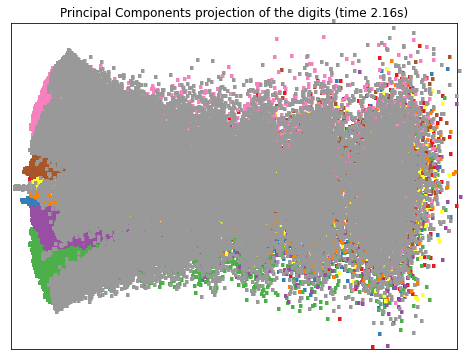

Computing t-SNE embedding


In [ ]:
plot_PCA(fft_data_abs, y_labels_data.flatten())
plot_tSNE(fft_data_abs, y_labels_data.flatten())

### Phase of FFT Data

### Real Component of FFT Data

### Imaginary Component of FFT Data


### 2D (Real and Imaginary Components) of FFT Data

Epoch 1/200
132/132 [==============================] - 13s 85ms/step - loss: 1.1904 - accuracy: 0.6826 - val_loss: 1.3448 - val_accuracy: 0.5413
Epoch 2/200
132/132 [==============================] - 11s 82ms/step - loss: 0.5252 - accuracy: 0.8566 - val_loss: 0.7957 - val_accuracy: 0.7038
Epoch 3/200
132/132 [==============================] - 11s 82ms/step - loss: 0.4676 - accuracy: 0.8642 - val_loss: 0.4560 - val_accuracy: 0.8699
Epoch 4/200
132/132 [==============================] - 11s 82ms/step - loss: 0.4328 - accuracy: 0.8697 - val_loss: 0.4028 - val_accuracy: 0.8765
Epoch 5/200
132/132 [==============================] - 11s 81ms/step - loss: 0.4095 - accuracy: 0.8730 - val_loss: 0.3957 - val_accuracy: 0.8775
Epoch 6/200
132/132 [==============================] - 11s 80ms/step - loss: 0.4065 - accuracy: 0.8728 - val_loss: 0.3938 - val_accuracy: 0.8723
Epoch 7/200
132/132 [==============================] - 11s 80ms/step - loss: 0.3940 - accuracy: 0.8758 - val_loss: 0.3733 - val_ac

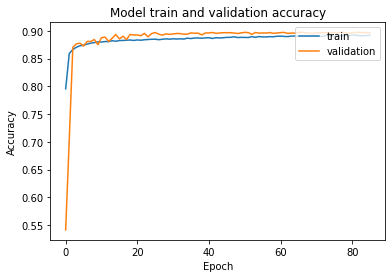

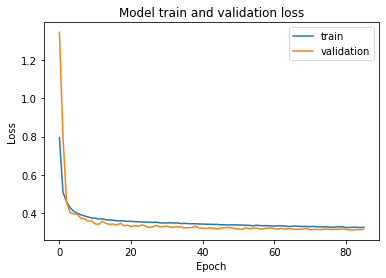

In [ ]:
fft_2d = CNN2D()

fft_data_2d = np.reshape(fft_data_2d, (total_num_snapshots, num_samples, 2))
# obtain training data
X_train, Y_train, X_validation, Y_validation, X_test,  Y_test = train_valid_test(fft_data_2d, y_labels)

# training 
history = fft_2d.fit(X_train, Y_train, epochs=200, batch_size=1024,  validation_data = (X_validation, Y_validation), shuffle=True, callbacks=[ES])
fft_2d.save("/gdrive/My Drive/Trained Models/fft/fft_2d_2dlSNR.tf")

# evaluating on test dataset
score = fft_2d.evaluate(X_test, Y_test, verbose=0)
print('\nTest Score = ' + str(score[1]*100) + '\n')

summarize_model(history)


### A/P (Amplitude and Phase Components) of FFT Data

Epoch 1/200
132/132 [==============================] - 13s 85ms/step - loss: 1.8749 - accuracy: 0.4465 - val_loss: 1.8167 - val_accuracy: 0.2142
Epoch 2/200
132/132 [==============================] - 11s 82ms/step - loss: 0.4816 - accuracy: 0.8665 - val_loss: 2.3718 - val_accuracy: 0.1666
Epoch 3/200
132/132 [==============================] - 11s 82ms/step - loss: 0.4189 - accuracy: 0.8736 - val_loss: 1.1503 - val_accuracy: 0.5628
Epoch 4/200
132/132 [==============================] - 11s 81ms/step - loss: 0.3946 - accuracy: 0.8770 - val_loss: 0.4425 - val_accuracy: 0.8498
Epoch 5/200
132/132 [==============================] - 11s 80ms/step - loss: 0.3814 - accuracy: 0.8784 - val_loss: 0.3281 - val_accuracy: 0.8891
Epoch 6/200
132/132 [==============================] - 11s 80ms/step - loss: 0.3715 - accuracy: 0.8805 - val_loss: 0.3240 - val_accuracy: 0.8903
Epoch 7/200
132/132 [==============================] - 11s 80ms/step - loss: 0.3632 - accuracy: 0.8818 - val_loss: 0.3120 - val_ac

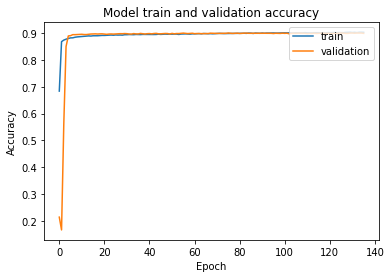

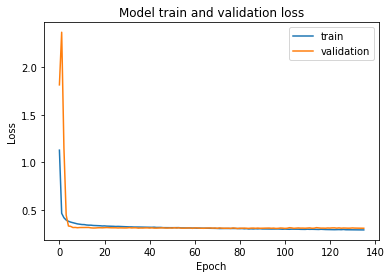

In [ ]:
fft_ap = CNN2D()

# obtain training data
X_train, Y_train, X_validation, Y_validation, X_test,  Y_test = train_valid_test(fft_data_ap, y_labels)

# training 
history = fft_ap.fit(X_train, Y_train, epochs=200, batch_size=1024,  validation_data = (X_validation, Y_validation), shuffle=True, callbacks=[ES])
fft_ap.save("/gdrive/My Drive/Trained Models/fft/fft_ap_allSNR.tf")

# evaluating on test dataset
score = fft_ap.evaluate(X_test, Y_test, verbose=0)
print('\nTest Score = ' + str(score[1]*100) + '\n')

summarize_model(history)

In [ ]:
function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)

## Amplitude Plots

In [ ]:
import matplotlib.pyplot as plt
titles = ['Bluetooth CH20', 'Bluetooth CH21', 'Bluetooth CH22', 'Bluetooth CH23', 'Bluetooth CH24', 'Bluetooth CH25', 'Bluetooth CH26', 'Bluetooth CH27', 'Bluetooth CH28', 'Bluetooth CH29', 'WiFi CH3', 'WiFi CH4', 'WiFi CH5', 'ZigBee CH15', 'ZigBee CH16']

fft_view_data = x_data_fft[::num_snapshots_per_tech][:][:]
fft_view_data_complex = np.reshape(fft_view_data.flatten()[::2] + 1j*fft_view_data.flatten()[1::2], (num_tech, num_samples))
fft_view_data_real = np.reshape(fft_view_data.flatten()[::2], (num_tech, num_samples))
fft_view_data_imag = np.reshape(fft_view_data.flatten()[1::2], (num_tech, num_samples))
fft_view_data_abs = np.absolute(fft_view_data_complex)
fft_view_data_angle = np.angle(fft_view_data_complex)

### Magnitude of FFT Data

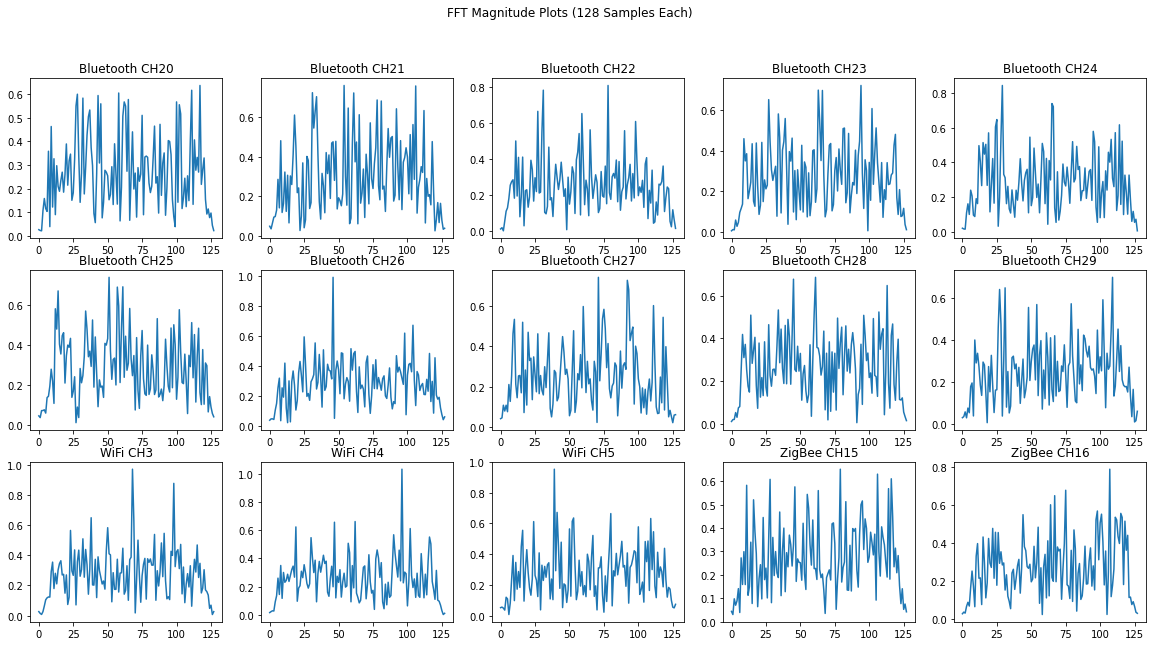

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.suptitle('FFT Magnitude Plots (128 Samples Each)')
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(num_tech):
  ax[i//5][i%5].plot(fft_view_data_abs[i])
  ax[i//5][i%5].set_title(titles[i])

### Phase of FFT Data

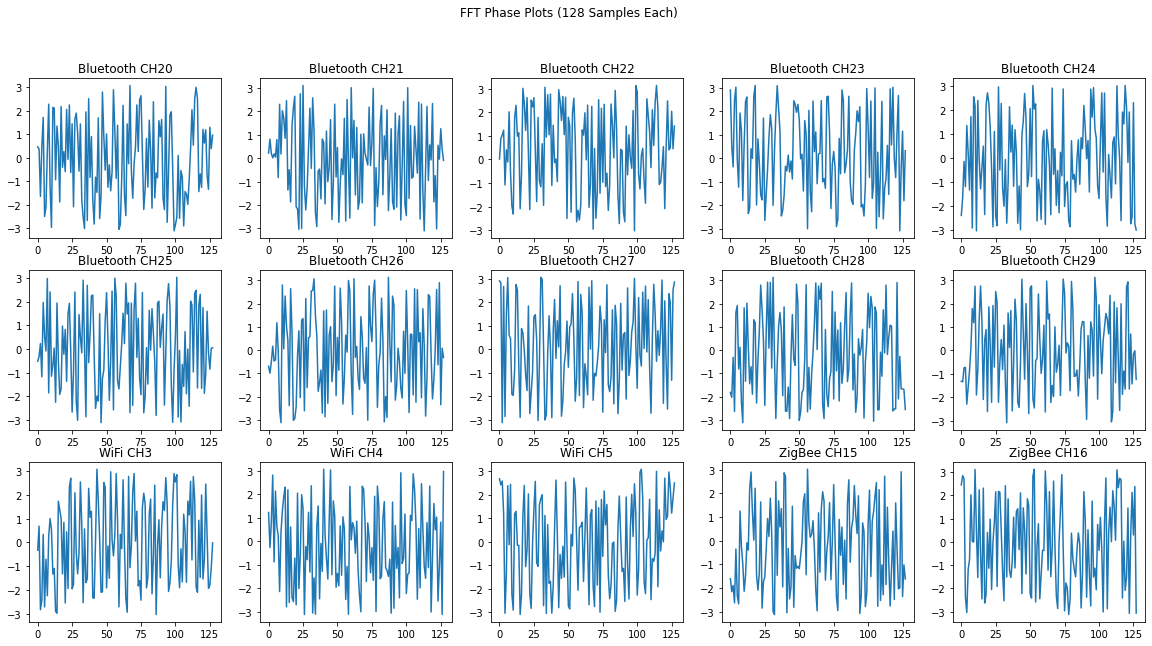

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.suptitle('FFT Phase Plots (128 Samples Each)')
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(num_tech):
  ax[i//5][i%5].plot(fft_view_data_angle[i])
  ax[i//5][i%5].set_title(titles[i])

### Real Component of FFT Data

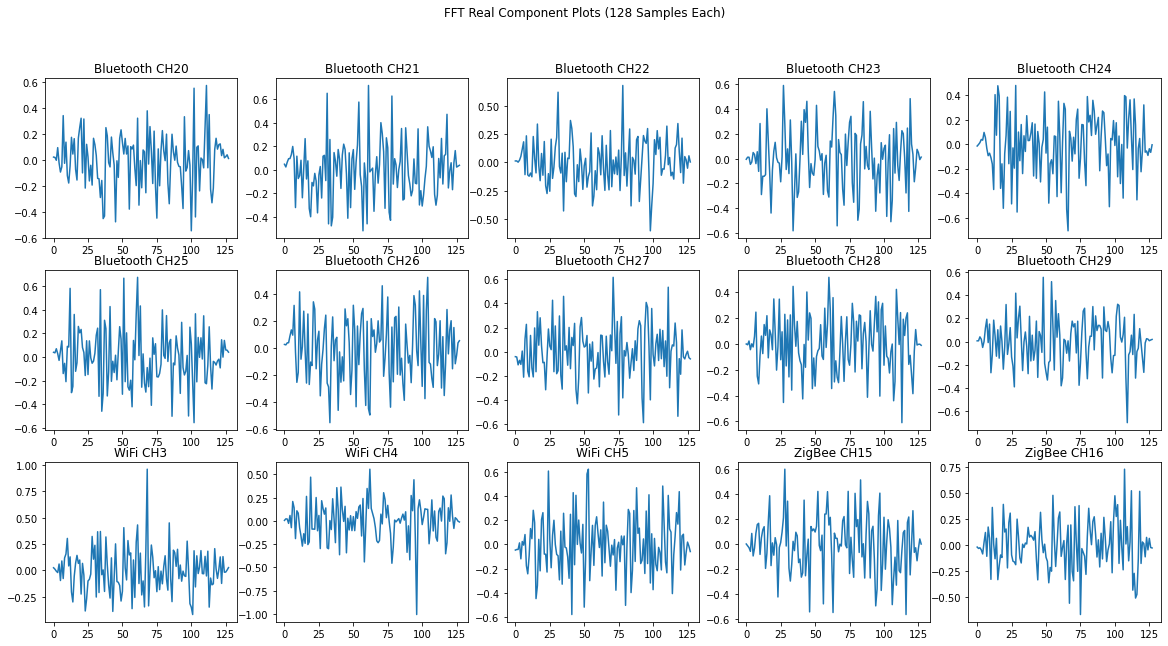

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.suptitle('FFT Real Component Plots (128 Samples Each)')
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(num_tech):
  ax[i//5][i%5].plot(fft_view_data_real[i])
  ax[i//5][i%5].set_title(titles[i])

### Imaginary Component of FFT Data

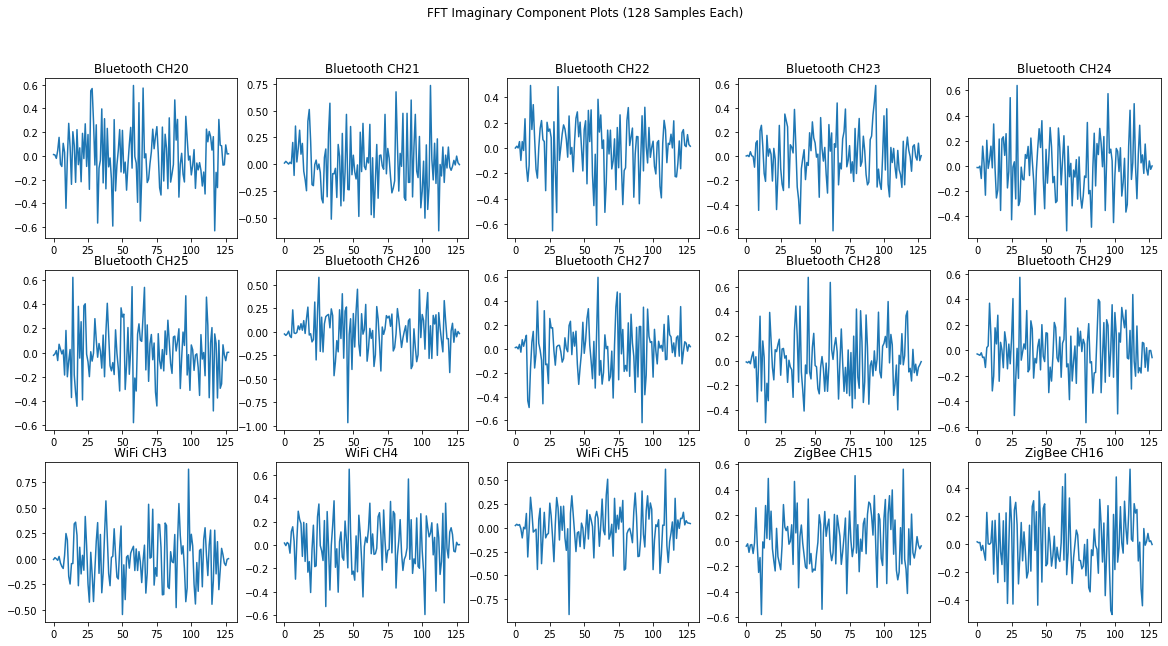

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.suptitle('FFT Imaginary Component Plots (128 Samples Each)')
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(num_tech):
  ax[i//5][i%5].plot(fft_view_data_imag[i])
  ax[i//5][i%5].set_title(titles[i])

# Data Format Selection

## Training tool-functions

In [14]:
from matplotlib import pyplot

def summarize_model(history):

  pyplot.plot(history.history['accuracy'])
  pyplot.plot(history.history['val_accuracy']) 
  pyplot.title('Model train and validation accuracy')
  pyplot.ylabel('Accuracy')
  pyplot.xlabel('Epoch')
  pyplot.legend(['train', 'validation'], loc='upper right')
  pyplot.show()

  pyplot.plot(history.history['loss'])
  pyplot.plot(history.history['val_loss'])  
  pyplot.title('Model train and validation loss')
  pyplot.ylabel('Loss')
  pyplot.xlabel('Epoch')
  pyplot.legend(['train', 'validation'], loc='upper right')
  pyplot.show()

In [15]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

def train_valid_test(x_data, y_labels):

  X_train, X_test_valid, Y_train, Y_test_valid = train_test_split(x_data, y_labels, test_size=0.4)
  X_validation, X_test, Y_validation, Y_test = train_test_split(X_test_valid, Y_test_valid, test_size=0.5)

  return X_train, Y_train, X_validation, Y_validation, X_test, Y_test

In [16]:
from keras.callbacks import EarlyStopping
ES = EarlyStopping(monitor = 'val_accuracy', mode = 'max', min_delta = 0.001, patience = 60, verbose = 1)

import logging
logging.disable(logging.WARNING)

## Magnitude of FFT Data

Epoch 1/200
132/132 [==============================] - 22s 150ms/step - loss: 0.9920 - accuracy: 0.7419 - val_loss: 4.5122 - val_accuracy: 0.0676
Epoch 2/200
132/132 [==============================] - 19s 144ms/step - loss: 0.4266 - accuracy: 0.8737 - val_loss: 5.4175 - val_accuracy: 0.0788
Epoch 3/200
132/132 [==============================] - 19s 145ms/step - loss: 0.3888 - accuracy: 0.8783 - val_loss: 4.2571 - val_accuracy: 0.1363
Epoch 4/200
132/132 [==============================] - 19s 144ms/step - loss: 0.3715 - accuracy: 0.8830 - val_loss: 1.7936 - val_accuracy: 0.3790
Epoch 5/200
132/132 [==============================] - 19s 145ms/step - loss: 0.3516 - accuracy: 0.8876 - val_loss: 0.5531 - val_accuracy: 0.8167
Epoch 6/200
132/132 [==============================] - 19s 145ms/step - loss: 0.3486 - accuracy: 0.8867 - val_loss: 0.3303 - val_accuracy: 0.8895
Epoch 7/200
132/132 [==============================] - 19s 145ms/step - loss: 0.3474 - accuracy: 0.8866 - val_loss: 0.3511 -

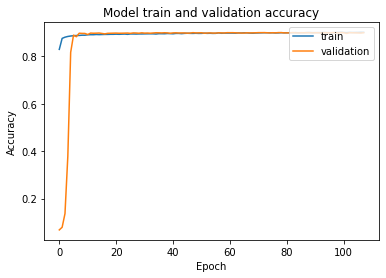

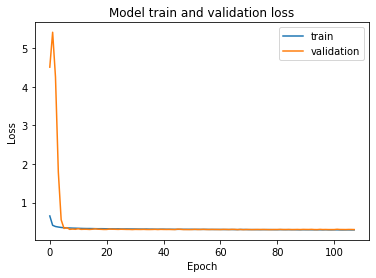

In [ ]:
fft_abs = CNN1D()

fft_data_abs = np.reshape(fft_data_abs, (total_num_snapshots, num_samples, 1))
# obtain training data
X_train, Y_train, X_validation, Y_validation, X_test,  Y_test = train_valid_test(fft_data_abs, y_labels)

# training 
history = fft_abs.fit(X_train, Y_train, epochs=200, batch_size=1024,  validation_data = (X_validation, Y_validation), shuffle=True, callbacks=[ES])
fft_abs.save("/gdrive/My Drive/Trained Models/fft/fft_abs_allSNR.tf")

# evaluating on test dataset
score = fft_abs.evaluate(X_test, Y_test, verbose=0)
print('\nTest Score = ' + str(score[1]*100) + '\n')

summarize_model(history)

## Phase of FFT Data

Epoch 1/200
132/132 [==============================] - 22s 148ms/step - loss: 2.8173 - accuracy: 0.1069 - val_loss: 2.5747 - val_accuracy: 0.2083
Epoch 2/200
132/132 [==============================] - 19s 143ms/step - loss: 2.2840 - accuracy: 0.2768 - val_loss: 2.5131 - val_accuracy: 0.2722
Epoch 3/200
132/132 [==============================] - 19s 143ms/step - loss: 2.1090 - accuracy: 0.3287 - val_loss: 2.3647 - val_accuracy: 0.3000
Epoch 4/200
132/132 [==============================] - 19s 143ms/step - loss: 2.0150 - accuracy: 0.3631 - val_loss: 2.2108 - val_accuracy: 0.3384
Epoch 5/200
132/132 [==============================] - 19s 143ms/step - loss: 1.9532 - accuracy: 0.3832 - val_loss: 2.1160 - val_accuracy: 0.3694
Epoch 6/200
132/132 [==============================] - 19s 143ms/step - loss: 1.9092 - accuracy: 0.3985 - val_loss: 2.1452 - val_accuracy: 0.3713
Epoch 7/200
132/132 [==============================] - 19s 143ms/step - loss: 1.8726 - accuracy: 0.4104 - val_loss: 2.2967 -

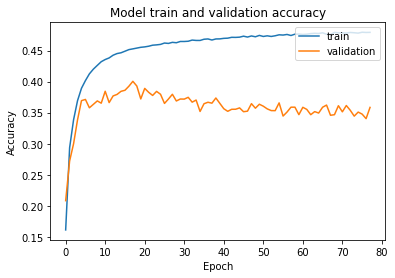

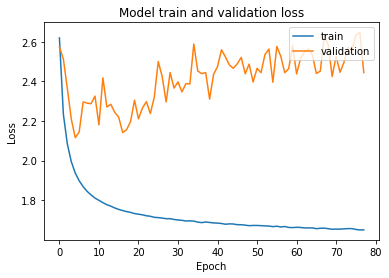

In [ ]:
fft_phase = CNN1D()

fft_data_angle = np.reshape(fft_data_angle, (total_num_snapshots, num_samples, 1))
# obtain training data
X_train, Y_train, X_validation, Y_validation, X_test,  Y_test = train_valid_test(fft_data_angle, y_labels)

# training 
history = fft_phase.fit(X_train, Y_train, epochs=200, batch_size=1024,  validation_data = (X_validation, Y_validation), shuffle=True, callbacks=[ES])
fft_phase.save("/gdrive/My Drive/Trained Models/fft/fft_phase_allSNR.tf")

# evaluating on test dataset
score = fft_phase.evaluate(X_test, Y_test, verbose=0)
print('\nTest Score = ' + str(score[1]*100) + '\n')

summarize_model(history)

## Real Component of FFT Data

Epoch 1/200
132/132 [==============================] - 22s 148ms/step - loss: 1.2898 - accuracy: 0.6472 - val_loss: 1.5036 - val_accuracy: 0.5943
Epoch 2/200
132/132 [==============================] - 19s 143ms/step - loss: 0.6825 - accuracy: 0.8071 - val_loss: 1.5093 - val_accuracy: 0.5464
Epoch 3/200
132/132 [==============================] - 19s 143ms/step - loss: 0.6186 - accuracy: 0.8164 - val_loss: 1.3835 - val_accuracy: 0.6029
Epoch 4/200
132/132 [==============================] - 19s 142ms/step - loss: 0.5903 - accuracy: 0.8194 - val_loss: 1.0483 - val_accuracy: 0.6917
Epoch 5/200
132/132 [==============================] - 19s 143ms/step - loss: 0.5706 - accuracy: 0.8236 - val_loss: 0.8802 - val_accuracy: 0.7480
Epoch 6/200
132/132 [==============================] - 19s 143ms/step - loss: 0.5599 - accuracy: 0.8258 - val_loss: 0.7648 - val_accuracy: 0.7808
Epoch 7/200
132/132 [==============================] - 19s 143ms/step - loss: 0.5501 - accuracy: 0.8281 - val_loss: 0.6704 -

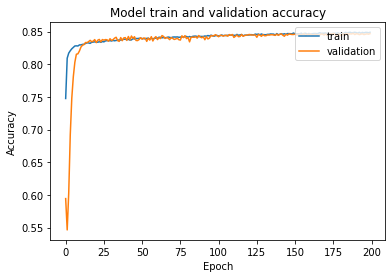

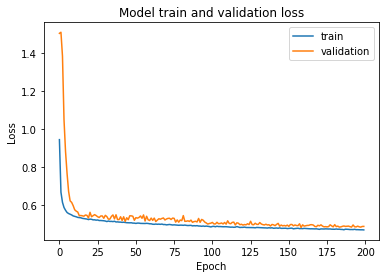

In [ ]:
fft_real = CNN1D()

fft_data_real = np.reshape(fft_data_real, (total_num_snapshots, num_samples, 1))
# obtain training data
X_train, Y_train, X_validation, Y_validation, X_test,  Y_test = train_valid_test(fft_data_real, y_labels)

# training 
history = fft_real.fit(X_train, Y_train, epochs=200, batch_size=1024,  validation_data = (X_validation, Y_validation), shuffle=True, callbacks=[ES])
fft_real.save("/gdrive/My Drive/Trained Models/fft/fft_real_allSNR.tf")

# evaluating on test dataset
score = fft_real.evaluate(X_test, Y_test, verbose=0)
print('\nTest Score = ' + str(score[1]*100) + '\n')

summarize_model(history)

## Imaginary Component of FFT Data


Epoch 1/200
132/132 [==============================] - 57s 88ms/step - loss: 1.2889 - accuracy: 0.6482 - val_loss: 1.5174 - val_accuracy: 0.5932
Epoch 2/200
132/132 [==============================] - 11s 82ms/step - loss: 0.6843 - accuracy: 0.8060 - val_loss: 1.3134 - val_accuracy: 0.5558
Epoch 3/200
132/132 [==============================] - 11s 83ms/step - loss: 0.6271 - accuracy: 0.8139 - val_loss: 1.1365 - val_accuracy: 0.6688
Epoch 4/200
132/132 [==============================] - 11s 82ms/step - loss: 0.5955 - accuracy: 0.8176 - val_loss: 0.9334 - val_accuracy: 0.7252
Epoch 5/200
132/132 [==============================] - 11s 84ms/step - loss: 0.5846 - accuracy: 0.8212 - val_loss: 0.8234 - val_accuracy: 0.7587
Epoch 6/200
132/132 [==============================] - 11s 81ms/step - loss: 0.5752 - accuracy: 0.8218 - val_loss: 0.6551 - val_accuracy: 0.8024
Epoch 7/200
132/132 [==============================] - 11s 80ms/step - loss: 0.5606 - accuracy: 0.8254 - val_loss: 0.6653 - val_ac

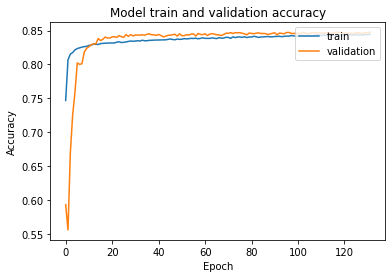

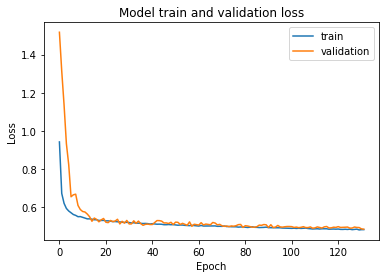

In [ ]:
fft_imag = CNN1D()

fft_data_imag = np.reshape(fft_data_imag, (total_num_snapshots, num_samples, 1))
# obtain training data
X_train, Y_train, X_validation, Y_validation, X_test,  Y_test = train_valid_test(fft_data_imag, y_labels)

# training 
history = fft_imag.fit(X_train, Y_train, epochs=200, batch_size=1024,  validation_data = (X_validation, Y_validation), shuffle=True, callbacks=[ES])
fft_imag.save("/gdrive/My Drive/Trained Models/fft/fft_imag_allSNR.tf")

# evaluating on test dataset
score = fft_imag.evaluate(X_test, Y_test, verbose=0)
print('\nTest Score = ' + str(score[1]*100) + '\n')

summarize_model(history)

## 2D (Real and Imaginary Components) of FFT Data

Epoch 1/200
132/132 [==============================] - 13s 85ms/step - loss: 1.1904 - accuracy: 0.6826 - val_loss: 1.3448 - val_accuracy: 0.5413
Epoch 2/200
132/132 [==============================] - 11s 82ms/step - loss: 0.5252 - accuracy: 0.8566 - val_loss: 0.7957 - val_accuracy: 0.7038
Epoch 3/200
132/132 [==============================] - 11s 82ms/step - loss: 0.4676 - accuracy: 0.8642 - val_loss: 0.4560 - val_accuracy: 0.8699
Epoch 4/200
132/132 [==============================] - 11s 82ms/step - loss: 0.4328 - accuracy: 0.8697 - val_loss: 0.4028 - val_accuracy: 0.8765
Epoch 5/200
132/132 [==============================] - 11s 81ms/step - loss: 0.4095 - accuracy: 0.8730 - val_loss: 0.3957 - val_accuracy: 0.8775
Epoch 6/200
132/132 [==============================] - 11s 80ms/step - loss: 0.4065 - accuracy: 0.8728 - val_loss: 0.3938 - val_accuracy: 0.8723
Epoch 7/200
132/132 [==============================] - 11s 80ms/step - loss: 0.3940 - accuracy: 0.8758 - val_loss: 0.3733 - val_ac

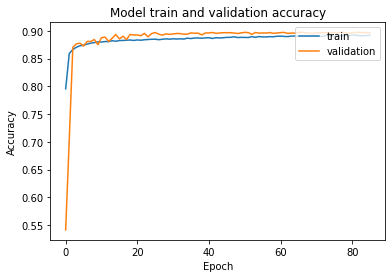

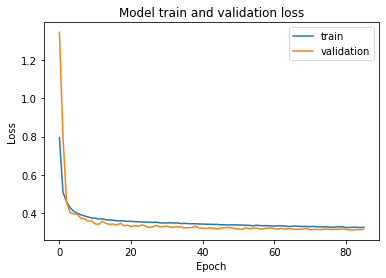

In [ ]:
fft_2d = CNN2D()

fft_data_2d = np.reshape(fft_data_2d, (total_num_snapshots, num_samples, 2))
# obtain training data
X_train, Y_train, X_validation, Y_validation, X_test,  Y_test = train_valid_test(fft_data_2d, y_labels)

# training 
history = fft_2d.fit(X_train, Y_train, epochs=200, batch_size=1024,  validation_data = (X_validation, Y_validation), shuffle=True, callbacks=[ES])
fft_2d.save("/gdrive/My Drive/Trained Models/fft/fft_2d_2dlSNR.tf")

# evaluating on test dataset
score = fft_2d.evaluate(X_test, Y_test, verbose=0)
print('\nTest Score = ' + str(score[1]*100) + '\n')

summarize_model(history)



## A/P (Amplitude and Phase Components) of FFT Data

Epoch 1/200
132/132 [==============================] - 13s 85ms/step - loss: 1.8749 - accuracy: 0.4465 - val_loss: 1.8167 - val_accuracy: 0.2142
Epoch 2/200
132/132 [==============================] - 11s 82ms/step - loss: 0.4816 - accuracy: 0.8665 - val_loss: 2.3718 - val_accuracy: 0.1666
Epoch 3/200
132/132 [==============================] - 11s 82ms/step - loss: 0.4189 - accuracy: 0.8736 - val_loss: 1.1503 - val_accuracy: 0.5628
Epoch 4/200
132/132 [==============================] - 11s 81ms/step - loss: 0.3946 - accuracy: 0.8770 - val_loss: 0.4425 - val_accuracy: 0.8498
Epoch 5/200
132/132 [==============================] - 11s 80ms/step - loss: 0.3814 - accuracy: 0.8784 - val_loss: 0.3281 - val_accuracy: 0.8891
Epoch 6/200
132/132 [==============================] - 11s 80ms/step - loss: 0.3715 - accuracy: 0.8805 - val_loss: 0.3240 - val_accuracy: 0.8903
Epoch 7/200
132/132 [==============================] - 11s 80ms/step - loss: 0.3632 - accuracy: 0.8818 - val_loss: 0.3120 - val_ac

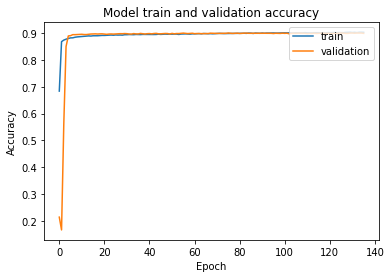

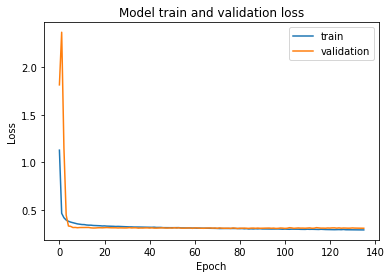

In [ ]:
fft_ap = CNN2D()

# obtain training data
X_train, Y_train, X_validation, Y_validation, X_test,  Y_test = train_valid_test(fft_data_ap, y_labels)

# training 
history = fft_ap.fit(X_train, Y_train, epochs=200, batch_size=1024,  validation_data = (X_validation, Y_validation), shuffle=True, callbacks=[ES])
fft_ap.save("/gdrive/My Drive/Trained Models/fft/fft_ap_allSNR.tf")

# evaluating on test dataset
score = fft_ap.evaluate(X_test, Y_test, verbose=0)
print('\nTest Score = ' + str(score[1]*100) + '\n')

summarize_model(history)

In [ ]:
function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)

# Training and Analysis

## FFT 2D

### High SNR

In [ ]:
x_dim = x_data_fft_data[:,10:21].shape
total_num_snapshots = x_dim[0]*x_dim[1]*x_dim[2]
num_snapshots_per_tech = x_dim[1]*x_dim[2]
num_tech = x_dim[0]
num_samples = x_dim[3]

x_data_fft_high = np.reshape(x_data_fft_data[:,10:21], (total_num_snapshots, x_dim[3], x_dim[4]))
fft_data_flat = scaler_std.fit_transform(np.reshape(x_data_fft_high, (total_num_snapshots, num_samples*2)))
fft_data_2d_high = np.reshape(fft_data_flat, (total_num_snapshots, num_samples, 2))
y_labels_high = to_categorical(y_labels_data[:,10:21].flatten())

Epoch 1/200
70/70 [==============================] - 8s 86ms/step - loss: 0.8144 - accuracy: 0.8056 - val_loss: 1.0870 - val_accuracy: 0.7118
Epoch 2/200
70/70 [==============================] - 5s 78ms/step - loss: 0.0856 - accuracy: 0.9929 - val_loss: 1.0644 - val_accuracy: 0.7579
Epoch 3/200
70/70 [==============================] - 5s 78ms/step - loss: 0.0408 - accuracy: 0.9957 - val_loss: 0.7080 - val_accuracy: 0.9106
Epoch 4/200
70/70 [==============================] - 6s 79ms/step - loss: 0.0266 - accuracy: 0.9968 - val_loss: 0.4431 - val_accuracy: 0.9314
Epoch 5/200
70/70 [==============================] - 6s 81ms/step - loss: 0.0205 - accuracy: 0.9968 - val_loss: 0.2782 - val_accuracy: 0.9329
Epoch 6/200
70/70 [==============================] - 6s 79ms/step - loss: 0.0149 - accuracy: 0.9978 - val_loss: 0.2023 - val_accuracy: 0.9369
Epoch 7/200
70/70 [==============================] - 6s 79ms/step - loss: 0.0124 - accuracy: 0.9982 - val_loss: 0.1176 - val_accuracy: 0.9572
Epoch 

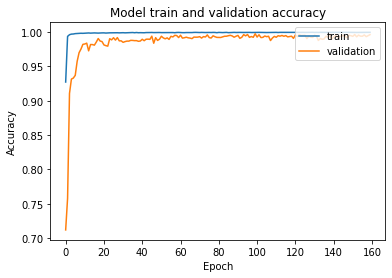

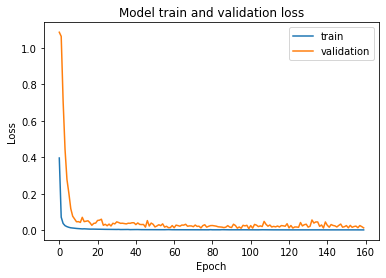

In [ ]:
fft_2d = CNN2D()

# obtain training data
X_train, Y_train, X_validation, Y_validation, X_test,  Y_test = train_valid_test(fft_data_2d_high, y_labels_high)

# training 
history = fft_2d.fit(X_train, Y_train, epochs=200, batch_size=1024,  validation_data = (X_validation, Y_validation), shuffle=True, callbacks=[ES])
fft_2d.save("/gdrive/My Drive/Trained Models/fft/fft_2d_highSNR.tf")

# evaluating on test dataset
score = fft_2d.evaluate(X_test, Y_test, verbose=0)
print('\nTest Score = ' + str(score[1]*100) + '\n')

summarize_model(history)

### Low SNR

In [ ]:
x_dim = x_data_fft_data[:,0:10].shape
total_num_snapshots = x_dim[0]*x_dim[1]*x_dim[2]
num_snapshots_per_tech = x_dim[1]*x_dim[2]
num_tech = x_dim[0]
num_samples = x_dim[3]

x_data_fft_low = np.reshape(x_data_fft_data[:,0:10], (total_num_snapshots, x_dim[3], x_dim[4]))
fft_data_flat = scaler_std.fit_transform(np.reshape(x_data_fft_low, (total_num_snapshots, num_samples*2)))
fft_data_2d_low = np.reshape(fft_data_flat, (total_num_snapshots, num_samples, 2))
y_labels_low = to_categorical(y_labels_data[:,0:10].flatten())

Epoch 1/200
63/63 [==============================] - 8s 94ms/step - loss: 2.0156 - accuracy: 0.4056 - val_loss: 1.7053 - val_accuracy: 0.3614
Epoch 2/200
63/63 [==============================] - 5s 80ms/step - loss: 0.9811 - accuracy: 0.7093 - val_loss: 2.3995 - val_accuracy: 0.1275
Epoch 3/200
63/63 [==============================] - 5s 80ms/step - loss: 0.8836 - accuracy: 0.7279 - val_loss: 2.8325 - val_accuracy: 0.1473
Epoch 4/200
63/63 [==============================] - 5s 80ms/step - loss: 0.8527 - accuracy: 0.7344 - val_loss: 2.4491 - val_accuracy: 0.1943
Epoch 5/200
63/63 [==============================] - 5s 80ms/step - loss: 0.8294 - accuracy: 0.7386 - val_loss: 1.7015 - val_accuracy: 0.4027
Epoch 6/200
63/63 [==============================] - 5s 80ms/step - loss: 0.8049 - accuracy: 0.7415 - val_loss: 1.3060 - val_accuracy: 0.5421
Epoch 7/200
63/63 [==============================] - 5s 80ms/step - loss: 0.7822 - accuracy: 0.7477 - val_loss: 1.0198 - val_accuracy: 0.6635
Epoch 

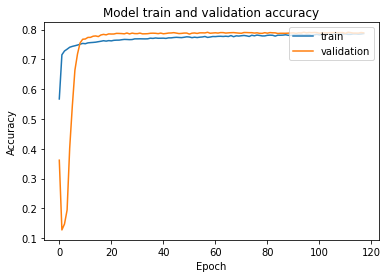

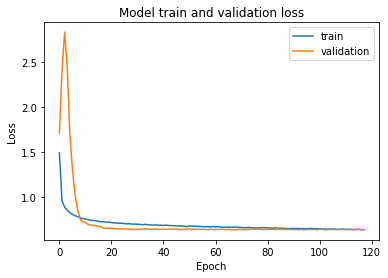

In [ ]:
fft_2d = CNN2D()

# obtain training data
X_train, Y_train, X_validation, Y_validation, X_test,  Y_test = train_valid_test(fft_data_2d_low, y_labels_low)

# training 
history = fft_2d.fit(X_train, Y_train, epochs=200, batch_size=1024,  validation_data = (X_validation, Y_validation), shuffle=True, callbacks=[ES])
fft_2d.save("/gdrive/My Drive/Trained Models/fft/fft_2d_lowSNR.tf")

# evaluating on test dataset
score = fft_2d.evaluate(X_test, Y_test, verbose=0)
print('\nTest Score = ' + str(score[1]*100) + '\n')

summarize_model(history)

## FFT Amplitude



### High SNR

In [ ]:
x_dim = x_data_fft_data[:,10:21].shape
total_num_snapshots = x_dim[0]*x_dim[1]*x_dim[2]
num_snapshots_per_tech = x_dim[1]*x_dim[2]
num_tech = x_dim[0]
num_samples = x_dim[3]

fft_data_complex_high = np.reshape(x_data_fft_data[:,10:21].flatten()[::2] + 1j*x_data_fft_data[:,10:21].flatten()[1::2], (total_num_snapshots, num_samples))
fft_data_abs_high = scaler_01.fit_transform(np.absolute(fft_data_complex_high))
y_labels_high = to_categorical(y_labels_data[:,10:21].flatten())

Epoch 1/200
70/70 [==============================] - 8s 87ms/step - loss: 0.6821 - accuracy: 0.8439 - val_loss: 1.7871 - val_accuracy: 0.4559
Epoch 2/200
70/70 [==============================] - 6s 80ms/step - loss: 0.0534 - accuracy: 0.9957 - val_loss: 2.2161 - val_accuracy: 0.0814
Epoch 3/200
70/70 [==============================] - 6s 80ms/step - loss: 0.0268 - accuracy: 0.9968 - val_loss: 2.2913 - val_accuracy: 0.0909
Epoch 4/200
70/70 [==============================] - 6s 81ms/step - loss: 0.0175 - accuracy: 0.9978 - val_loss: 2.0515 - val_accuracy: 0.1411
Epoch 5/200
70/70 [==============================] - 6s 81ms/step - loss: 0.0136 - accuracy: 0.9979 - val_loss: 1.2855 - val_accuracy: 0.4174
Epoch 6/200
70/70 [==============================] - 6s 82ms/step - loss: 0.0116 - accuracy: 0.9982 - val_loss: 0.6251 - val_accuracy: 0.7907
Epoch 7/200
70/70 [==============================] - 6s 81ms/step - loss: 0.0100 - accuracy: 0.9982 - val_loss: 0.2100 - val_accuracy: 0.9535
Epoch 

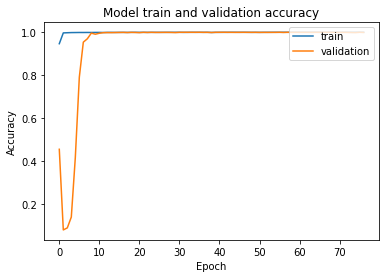

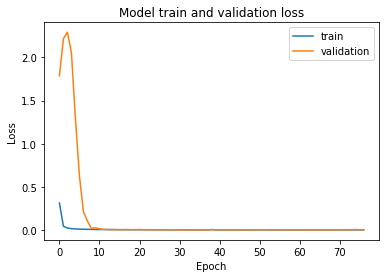

In [ ]:
fft_abs = CNN1D()

fft_data_abs_high = np.reshape(fft_data_abs_high, (total_num_snapshots, num_samples, 1))
# obtain training data
X_train, Y_train, X_validation, Y_validation, X_test,  Y_test = train_valid_test(fft_data_abs_high, y_labels_high)

# training 
history = fft_abs.fit(X_train, Y_train, epochs=200, batch_size=1024,  validation_data = (X_validation, Y_validation), shuffle=True, callbacks=[ES])
fft_abs.save("/gdrive/My Drive/Trained Models/fft/fft_abs_highSNR.tf")

# evaluating on test dataset
score = fft_abs.evaluate(X_test, Y_test, verbose=0)
print('\nTest Score = ' + str(score[1]*100) + '\n')

summarize_model(history)

### Low SNR

In [ ]:
x_dim = x_data_fft_data[:,0:10].shape
total_num_snapshots = x_dim[0]*x_dim[1]*x_dim[2]
num_snapshots_per_tech = x_dim[1]*x_dim[2]
num_tech = x_dim[0]
num_samples = x_dim[3]

fft_data_complex_low = np.reshape(x_data_fft_data[:,0:10].flatten()[::2] + 1j*x_data_fft_data[:,0:10].flatten()[1::2], (total_num_snapshots, num_samples))
fft_data_abs_low = scaler_01.fit_transform(np.absolute(fft_data_complex_low))
y_labels_low = to_categorical(y_labels_data[:,0:10].flatten())

Epoch 1/200
63/63 [==============================] - 8s 94ms/step - loss: 1.7073 - accuracy: 0.5132 - val_loss: 2.5265 - val_accuracy: 0.0669
Epoch 2/200
63/63 [==============================] - 5s 82ms/step - loss: 0.8641 - accuracy: 0.7445 - val_loss: 4.0069 - val_accuracy: 0.0667
Epoch 3/200
63/63 [==============================] - 5s 81ms/step - loss: 0.7812 - accuracy: 0.7556 - val_loss: 5.2315 - val_accuracy: 0.0667
Epoch 4/200
63/63 [==============================] - 5s 82ms/step - loss: 0.7529 - accuracy: 0.7607 - val_loss: 6.1598 - val_accuracy: 0.0667
Epoch 5/200
63/63 [==============================] - 5s 81ms/step - loss: 0.7393 - accuracy: 0.7645 - val_loss: 6.3598 - val_accuracy: 0.0667
Epoch 6/200
63/63 [==============================] - 5s 81ms/step - loss: 0.7248 - accuracy: 0.7648 - val_loss: 5.8449 - val_accuracy: 0.0669
Epoch 7/200
63/63 [==============================] - 5s 81ms/step - loss: 0.7052 - accuracy: 0.7680 - val_loss: 4.5361 - val_accuracy: 0.0832
Epoch 

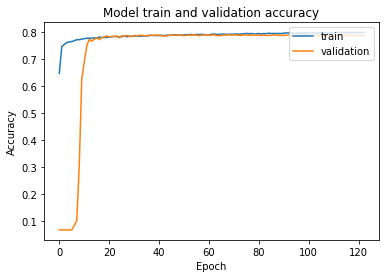

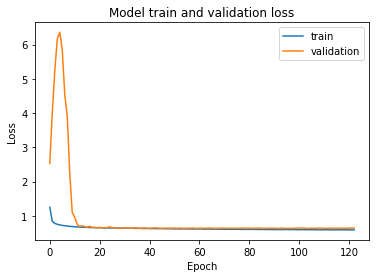

In [ ]:
fft_abs = CNN1D()

fft_data_abs_low = np.reshape(fft_data_abs_low, (total_num_snapshots, num_samples, 1))
# obtain training data
X_train, Y_train, X_validation, Y_validation, X_test,  Y_test = train_valid_test(fft_data_abs_low, y_labels_low)

# training 
history = fft_abs.fit(X_train, Y_train, epochs=200, batch_size=1024,  validation_data = (X_validation, Y_validation), shuffle=True, callbacks=[ES])
fft_abs.save("/gdrive/My Drive/Trained Models/fft/fft_abs_lowSNR.tf")

# evaluating on test dataset
score = fft_abs.evaluate(X_test, Y_test, verbose=0)
print('\nTest Score = ' + str(score[1]*100) + '\n')

summarize_model(history)

# Transfer learning

## Helper functions

In [17]:
from matplotlib import pyplot
from keras import models

def summarize_model(history, i):

  pyplot.plot(history.history['accuracy'])
  pyplot.plot(history.history['val_accuracy']) 
  pyplot.title('Model train and validation accuracy - SNR ' + str(2*i-20))
  pyplot.ylabel('Accuracy')
  pyplot.xlabel('Epoch')
  pyplot.legend(['train', 'validation'], loc='upper right')
  pyplot.show()

  pyplot.plot(history.history['loss'])
  pyplot.plot(history.history['val_loss'])  
  pyplot.title('Model train and validation loss - SNR ' + str(2*i-20))
  pyplot.ylabel('Loss')
  pyplot.xlabel('Epoch')
  pyplot.legend(['train', 'validation'], loc='upper right')
  pyplot.show()

In [18]:
score_arr = [0, 0]

def train_data(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, i):
  
  print("\nTraining SNR = "+str(2*i-20)+" Data\n")
  model_curr = CNN1D()
  history = model_curr.fit(X_train_curr, Y_train_curr, validation_data = (X_validation_curr, Y_validation_curr), epochs=200, batch_size=1024)

  score = model_curr.evaluate(X_test_curr, Y_test_curr, verbose=0)
  print('\nEvaluating on Test data : Score of SNR ' + str(2*i-20) + ' = ' + str(score[1]*100) +'\n')
  score_ = score[1]*100
  summarize_model(history, i)

  del history, model_curr
  return score_

def train_data_on_all_snr_model(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, model_folder, i):
  
  all_snr_model = models.load_model(model_folder)
  score = all_snr_model.evaluate(X_test_curr, Y_test_curr, verbose=0)
  print('\nScore of SNR on All SNR model without Transfer Learning ' + str(2*i-20) + ' = ' + str(score[1]*100))
  score_arr[0] = score[1]*100

  print("\nTraining SNR = "+str(2*i-20)+" Data on a pre-trained All SNR model\n")
  history = all_snr_model.fit(X_train_curr, Y_train_curr, validation_data = (X_validation_curr, Y_validation_curr), epochs=200, batch_size=1024, callbacks=[ES])

  score = all_snr_model.evaluate(X_test_curr, Y_test_curr, verbose=0)
  print('\nEvaluating on Test data : Score of SNR ' + str(2*i-20) + ' = ' + str(score[1]*100) +'\n')
  score_arr[1] = score[1]*100
  summarize_model(history, i)

  del history, all_snr_model
  return score_arr

def train_data_on_high_snr_model(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, model_folder, i):
  
  high_snr_model = models.load_model(model_folder)
  score = high_snr_model.evaluate(X_test_curr, Y_test_curr, verbose=0)
  print('Score of SNR on High SNR model without Transfer Learning ' + str(2*i-20) + ' = ' + str(score[1]*100))
  score_arr[0] = score[1]*100

  print("\nTraining SNR = "+str(2*i-20)+" Data on a pre-trained High SNR model\n")
  history = high_snr_model.fit(X_train_curr, Y_train_curr, validation_data = (X_validation_curr, Y_validation_curr), epochs=200, batch_size=1024, callbacks=[ES])

  score = high_snr_model.evaluate(X_test_curr, Y_test_curr, verbose=0)
  print('\nEvaluating on Test data : Score of SNR ' + str(2*i-20) + ' = ' + str(score[1]*100) +'\n')
  score_arr[1] = score[1]*100
  summarize_model(history, i)

  del history, high_snr_model
  return score_arr

def train_data_on_low_snr_model(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, model_folder, i):
  
  low_snr_model = models.load_model(model_folder)
  score = low_snr_model.evaluate(X_test_curr, Y_test_curr, verbose=0)
  print('Score of SNR on low SNR model without Transfer Learning ' + str(2*i-20) + ' = ' + str(score[1]*100))
  score_arr[0] = score[1]*100

  print("\nTraining SNR = "+str(2*i-20)+" Data on a pre-trained Low SNR model\n")
  history = low_snr_model.fit(X_train_curr, Y_train_curr, validation_data = (X_validation_curr, Y_validation_curr), epochs=200, batch_size=1024, callbacks=[ES])

  score = low_snr_model.evaluate(X_test_curr, Y_test_curr, verbose=0)
  print('\nEvaluating on Test data : Score of SNR ' + str(2*i-20) + ' = ' + str(score[1]*100) +'\n')
  score_arr[1] = score[1]*100
  summarize_model(history, i)

  del history, low_snr_model
  return score_arr

In [19]:
x_dim = x_data_fft_data[:,0:1].shape
total_num_snapshots = x_dim[0]*x_dim[1]*x_dim[2]
num_snapshots_per_tech = x_dim[1]*x_dim[2]
num_tech = x_dim[0]
num_samples = x_dim[3]

## FFT 2D

In [20]:
scores_without_tf_2d = np.zeros(shape=(10,1))
scores_tf_allsnr_2d = np.zeros(shape=(10,2))
scores_tf_highsnr_2d = np.zeros(shape=(10,2))
scores_tf_lowsnr_2d = np.zeros(shape=(10,2))

In [21]:
model_folder_all = "/gdrive/My Drive/Trained Models/fft/fft_2d_allSNR.tf"
model_folder_high = "/gdrive/My Drive/Trained Models/fft/fft_2d_highSNR.tf"
model_folder_low = "/gdrive/My Drive/Trained Models/fft/fft_2d_lowSNR.tf"


Training SNR = -20 Data

Epoch 1/200
7/7 [==============================] - 3s 159ms/step - loss: 3.0470 - accuracy: 0.0745 - val_loss: 2.6975 - val_accuracy: 0.0848
Epoch 2/200
7/7 [==============================] - 1s 74ms/step - loss: 2.9052 - accuracy: 0.0852 - val_loss: 2.6828 - val_accuracy: 0.1128
Epoch 3/200
7/7 [==============================] - 0s 72ms/step - loss: 2.7544 - accuracy: 0.1085 - val_loss: 2.6701 - val_accuracy: 0.1254
Epoch 4/200
7/7 [==============================] - 0s 72ms/step - loss: 2.6778 - accuracy: 0.1397 - val_loss: 2.6543 - val_accuracy: 0.1506
Epoch 5/200
7/7 [==============================] - 1s 73ms/step - loss: 2.5826 - accuracy: 0.1650 - val_loss: 2.6351 - val_accuracy: 0.1660
Epoch 6/200
7/7 [==============================] - 1s 72ms/step - loss: 2.5029 - accuracy: 0.1908 - val_loss: 2.6164 - val_accuracy: 0.1902
Epoch 7/200
7/7 [==============================] - 0s 72ms/step - loss: 2.4461 - accuracy: 0.2209 - val_loss: 2.5999 - val_accuracy: 

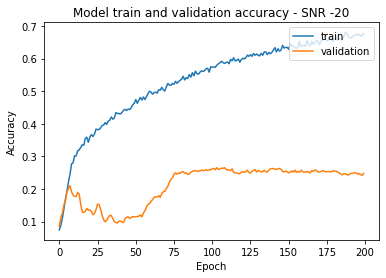

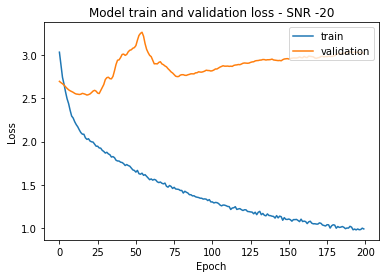


Score of SNR on All SNR model without Transfer Learning -20 = 14.87179547548294

Training SNR = -20 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 83ms/step - loss: 4.6051 - accuracy: 0.3074 - val_loss: 4.5101 - val_accuracy: 0.1184
Epoch 2/200
7/7 [==============================] - 1s 74ms/step - loss: 4.2258 - accuracy: 0.3075 - val_loss: 4.4933 - val_accuracy: 0.1189
Epoch 3/200
7/7 [==============================] - 1s 74ms/step - loss: 3.8331 - accuracy: 0.3134 - val_loss: 4.3860 - val_accuracy: 0.1315
Epoch 4/200
7/7 [==============================] - 1s 74ms/step - loss: 3.5363 - accuracy: 0.3237 - val_loss: 4.2861 - val_accuracy: 0.1352
Epoch 5/200
7/7 [==============================] - 1s 75ms/step - loss: 3.2860 - accuracy: 0.3114 - val_loss: 4.1089 - val_accuracy: 0.1422
Epoch 6/200
7/7 [==============================] - 1s 73ms/step - loss: 3.0694 - accuracy: 0.3122 - val_loss: 3.8633 - val_accuracy: 0.1524
Epoch 7/200
7/7 [=====

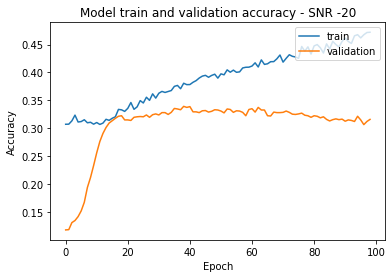

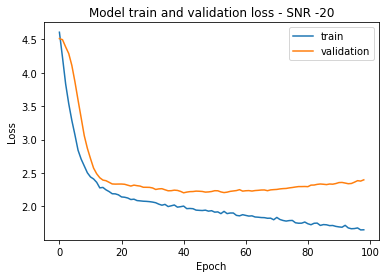

Score of SNR on High SNR model without Transfer Learning -20 = 7.365967333316803

Training SNR = -20 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 81ms/step - loss: 11.2309 - accuracy: 0.1981 - val_loss: 14.0502 - val_accuracy: 0.0699
Epoch 2/200
7/7 [==============================] - 1s 75ms/step - loss: 10.5975 - accuracy: 0.1992 - val_loss: 13.0092 - val_accuracy: 0.0727
Epoch 3/200
7/7 [==============================] - 1s 74ms/step - loss: 9.7317 - accuracy: 0.2025 - val_loss: 12.0285 - val_accuracy: 0.0774
Epoch 4/200
7/7 [==============================] - 1s 73ms/step - loss: 9.2134 - accuracy: 0.2107 - val_loss: 10.8828 - val_accuracy: 0.0834
Epoch 5/200
7/7 [==============================] - 1s 75ms/step - loss: 8.5840 - accuracy: 0.2233 - val_loss: 9.7526 - val_accuracy: 0.0890
Epoch 6/200
7/7 [==============================] - 1s 76ms/step - loss: 7.9966 - accuracy: 0.2267 - val_loss: 9.0546 - val_accuracy: 0.0946
Epoch 7/200
7/7

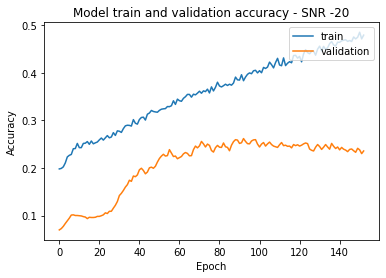

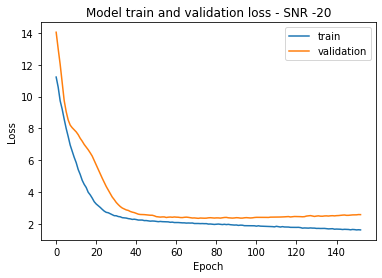

Score of SNR on low SNR model without Transfer Learning -20 = 35.19813418388367

Training SNR = -20 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 2s 83ms/step - loss: 3.9924 - accuracy: 0.3372 - val_loss: 3.0591 - val_accuracy: 0.2723
Epoch 2/200
7/7 [==============================] - 1s 80ms/step - loss: 3.6541 - accuracy: 0.3383 - val_loss: 3.4034 - val_accuracy: 0.2345
Epoch 3/200
7/7 [==============================] - 1s 75ms/step - loss: 3.3479 - accuracy: 0.3335 - val_loss: 3.3758 - val_accuracy: 0.2322
Epoch 4/200
7/7 [==============================] - 1s 77ms/step - loss: 3.1286 - accuracy: 0.3382 - val_loss: 3.0420 - val_accuracy: 0.2536
Epoch 5/200
7/7 [==============================] - 1s 75ms/step - loss: 2.8870 - accuracy: 0.3402 - val_loss: 2.7093 - val_accuracy: 0.2825
Epoch 6/200
7/7 [==============================] - 1s 74ms/step - loss: 2.7495 - accuracy: 0.3374 - val_loss: 2.4630 - val_accuracy: 0.3068
Epoch 7/200
7/7 [======

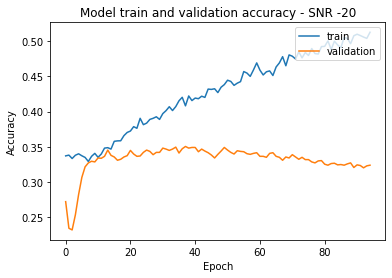

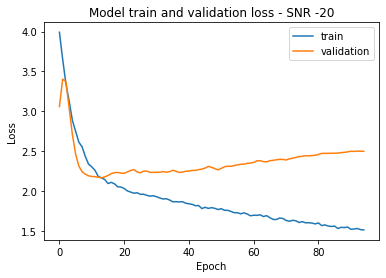

[[26.57342553]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]] [[14.87179548 32.587412  ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 7.36596733 25.82750618]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[35.19813418 34.21911299]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]

Training SNR = -18 Data

Epoch 1/20

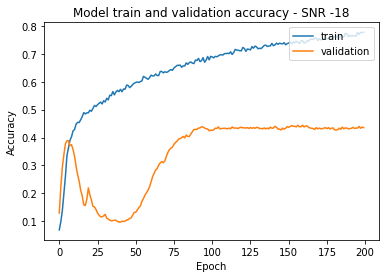

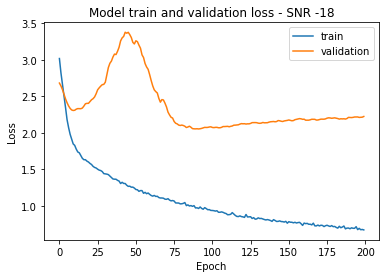


Score of SNR on All SNR model without Transfer Learning -18 = 21.724942326545715

Training SNR = -18 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 87ms/step - loss: 3.1042 - accuracy: 0.4421 - val_loss: 3.1087 - val_accuracy: 0.2392
Epoch 2/200
7/7 [==============================] - 1s 77ms/step - loss: 2.8818 - accuracy: 0.4480 - val_loss: 3.0550 - val_accuracy: 0.2522
Epoch 3/200
7/7 [==============================] - 1s 77ms/step - loss: 2.6526 - accuracy: 0.4673 - val_loss: 2.9554 - val_accuracy: 0.2695
Epoch 4/200
7/7 [==============================] - 1s 74ms/step - loss: 2.5122 - accuracy: 0.4671 - val_loss: 2.8256 - val_accuracy: 0.2890
Epoch 5/200
7/7 [==============================] - 1s 75ms/step - loss: 2.3168 - accuracy: 0.4674 - val_loss: 2.7239 - val_accuracy: 0.3096
Epoch 6/200
7/7 [==============================] - 1s 77ms/step - loss: 2.1891 - accuracy: 0.4643 - val_loss: 2.6076 - val_accuracy: 0.3217
Epoch 7/200
7/7 [====

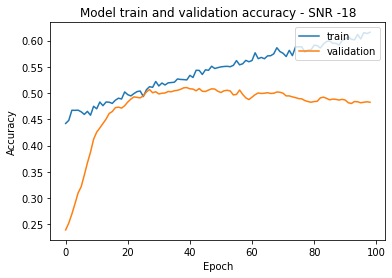

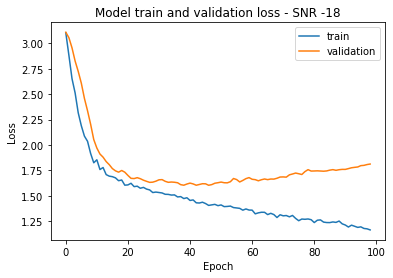

Score of SNR on High SNR model without Transfer Learning -18 = 6.759906560182571

Training SNR = -18 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 85ms/step - loss: 9.0205 - accuracy: 0.2858 - val_loss: 10.6505 - val_accuracy: 0.0900
Epoch 2/200
7/7 [==============================] - 1s 74ms/step - loss: 8.1220 - accuracy: 0.3102 - val_loss: 8.5739 - val_accuracy: 0.1166
Epoch 3/200
7/7 [==============================] - 1s 75ms/step - loss: 7.5327 - accuracy: 0.3155 - val_loss: 7.1301 - val_accuracy: 0.1529
Epoch 4/200
7/7 [==============================] - 1s 76ms/step - loss: 6.9572 - accuracy: 0.3445 - val_loss: 6.2558 - val_accuracy: 0.1953
Epoch 5/200
7/7 [==============================] - 1s 77ms/step - loss: 6.4481 - accuracy: 0.3538 - val_loss: 5.7539 - val_accuracy: 0.2107
Epoch 6/200
7/7 [==============================] - 1s 77ms/step - loss: 6.1699 - accuracy: 0.3663 - val_loss: 5.5186 - val_accuracy: 0.2266
Epoch 7/200
7/7 [===

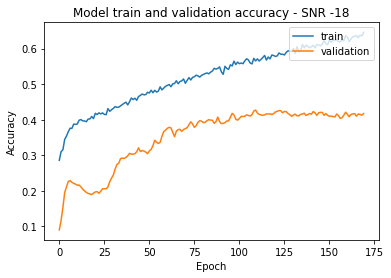

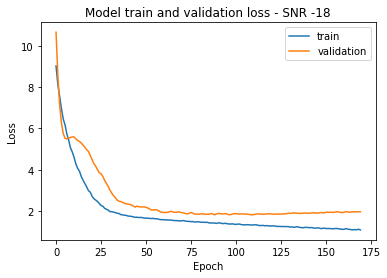

Score of SNR on low SNR model without Transfer Learning -18 = 49.60373044013977

Training SNR = -18 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 2s 87ms/step - loss: 2.5618 - accuracy: 0.4810 - val_loss: 1.8795 - val_accuracy: 0.4732
Epoch 2/200
7/7 [==============================] - 1s 76ms/step - loss: 2.3431 - accuracy: 0.4824 - val_loss: 2.1139 - val_accuracy: 0.4368
Epoch 3/200
7/7 [==============================] - 1s 76ms/step - loss: 2.2081 - accuracy: 0.4861 - val_loss: 2.2155 - val_accuracy: 0.4163
Epoch 4/200
7/7 [==============================] - 1s 78ms/step - loss: 2.1075 - accuracy: 0.4853 - val_loss: 2.1209 - val_accuracy: 0.4312
Epoch 5/200
7/7 [==============================] - 1s 76ms/step - loss: 1.9895 - accuracy: 0.4869 - val_loss: 1.9604 - val_accuracy: 0.4629
Epoch 6/200
7/7 [==============================] - 1s 76ms/step - loss: 1.8812 - accuracy: 0.4929 - val_loss: 1.8156 - val_accuracy: 0.4862
Epoch 7/200
7/7 [======

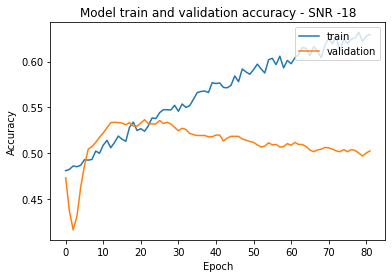

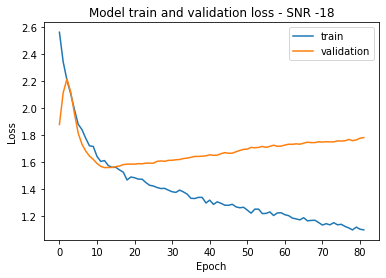

[[26.57342553]
 [42.51748323]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]] [[14.87179548 32.587412  ]
 [21.72494233 47.45920599]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 7.36596733 25.82750618]
 [ 6.75990656 39.95338082]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[35.19813418 34.21911299]
 [49.60373044 49.93006885]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]

Training SNR = -16 Data

Epoch 1/20

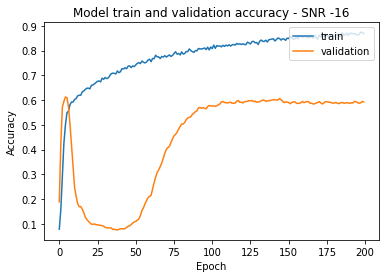

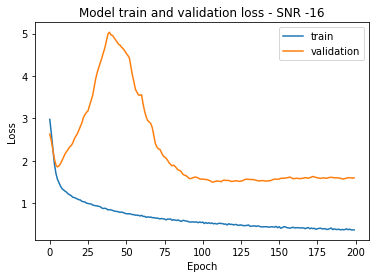


Score of SNR on All SNR model without Transfer Learning -16 = 42.983683943748474

Training SNR = -16 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 90ms/step - loss: 1.8447 - accuracy: 0.6166 - val_loss: 1.8860 - val_accuracy: 0.4350
Epoch 2/200
7/7 [==============================] - 1s 77ms/step - loss: 1.6523 - accuracy: 0.6219 - val_loss: 1.8350 - val_accuracy: 0.4555
Epoch 3/200
7/7 [==============================] - 1s 77ms/step - loss: 1.5296 - accuracy: 0.6329 - val_loss: 1.7636 - val_accuracy: 0.4821
Epoch 4/200
7/7 [==============================] - 1s 77ms/step - loss: 1.4731 - accuracy: 0.6342 - val_loss: 1.6976 - val_accuracy: 0.5012
Epoch 5/200
7/7 [==============================] - 1s 78ms/step - loss: 1.3644 - accuracy: 0.6413 - val_loss: 1.6294 - val_accuracy: 0.5226
Epoch 6/200
7/7 [==============================] - 1s 76ms/step - loss: 1.2916 - accuracy: 0.6454 - val_loss: 1.5206 - val_accuracy: 0.5487
Epoch 7/200
7/7 [====

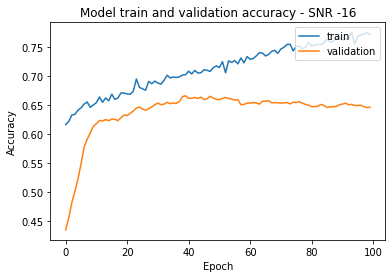

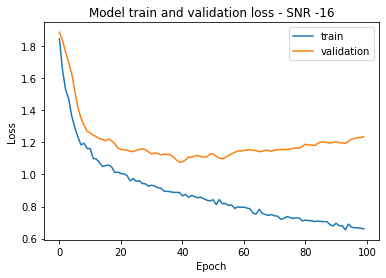

Score of SNR on High SNR model without Transfer Learning -16 = 8.764568716287613

Training SNR = -16 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 89ms/step - loss: 6.6104 - accuracy: 0.4126 - val_loss: 7.2267 - val_accuracy: 0.1585
Epoch 2/200
7/7 [==============================] - 1s 79ms/step - loss: 5.8014 - accuracy: 0.4559 - val_loss: 5.0526 - val_accuracy: 0.2601
Epoch 3/200
7/7 [==============================] - 1s 74ms/step - loss: 5.1448 - accuracy: 0.4831 - val_loss: 4.0977 - val_accuracy: 0.3263
Epoch 4/200
7/7 [==============================] - 1s 76ms/step - loss: 4.7453 - accuracy: 0.5072 - val_loss: 3.6565 - val_accuracy: 0.3907
Epoch 5/200
7/7 [==============================] - 1s 79ms/step - loss: 4.4184 - accuracy: 0.5214 - val_loss: 3.4297 - val_accuracy: 0.4145
Epoch 6/200
7/7 [==============================] - 1s 78ms/step - loss: 4.0637 - accuracy: 0.5364 - val_loss: 3.3671 - val_accuracy: 0.4266
Epoch 7/200
7/7 [====

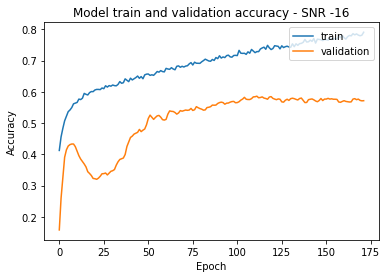

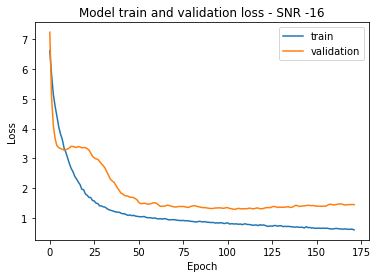

Score of SNR on low SNR model without Transfer Learning -16 = 72.02796936035156

Training SNR = -16 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 2s 86ms/step - loss: 1.3885 - accuracy: 0.6500 - val_loss: 0.9941 - val_accuracy: 0.6807
Epoch 2/200
7/7 [==============================] - 1s 79ms/step - loss: 1.2763 - accuracy: 0.6564 - val_loss: 1.1256 - val_accuracy: 0.6434
Epoch 3/200
7/7 [==============================] - 1s 75ms/step - loss: 1.2149 - accuracy: 0.6601 - val_loss: 1.1593 - val_accuracy: 0.6368
Epoch 4/200
7/7 [==============================] - 1s 80ms/step - loss: 1.1308 - accuracy: 0.6682 - val_loss: 1.1449 - val_accuracy: 0.6410
Epoch 5/200
7/7 [==============================] - 1s 75ms/step - loss: 1.1149 - accuracy: 0.6688 - val_loss: 1.0745 - val_accuracy: 0.6601
Epoch 6/200
7/7 [==============================] - 1s 74ms/step - loss: 1.0832 - accuracy: 0.6670 - val_loss: 1.0261 - val_accuracy: 0.6783
Epoch 7/200
7/7 [======

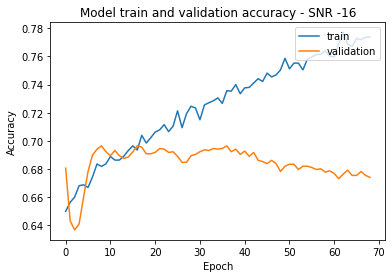

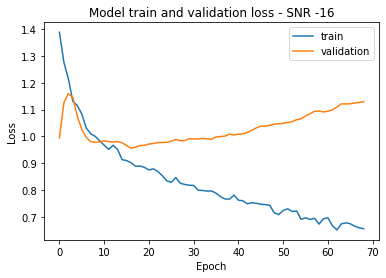

[[26.57342553]
 [42.51748323]
 [59.67366099]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]] [[14.87179548 32.587412  ]
 [21.72494233 47.45920599]
 [42.98368394 65.87412357]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 7.36596733 25.82750618]
 [ 6.75990656 39.95338082]
 [ 8.76456872 58.22843909]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[35.19813418 34.21911299]
 [49.60373044 49.93006885]
 [72.02796936 68.2051301 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]

Training SNR = -14 Data

Epoch 1/20

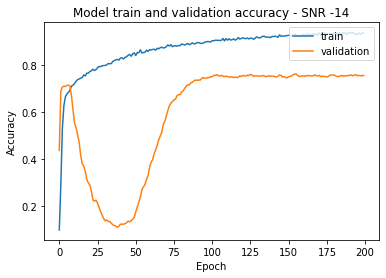

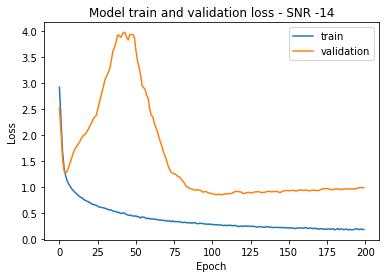


Score of SNR on All SNR model without Transfer Learning -14 = 66.57342910766602

Training SNR = -14 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 87ms/step - loss: 1.0759 - accuracy: 0.7336 - val_loss: 0.9525 - val_accuracy: 0.6471
Epoch 2/200
7/7 [==============================] - 1s 77ms/step - loss: 0.9514 - accuracy: 0.7472 - val_loss: 0.8887 - val_accuracy: 0.6783
Epoch 3/200
7/7 [==============================] - 1s 76ms/step - loss: 0.8604 - accuracy: 0.7521 - val_loss: 0.7753 - val_accuracy: 0.7161
Epoch 4/200
7/7 [==============================] - 1s 77ms/step - loss: 0.8170 - accuracy: 0.7542 - val_loss: 0.6704 - val_accuracy: 0.7492
Epoch 5/200
7/7 [==============================] - 1s 80ms/step - loss: 0.7478 - accuracy: 0.7671 - val_loss: 0.6087 - val_accuracy: 0.7683
Epoch 6/200
7/7 [==============================] - 1s 72ms/step - loss: 0.7227 - accuracy: 0.7660 - val_loss: 0.5756 - val_accuracy: 0.7786
Epoch 7/200
7/7 [=====

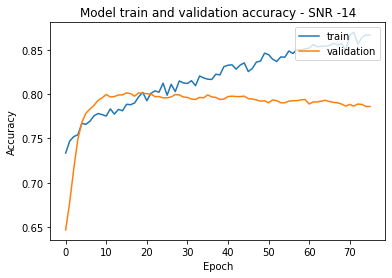

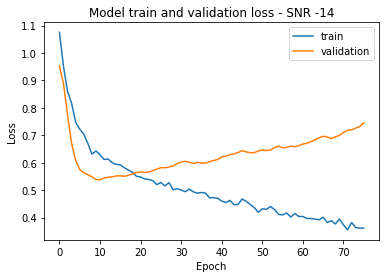

Score of SNR on High SNR model without Transfer Learning -14 = 12.634032964706421

Training SNR = -14 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 3s 93ms/step - loss: 4.4304 - accuracy: 0.5520 - val_loss: 5.0619 - val_accuracy: 0.2606
Epoch 2/200
7/7 [==============================] - 1s 78ms/step - loss: 3.8187 - accuracy: 0.6005 - val_loss: 3.3156 - val_accuracy: 0.4326
Epoch 3/200
7/7 [==============================] - 1s 80ms/step - loss: 3.3303 - accuracy: 0.6342 - val_loss: 2.5741 - val_accuracy: 0.5417
Epoch 4/200
7/7 [==============================] - 1s 77ms/step - loss: 3.0570 - accuracy: 0.6479 - val_loss: 2.2872 - val_accuracy: 0.5925
Epoch 5/200
7/7 [==============================] - 1s 75ms/step - loss: 2.7852 - accuracy: 0.6620 - val_loss: 2.1432 - val_accuracy: 0.6242
Epoch 6/200
7/7 [==============================] - 1s 77ms/step - loss: 2.6044 - accuracy: 0.6791 - val_loss: 2.0636 - val_accuracy: 0.6401
Epoch 7/200
7/7 [===

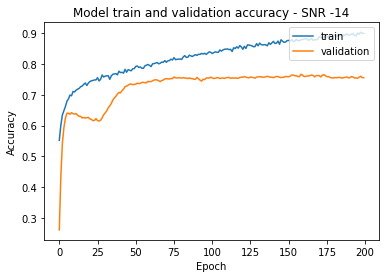

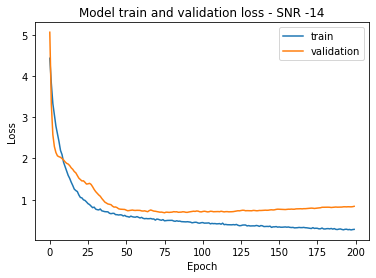

Score of SNR on low SNR model without Transfer Learning -14 = 82.19113945960999

Training SNR = -14 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 2s 86ms/step - loss: 0.8193 - accuracy: 0.7479 - val_loss: 0.4729 - val_accuracy: 0.8196
Epoch 2/200
7/7 [==============================] - 1s 84ms/step - loss: 0.7138 - accuracy: 0.7664 - val_loss: 0.5110 - val_accuracy: 0.8056
Epoch 3/200
7/7 [==============================] - 1s 75ms/step - loss: 0.6609 - accuracy: 0.7793 - val_loss: 0.5291 - val_accuracy: 0.8056
Epoch 4/200
7/7 [==============================] - 1s 77ms/step - loss: 0.6377 - accuracy: 0.7770 - val_loss: 0.5328 - val_accuracy: 0.8051
Epoch 5/200
7/7 [==============================] - 1s 74ms/step - loss: 0.6097 - accuracy: 0.7866 - val_loss: 0.5173 - val_accuracy: 0.8075
Epoch 6/200
7/7 [==============================] - 1s 76ms/step - loss: 0.5789 - accuracy: 0.7869 - val_loss: 0.4983 - val_accuracy: 0.8149
Epoch 7/200
7/7 [======

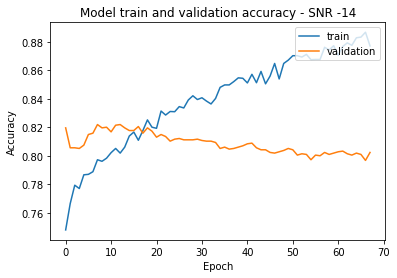

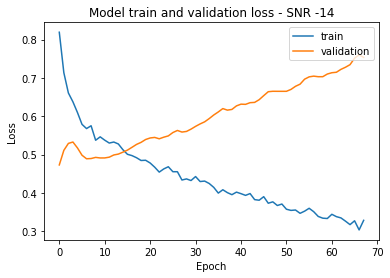

[[26.57342553]
 [42.51748323]
 [59.67366099]
 [72.96037078]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]] [[14.87179548 32.587412  ]
 [21.72494233 47.45920599]
 [42.98368394 65.87412357]
 [66.57342911 77.57575512]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 7.36596733 25.82750618]
 [ 6.75990656 39.95338082]
 [ 8.76456872 58.22843909]
 [12.63403296 74.07925129]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[35.19813418 34.21911299]
 [49.60373044 49.93006885]
 [72.02796936 68.2051301 ]
 [82.19113946 78.18182111]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]

Training SNR = -12 Data

Epoch 1/20

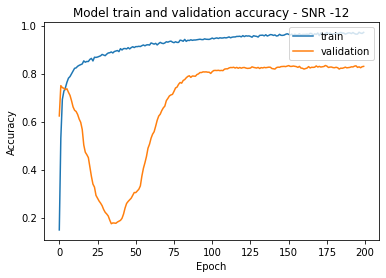

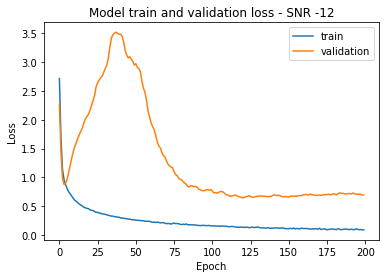


Score of SNR on All SNR model without Transfer Learning -12 = 84.42890644073486

Training SNR = -12 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 89ms/step - loss: 0.6697 - accuracy: 0.8099 - val_loss: 0.4548 - val_accuracy: 0.8378
Epoch 2/200
7/7 [==============================] - 1s 76ms/step - loss: 0.5600 - accuracy: 0.8306 - val_loss: 0.4611 - val_accuracy: 0.8354
Epoch 3/200
7/7 [==============================] - 1s 74ms/step - loss: 0.5005 - accuracy: 0.8367 - val_loss: 0.4248 - val_accuracy: 0.8480
Epoch 4/200
7/7 [==============================] - 1s 75ms/step - loss: 0.4526 - accuracy: 0.8426 - val_loss: 0.3905 - val_accuracy: 0.8573
Epoch 5/200
7/7 [==============================] - 1s 78ms/step - loss: 0.4408 - accuracy: 0.8452 - val_loss: 0.3685 - val_accuracy: 0.8643
Epoch 6/200
7/7 [==============================] - 1s 76ms/step - loss: 0.4084 - accuracy: 0.8510 - val_loss: 0.3594 - val_accuracy: 0.8671
Epoch 7/200
7/7 [=====

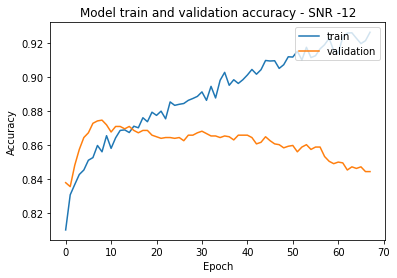

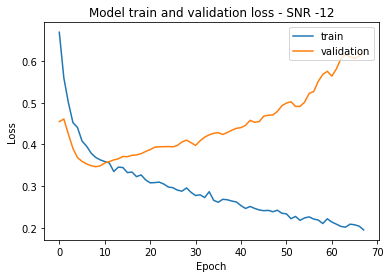

Score of SNR on High SNR model without Transfer Learning -12 = 26.0606050491333

Training SNR = -12 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 91ms/step - loss: 2.8334 - accuracy: 0.6904 - val_loss: 2.3758 - val_accuracy: 0.5394
Epoch 2/200
7/7 [==============================] - 1s 78ms/step - loss: 2.2780 - accuracy: 0.7263 - val_loss: 1.5761 - val_accuracy: 0.7049
Epoch 3/200
7/7 [==============================] - 1s 74ms/step - loss: 1.9589 - accuracy: 0.7608 - val_loss: 1.3944 - val_accuracy: 0.7441
Epoch 4/200
7/7 [==============================] - 1s 75ms/step - loss: 1.7331 - accuracy: 0.7716 - val_loss: 1.3199 - val_accuracy: 0.7636
Epoch 5/200
7/7 [==============================] - 1s 78ms/step - loss: 1.5350 - accuracy: 0.7832 - val_loss: 1.2699 - val_accuracy: 0.7730
Epoch 6/200
7/7 [==============================] - 1s 77ms/step - loss: 1.4411 - accuracy: 0.7935 - val_loss: 1.2427 - val_accuracy: 0.7828
Epoch 7/200
7/7 [=====

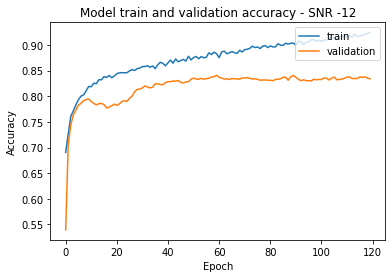

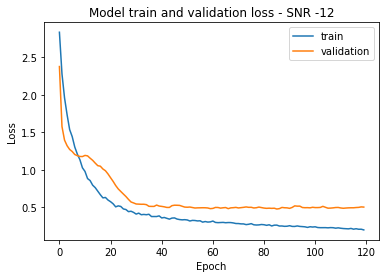

Score of SNR on low SNR model without Transfer Learning -12 = 87.08624839782715

Training SNR = -12 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 3s 86ms/step - loss: 0.5227 - accuracy: 0.8073 - val_loss: 0.3400 - val_accuracy: 0.8732
Epoch 2/200
7/7 [==============================] - 1s 78ms/step - loss: 0.4366 - accuracy: 0.8371 - val_loss: 0.3170 - val_accuracy: 0.8811
Epoch 3/200
7/7 [==============================] - 1s 79ms/step - loss: 0.3838 - accuracy: 0.8513 - val_loss: 0.3192 - val_accuracy: 0.8802
Epoch 4/200
7/7 [==============================] - 1s 80ms/step - loss: 0.3764 - accuracy: 0.8559 - val_loss: 0.3345 - val_accuracy: 0.8783
Epoch 5/200
7/7 [==============================] - 1s 77ms/step - loss: 0.3643 - accuracy: 0.8552 - val_loss: 0.3489 - val_accuracy: 0.8783
Epoch 6/200
7/7 [==============================] - 1s 78ms/step - loss: 0.3394 - accuracy: 0.8674 - val_loss: 0.3634 - val_accuracy: 0.8746
Epoch 7/200
7/7 [======

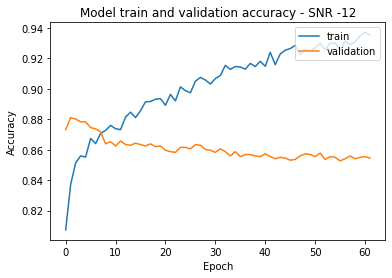

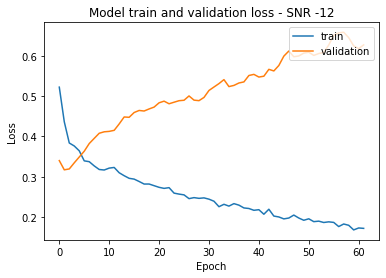

[[26.57342553]
 [42.51748323]
 [59.67366099]
 [72.96037078]
 [83.21678042]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]] [[14.87179548 32.587412  ]
 [21.72494233 47.45920599]
 [42.98368394 65.87412357]
 [66.57342911 77.57575512]
 [84.42890644 85.59440374]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 7.36596733 25.82750618]
 [ 6.75990656 39.95338082]
 [ 8.76456872 58.22843909]
 [12.63403296 74.07925129]
 [26.06060505 84.0093255 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[35.19813418 34.21911299]
 [49.60373044 49.93006885]
 [72.02796936 68.2051301 ]
 [82.19113946 78.18182111]
 [87.0862484  85.59440374]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]


In [ ]:
for i in range(0, 5):

  x_data_fft_curr = np.reshape(x_data_fft_data[:,i], (total_num_snapshots, x_dim[3], x_dim[4]))
  x_data_fft_curr = scaler_std.fit_transform(np.reshape(x_data_fft_curr, (total_num_snapshots, num_samples*2)))
  x_data_fft_curr = np.reshape(x_data_fft_curr, (total_num_snapshots, num_samples, 2))
  y_data_fft_curr = to_categorical(y_labels_data[:,i].flatten())

  X_train_curr, X_test_valid_curr, Y_train_curr, Y_test_valid_curr = train_test_split(x_data_fft_curr, y_data_fft_curr, test_size=0.4)
  X_validation_curr, X_test_curr, Y_validation_curr, Y_test_curr = train_test_split(X_test_valid_curr, Y_test_valid_curr, test_size=0.5)

  scores_without_tf_2d[i] = train_data(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, i)
  scores_tf_allsnr_2d[i] = train_data_on_all_snr_model(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, model_folder_all, i)
  scores_tf_highsnr_2d[i] = train_data_on_high_snr_model(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, model_folder_high, i)
  scores_tf_lowsnr_2d[i] = train_data_on_low_snr_model(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, model_folder_low, i)

  print(scores_without_tf_2d, scores_tf_allsnr_2d, scores_tf_highsnr_2d, scores_tf_lowsnr_2d)


Training SNR = -10 Data

Epoch 1/200
7/7 [==============================] - 3s 164ms/step - loss: 2.7998 - accuracy: 0.1342 - val_loss: 2.0637 - val_accuracy: 0.7179
Epoch 2/200
7/7 [==============================] - 1s 74ms/step - loss: 1.4344 - accuracy: 0.6498 - val_loss: 1.0490 - val_accuracy: 0.7650
Epoch 3/200
7/7 [==============================] - 1s 75ms/step - loss: 0.9596 - accuracy: 0.7396 - val_loss: 0.7783 - val_accuracy: 0.7655
Epoch 4/200
7/7 [==============================] - 1s 74ms/step - loss: 0.8134 - accuracy: 0.7643 - val_loss: 0.7284 - val_accuracy: 0.7599
Epoch 5/200
7/7 [==============================] - 1s 77ms/step - loss: 0.7179 - accuracy: 0.7860 - val_loss: 0.7562 - val_accuracy: 0.7655
Epoch 6/200
7/7 [==============================] - 1s 78ms/step - loss: 0.6642 - accuracy: 0.8004 - val_loss: 0.8382 - val_accuracy: 0.7571
Epoch 7/200
7/7 [==============================] - 1s 74ms/step - loss: 0.5916 - accuracy: 0.8349 - val_loss: 0.9599 - val_accuracy: 

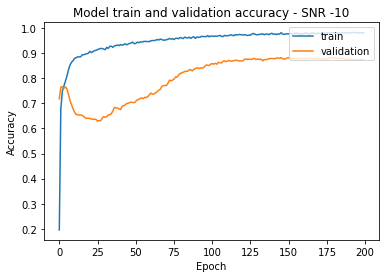

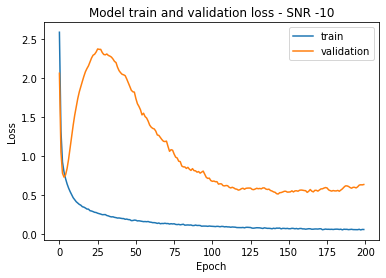


Score of SNR on All SNR model without Transfer Learning -10 = 90.3030276298523

Training SNR = -10 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 90ms/step - loss: 0.4237 - accuracy: 0.8592 - val_loss: 0.2766 - val_accuracy: 0.8923
Epoch 2/200
7/7 [==============================] - 1s 74ms/step - loss: 0.3555 - accuracy: 0.8765 - val_loss: 0.2805 - val_accuracy: 0.8914
Epoch 3/200
7/7 [==============================] - 1s 73ms/step - loss: 0.3181 - accuracy: 0.8813 - val_loss: 0.2688 - val_accuracy: 0.8979
Epoch 4/200
7/7 [==============================] - 1s 76ms/step - loss: 0.2844 - accuracy: 0.8936 - val_loss: 0.2633 - val_accuracy: 0.9021
Epoch 5/200
7/7 [==============================] - 1s 74ms/step - loss: 0.2787 - accuracy: 0.8925 - val_loss: 0.2593 - val_accuracy: 0.9049
Epoch 6/200
7/7 [==============================] - 1s 74ms/step - loss: 0.2611 - accuracy: 0.8996 - val_loss: 0.2597 - val_accuracy: 0.9026
Epoch 7/200
7/7 [======

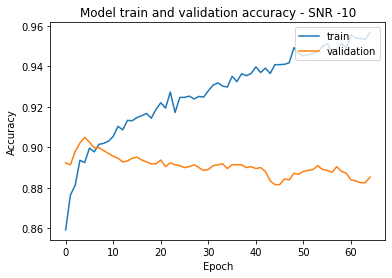

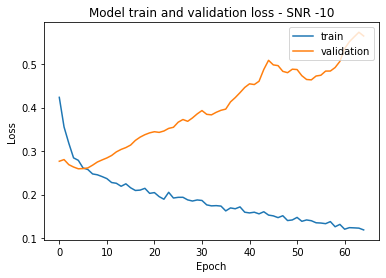

Score of SNR on High SNR model without Transfer Learning -10 = 54.91841435432434

Training SNR = -10 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 83ms/step - loss: 1.5211 - accuracy: 0.8070 - val_loss: 1.0143 - val_accuracy: 0.7646
Epoch 2/200
7/7 [==============================] - 1s 76ms/step - loss: 1.2433 - accuracy: 0.8300 - val_loss: 0.8197 - val_accuracy: 0.8336
Epoch 3/200
7/7 [==============================] - 1s 76ms/step - loss: 1.0225 - accuracy: 0.8469 - val_loss: 0.8035 - val_accuracy: 0.8471
Epoch 4/200
7/7 [==============================] - 1s 73ms/step - loss: 0.8965 - accuracy: 0.8553 - val_loss: 0.8034 - val_accuracy: 0.8569
Epoch 5/200
7/7 [==============================] - 1s 75ms/step - loss: 0.8250 - accuracy: 0.8618 - val_loss: 0.8119 - val_accuracy: 0.8569
Epoch 6/200
7/7 [==============================] - 1s 74ms/step - loss: 0.7272 - accuracy: 0.8720 - val_loss: 0.8369 - val_accuracy: 0.8564
Epoch 7/200
7/7 [====

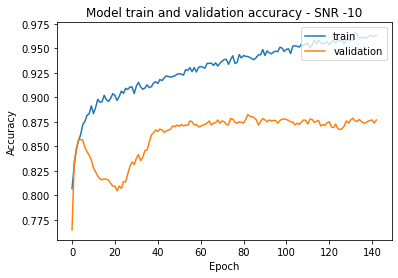

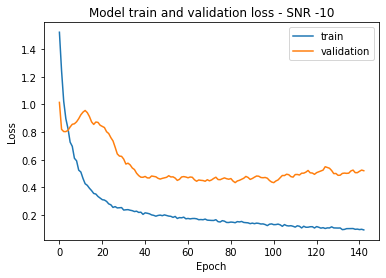

Score of SNR on low SNR model without Transfer Learning -10 = 87.08624839782715

Training SNR = -10 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 2s 92ms/step - loss: 0.3748 - accuracy: 0.8552 - val_loss: 0.2739 - val_accuracy: 0.8928
Epoch 2/200
7/7 [==============================] - 1s 80ms/step - loss: 0.3142 - accuracy: 0.8735 - val_loss: 0.2646 - val_accuracy: 0.8965
Epoch 3/200
7/7 [==============================] - 1s 77ms/step - loss: 0.2759 - accuracy: 0.8889 - val_loss: 0.2922 - val_accuracy: 0.8914
Epoch 4/200
7/7 [==============================] - 1s 74ms/step - loss: 0.2572 - accuracy: 0.8976 - val_loss: 0.3336 - val_accuracy: 0.8881
Epoch 5/200
7/7 [==============================] - 1s 77ms/step - loss: 0.2482 - accuracy: 0.9001 - val_loss: 0.3833 - val_accuracy: 0.8862
Epoch 6/200
7/7 [==============================] - 1s 78ms/step - loss: 0.2422 - accuracy: 0.9030 - val_loss: 0.4438 - val_accuracy: 0.8811
Epoch 7/200
7/7 [======

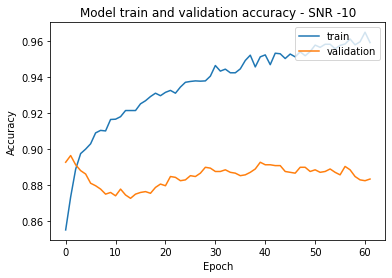

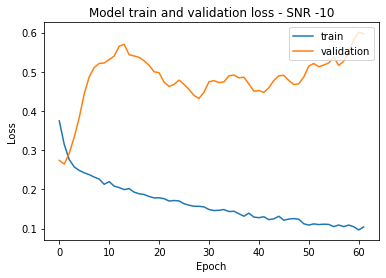

[[26.57342553]
 [42.51748323]
 [59.67366099]
 [72.96037078]
 [83.21678042]
 [86.71328425]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]] [[14.87179548 32.587412  ]
 [21.72494233 47.45920599]
 [42.98368394 65.87412357]
 [66.57342911 77.57575512]
 [84.42890644 85.59440374]
 [90.30302763 87.31935024]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 7.36596733 25.82750618]
 [ 6.75990656 39.95338082]
 [ 8.76456872 58.22843909]
 [12.63403296 74.07925129]
 [26.06060505 84.0093255 ]
 [54.91841435 86.66666746]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[35.19813418 34.21911299]
 [49.60373044 49.93006885]
 [72.02796936 68.2051301 ]
 [82.19113946 78.18182111]
 [87.0862484  85.59440374]
 [87.0862484  87.55244613]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]

Training SNR = -8 Data

Epoch 1/200

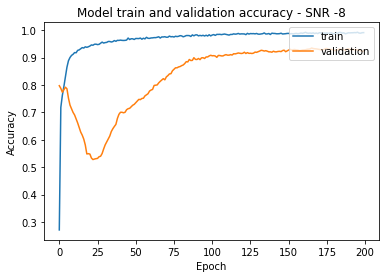

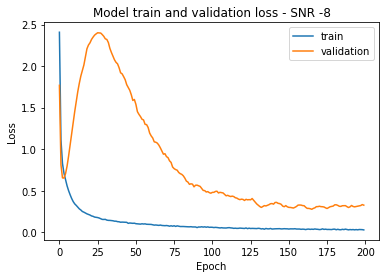


Score of SNR on All SNR model without Transfer Learning -8 = 93.75291466712952

Training SNR = -8 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 85ms/step - loss: 0.2741 - accuracy: 0.9001 - val_loss: 0.1939 - val_accuracy: 0.9226
Epoch 2/200
7/7 [==============================] - 1s 76ms/step - loss: 0.2299 - accuracy: 0.9113 - val_loss: 0.1845 - val_accuracy: 0.9273
Epoch 3/200
7/7 [==============================] - 1s 74ms/step - loss: 0.1956 - accuracy: 0.9231 - val_loss: 0.1724 - val_accuracy: 0.9338
Epoch 4/200
7/7 [==============================] - 1s 78ms/step - loss: 0.1800 - accuracy: 0.9312 - val_loss: 0.1792 - val_accuracy: 0.9375
Epoch 5/200
7/7 [==============================] - 1s 77ms/step - loss: 0.1738 - accuracy: 0.9329 - val_loss: 0.1849 - val_accuracy: 0.9371
Epoch 6/200
7/7 [==============================] - 1s 73ms/step - loss: 0.1685 - accuracy: 0.9327 - val_loss: 0.1910 - val_accuracy: 0.9375
Epoch 7/200
7/7 [=======

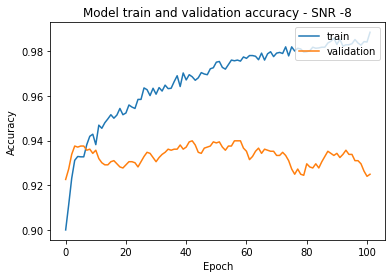

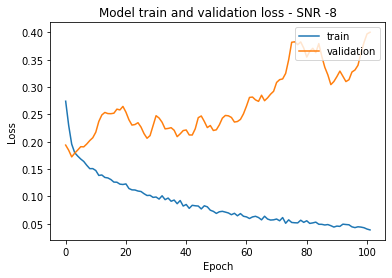

Score of SNR on High SNR model without Transfer Learning -8 = 83.82284641265869

Training SNR = -8 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 85ms/step - loss: 0.7684 - accuracy: 0.8808 - val_loss: 0.3923 - val_accuracy: 0.9166
Epoch 2/200
7/7 [==============================] - 1s 75ms/step - loss: 0.6004 - accuracy: 0.9041 - val_loss: 0.3708 - val_accuracy: 0.9235
Epoch 3/200
7/7 [==============================] - 1s 74ms/step - loss: 0.4943 - accuracy: 0.9141 - val_loss: 0.3972 - val_accuracy: 0.9226
Epoch 4/200
7/7 [==============================] - 1s 78ms/step - loss: 0.4251 - accuracy: 0.9212 - val_loss: 0.4475 - val_accuracy: 0.9175
Epoch 5/200
7/7 [==============================] - 1s 79ms/step - loss: 0.3871 - accuracy: 0.9259 - val_loss: 0.4728 - val_accuracy: 0.9091
Epoch 6/200
7/7 [==============================] - 1s 75ms/step - loss: 0.3626 - accuracy: 0.9240 - val_loss: 0.5014 - val_accuracy: 0.9049
Epoch 7/200
7/7 [======

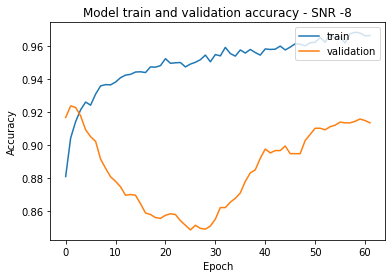

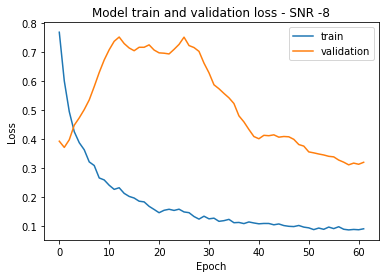

Score of SNR on low SNR model without Transfer Learning -8 = 89.13753032684326

Training SNR = -8 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 2s 85ms/step - loss: 0.3170 - accuracy: 0.8755 - val_loss: 0.1976 - val_accuracy: 0.9207
Epoch 2/200
7/7 [==============================] - 1s 74ms/step - loss: 0.2449 - accuracy: 0.9064 - val_loss: 0.1890 - val_accuracy: 0.9259
Epoch 3/200
7/7 [==============================] - 1s 77ms/step - loss: 0.2057 - accuracy: 0.9195 - val_loss: 0.2347 - val_accuracy: 0.9245
Epoch 4/200
7/7 [==============================] - 1s 79ms/step - loss: 0.1836 - accuracy: 0.9335 - val_loss: 0.3097 - val_accuracy: 0.9221
Epoch 5/200
7/7 [==============================] - 1s 79ms/step - loss: 0.1748 - accuracy: 0.9340 - val_loss: 0.4046 - val_accuracy: 0.9179
Epoch 6/200
7/7 [==============================] - 1s 81ms/step - loss: 0.1672 - accuracy: 0.9406 - val_loss: 0.4822 - val_accuracy: 0.9170
Epoch 7/200
7/7 [========

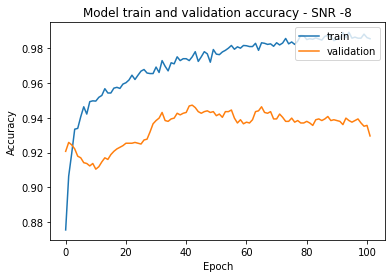

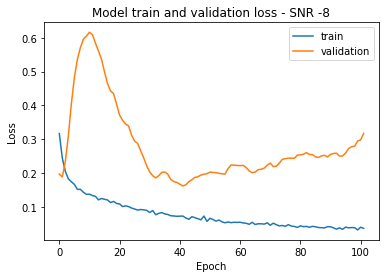

[[26.57342553]
 [42.51748323]
 [59.67366099]
 [72.96037078]
 [83.21678042]
 [86.71328425]
 [92.49417186]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]] [[14.87179548 32.587412  ]
 [21.72494233 47.45920599]
 [42.98368394 65.87412357]
 [66.57342911 77.57575512]
 [84.42890644 85.59440374]
 [90.30302763 87.31935024]
 [93.75291467 91.84148908]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 7.36596733 25.82750618]
 [ 6.75990656 39.95338082]
 [ 8.76456872 58.22843909]
 [12.63403296 74.07925129]
 [26.06060505 84.0093255 ]
 [54.91841435 86.66666746]
 [83.82284641 90.53612947]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[35.19813418 34.21911299]
 [49.60373044 49.93006885]
 [72.02796936 68.2051301 ]
 [82.19113946 78.18182111]
 [87.0862484  85.59440374]
 [87.0862484  87.55244613]
 [89.13753033 92.63403416]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]

Training SNR = -6 Data

Epoch 1/200

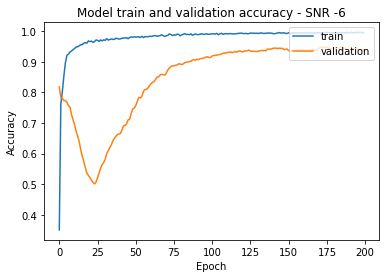

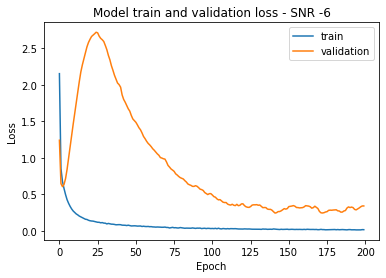


Score of SNR on All SNR model without Transfer Learning -6 = 95.66433429718018

Training SNR = -6 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 88ms/step - loss: 0.1787 - accuracy: 0.9329 - val_loss: 0.1513 - val_accuracy: 0.9436
Epoch 2/200
7/7 [==============================] - 1s 83ms/step - loss: 0.1366 - accuracy: 0.9447 - val_loss: 0.1502 - val_accuracy: 0.9473
Epoch 3/200
7/7 [==============================] - 1s 78ms/step - loss: 0.1236 - accuracy: 0.9531 - val_loss: 0.1685 - val_accuracy: 0.9464
Epoch 4/200
7/7 [==============================] - 1s 78ms/step - loss: 0.1200 - accuracy: 0.9552 - val_loss: 0.1997 - val_accuracy: 0.9417
Epoch 5/200
7/7 [==============================] - 1s 80ms/step - loss: 0.1163 - accuracy: 0.9563 - val_loss: 0.2298 - val_accuracy: 0.9389
Epoch 6/200
7/7 [==============================] - 1s 76ms/step - loss: 0.1067 - accuracy: 0.9608 - val_loss: 0.2586 - val_accuracy: 0.9357
Epoch 7/200
7/7 [=======

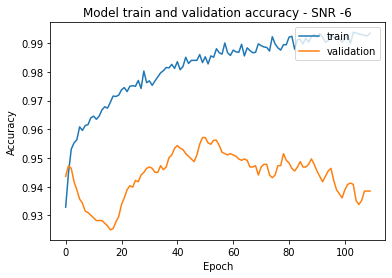

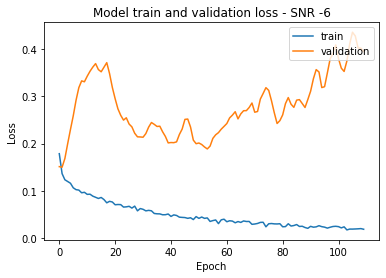

Score of SNR on High SNR model without Transfer Learning -6 = 95.01165747642517

Training SNR = -6 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 86ms/step - loss: 0.3446 - accuracy: 0.9352 - val_loss: 0.1871 - val_accuracy: 0.9534
Epoch 2/200
7/7 [==============================] - 1s 79ms/step - loss: 0.2550 - accuracy: 0.9490 - val_loss: 0.2015 - val_accuracy: 0.9520
Epoch 3/200
7/7 [==============================] - 1s 76ms/step - loss: 0.2166 - accuracy: 0.9534 - val_loss: 0.2149 - val_accuracy: 0.9506
Epoch 4/200
7/7 [==============================] - 1s 76ms/step - loss: 0.1709 - accuracy: 0.9615 - val_loss: 0.2326 - val_accuracy: 0.9529
Epoch 5/200
7/7 [==============================] - 1s 80ms/step - loss: 0.1655 - accuracy: 0.9598 - val_loss: 0.2697 - val_accuracy: 0.9441
Epoch 6/200
7/7 [==============================] - 1s 75ms/step - loss: 0.1429 - accuracy: 0.9633 - val_loss: 0.3071 - val_accuracy: 0.9366
Epoch 7/200
7/7 [======

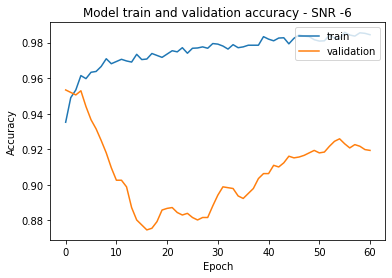

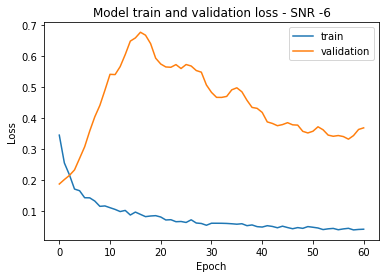

Score of SNR on low SNR model without Transfer Learning -6 = 91.14218950271606

Training SNR = -6 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 2s 89ms/step - loss: 0.2661 - accuracy: 0.9074 - val_loss: 0.1752 - val_accuracy: 0.9268
Epoch 2/200
7/7 [==============================] - 1s 77ms/step - loss: 0.1964 - accuracy: 0.9313 - val_loss: 0.2007 - val_accuracy: 0.9277
Epoch 3/200
7/7 [==============================] - 1s 76ms/step - loss: 0.1617 - accuracy: 0.9422 - val_loss: 0.2929 - val_accuracy: 0.9184
Epoch 4/200
7/7 [==============================] - 1s 75ms/step - loss: 0.1404 - accuracy: 0.9523 - val_loss: 0.4226 - val_accuracy: 0.9170
Epoch 5/200
7/7 [==============================] - 1s 75ms/step - loss: 0.1306 - accuracy: 0.9551 - val_loss: 0.5492 - val_accuracy: 0.9156
Epoch 6/200
7/7 [==============================] - 1s 76ms/step - loss: 0.1212 - accuracy: 0.9580 - val_loss: 0.6507 - val_accuracy: 0.9166
Epoch 7/200
7/7 [========

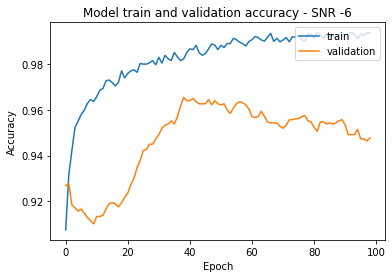

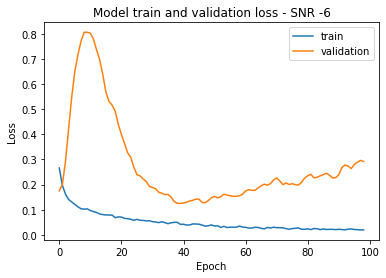

[[26.57342553]
 [42.51748323]
 [59.67366099]
 [72.96037078]
 [83.21678042]
 [86.71328425]
 [92.49417186]
 [94.40559149]
 [ 0.        ]
 [ 0.        ]] [[14.87179548 32.587412  ]
 [21.72494233 47.45920599]
 [42.98368394 65.87412357]
 [66.57342911 77.57575512]
 [84.42890644 85.59440374]
 [90.30302763 87.31935024]
 [93.75291467 91.84148908]
 [95.6643343  94.63869333]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 7.36596733 25.82750618]
 [ 6.75990656 39.95338082]
 [ 8.76456872 58.22843909]
 [12.63403296 74.07925129]
 [26.06060505 84.0093255 ]
 [54.91841435 86.66666746]
 [83.82284641 90.53612947]
 [95.01165748 92.02797413]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[35.19813418 34.21911299]
 [49.60373044 49.93006885]
 [72.02796936 68.2051301 ]
 [82.19113946 78.18182111]
 [87.0862484  85.59440374]
 [87.0862484  87.55244613]
 [89.13753033 92.63403416]
 [91.1421895  95.85081339]
 [ 0.          0.        ]
 [ 0.          0.        ]]

Training SNR = -4 Data

Epoch 1/200

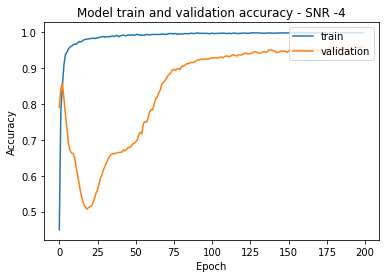

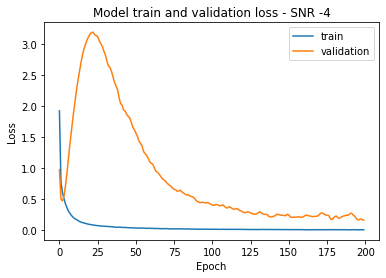


Score of SNR on All SNR model without Transfer Learning -4 = 96.82983756065369

Training SNR = -4 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 87ms/step - loss: 0.1245 - accuracy: 0.9546 - val_loss: 0.0901 - val_accuracy: 0.9706
Epoch 2/200
7/7 [==============================] - 1s 77ms/step - loss: 0.0879 - accuracy: 0.9681 - val_loss: 0.0945 - val_accuracy: 0.9692
Epoch 3/200
7/7 [==============================] - 1s 75ms/step - loss: 0.0745 - accuracy: 0.9726 - val_loss: 0.1445 - val_accuracy: 0.9548
Epoch 4/200
7/7 [==============================] - 1s 79ms/step - loss: 0.0699 - accuracy: 0.9739 - val_loss: 0.2048 - val_accuracy: 0.9431
Epoch 5/200
7/7 [==============================] - 1s 75ms/step - loss: 0.0604 - accuracy: 0.9775 - val_loss: 0.2681 - val_accuracy: 0.9361
Epoch 6/200
7/7 [==============================] - 1s 76ms/step - loss: 0.0572 - accuracy: 0.9807 - val_loss: 0.3218 - val_accuracy: 0.9329
Epoch 7/200
7/7 [=======

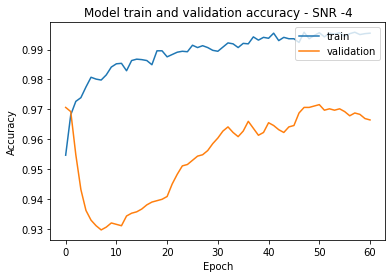

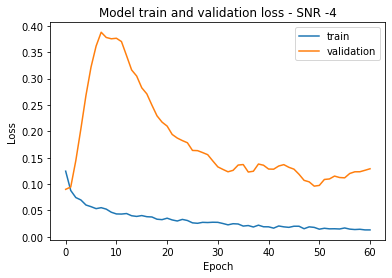

Score of SNR on High SNR model without Transfer Learning -4 = 97.94871807098389

Training SNR = -4 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 88ms/step - loss: 0.1038 - accuracy: 0.9747 - val_loss: 0.0654 - val_accuracy: 0.9800
Epoch 2/200
7/7 [==============================] - 1s 79ms/step - loss: 0.0770 - accuracy: 0.9828 - val_loss: 0.1060 - val_accuracy: 0.9706
Epoch 3/200
7/7 [==============================] - 1s 78ms/step - loss: 0.0728 - accuracy: 0.9821 - val_loss: 0.1436 - val_accuracy: 0.9632
Epoch 4/200
7/7 [==============================] - 1s 80ms/step - loss: 0.0605 - accuracy: 0.9841 - val_loss: 0.1780 - val_accuracy: 0.9576
Epoch 5/200
7/7 [==============================] - 1s 77ms/step - loss: 0.0611 - accuracy: 0.9860 - val_loss: 0.1944 - val_accuracy: 0.9552
Epoch 6/200
7/7 [==============================] - 1s 76ms/step - loss: 0.0493 - accuracy: 0.9873 - val_loss: 0.2155 - val_accuracy: 0.9501
Epoch 7/200
7/7 [======

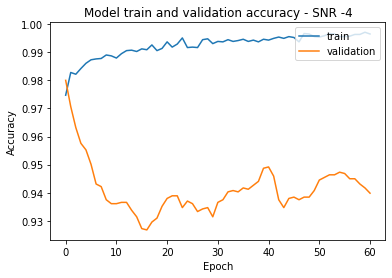

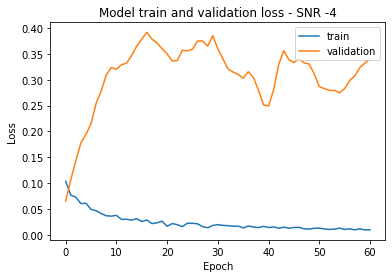

Score of SNR on low SNR model without Transfer Learning -4 = 91.00233316421509

Training SNR = -4 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 2s 86ms/step - loss: 0.2369 - accuracy: 0.9186 - val_loss: 0.1300 - val_accuracy: 0.9483
Epoch 2/200
7/7 [==============================] - 1s 80ms/step - loss: 0.1638 - accuracy: 0.9425 - val_loss: 0.1831 - val_accuracy: 0.9375
Epoch 3/200
7/7 [==============================] - 1s 78ms/step - loss: 0.1234 - accuracy: 0.9616 - val_loss: 0.2803 - val_accuracy: 0.9310
Epoch 4/200
7/7 [==============================] - 1s 77ms/step - loss: 0.1007 - accuracy: 0.9686 - val_loss: 0.4108 - val_accuracy: 0.9287
Epoch 5/200
7/7 [==============================] - 1s 78ms/step - loss: 0.0902 - accuracy: 0.9711 - val_loss: 0.5441 - val_accuracy: 0.9268
Epoch 6/200
7/7 [==============================] - 1s 80ms/step - loss: 0.0801 - accuracy: 0.9739 - val_loss: 0.6390 - val_accuracy: 0.9254
Epoch 7/200
7/7 [========

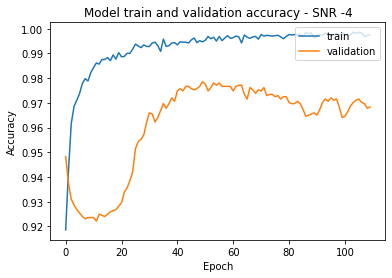

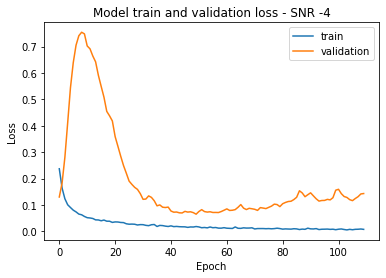

[[26.57342553]
 [42.51748323]
 [59.67366099]
 [72.96037078]
 [83.21678042]
 [86.71328425]
 [92.49417186]
 [94.40559149]
 [96.41025662]
 [ 0.        ]] [[14.87179548 32.587412  ]
 [21.72494233 47.45920599]
 [42.98368394 65.87412357]
 [66.57342911 77.57575512]
 [84.42890644 85.59440374]
 [90.30302763 87.31935024]
 [93.75291467 91.84148908]
 [95.6643343  94.63869333]
 [96.82983756 96.92307711]
 [ 0.          0.        ]] [[ 7.36596733 25.82750618]
 [ 6.75990656 39.95338082]
 [ 8.76456872 58.22843909]
 [12.63403296 74.07925129]
 [26.06060505 84.0093255 ]
 [54.91841435 86.66666746]
 [83.82284641 90.53612947]
 [95.01165748 92.02797413]
 [97.94871807 94.12587285]
 [ 0.          0.        ]] [[35.19813418 34.21911299]
 [49.60373044 49.93006885]
 [72.02796936 68.2051301 ]
 [82.19113946 78.18182111]
 [87.0862484  85.59440374]
 [87.0862484  87.55244613]
 [89.13753033 92.63403416]
 [91.1421895  95.85081339]
 [91.00233316 96.96969986]
 [ 0.          0.        ]]

Training SNR = -2 Data

Epoch 1/200

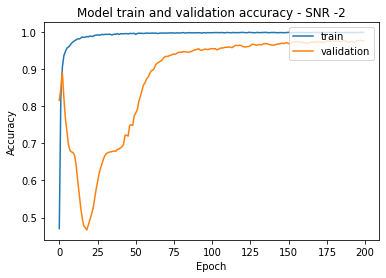

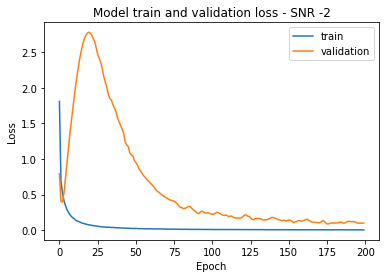


Score of SNR on All SNR model without Transfer Learning -2 = 97.71561622619629

Training SNR = -2 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 87ms/step - loss: 0.0900 - accuracy: 0.9734 - val_loss: 0.0303 - val_accuracy: 0.9874
Epoch 2/200
7/7 [==============================] - 1s 76ms/step - loss: 0.0530 - accuracy: 0.9826 - val_loss: 0.0443 - val_accuracy: 0.9832
Epoch 3/200
7/7 [==============================] - 1s 75ms/step - loss: 0.0424 - accuracy: 0.9862 - val_loss: 0.0860 - val_accuracy: 0.9716
Epoch 4/200
7/7 [==============================] - 1s 76ms/step - loss: 0.0334 - accuracy: 0.9887 - val_loss: 0.1338 - val_accuracy: 0.9594
Epoch 5/200
7/7 [==============================] - 1s 75ms/step - loss: 0.0319 - accuracy: 0.9897 - val_loss: 0.1681 - val_accuracy: 0.9548
Epoch 6/200
7/7 [==============================] - 1s 74ms/step - loss: 0.0259 - accuracy: 0.9921 - val_loss: 0.1978 - val_accuracy: 0.9529
Epoch 7/200
7/7 [=======

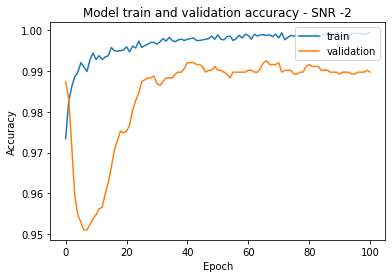

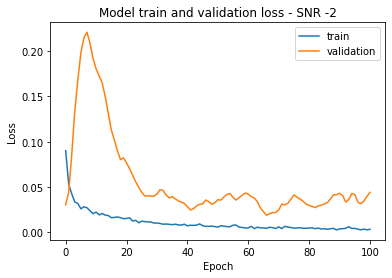

Score of SNR on High SNR model without Transfer Learning -2 = 98.83449673652649

Training SNR = -2 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 89ms/step - loss: 0.0273 - accuracy: 0.9929 - val_loss: 0.0122 - val_accuracy: 0.9963
Epoch 2/200
7/7 [==============================] - 1s 75ms/step - loss: 0.0171 - accuracy: 0.9947 - val_loss: 0.0138 - val_accuracy: 0.9953
Epoch 3/200
7/7 [==============================] - 1s 76ms/step - loss: 0.0186 - accuracy: 0.9943 - val_loss: 0.0156 - val_accuracy: 0.9953
Epoch 4/200
7/7 [==============================] - 1s 77ms/step - loss: 0.0177 - accuracy: 0.9944 - val_loss: 0.0161 - val_accuracy: 0.9953
Epoch 5/200
7/7 [==============================] - 1s 77ms/step - loss: 0.0117 - accuracy: 0.9961 - val_loss: 0.0173 - val_accuracy: 0.9944
Epoch 6/200
7/7 [==============================] - 1s 80ms/step - loss: 0.0130 - accuracy: 0.9960 - val_loss: 0.0225 - val_accuracy: 0.9921
Epoch 7/200
7/7 [======

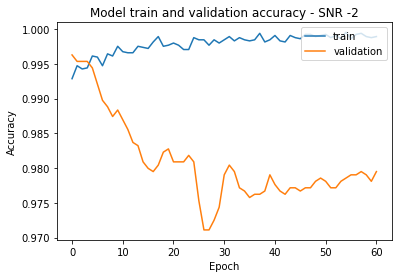

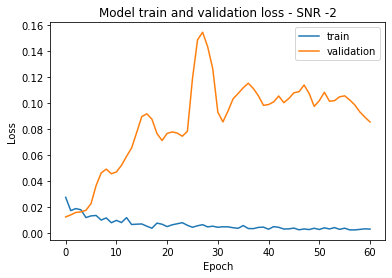

Score of SNR on low SNR model without Transfer Learning -2 = 92.49417185783386

Training SNR = -2 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 2s 86ms/step - loss: 0.2289 - accuracy: 0.9296 - val_loss: 0.0833 - val_accuracy: 0.9646
Epoch 2/200
7/7 [==============================] - 1s 77ms/step - loss: 0.1500 - accuracy: 0.9552 - val_loss: 0.1162 - val_accuracy: 0.9566
Epoch 3/200
7/7 [==============================] - 1s 78ms/step - loss: 0.1013 - accuracy: 0.9753 - val_loss: 0.1953 - val_accuracy: 0.9487
Epoch 4/200
7/7 [==============================] - 1s 79ms/step - loss: 0.0789 - accuracy: 0.9807 - val_loss: 0.2999 - val_accuracy: 0.9473
Epoch 5/200
7/7 [==============================] - 1s 79ms/step - loss: 0.0656 - accuracy: 0.9843 - val_loss: 0.3902 - val_accuracy: 0.9469
Epoch 6/200
7/7 [==============================] - 1s 77ms/step - loss: 0.0548 - accuracy: 0.9859 - val_loss: 0.4420 - val_accuracy: 0.9464
Epoch 7/200
7/7 [========

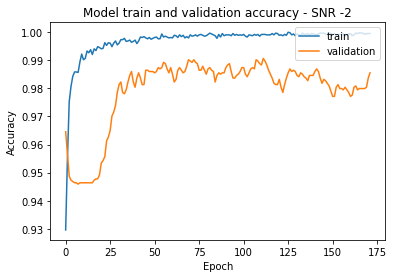

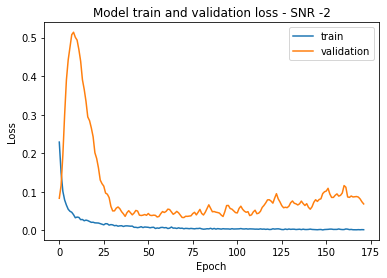

[[26.57342553]
 [42.51748323]
 [59.67366099]
 [72.96037078]
 [83.21678042]
 [86.71328425]
 [92.49417186]
 [94.40559149]
 [96.41025662]
 [96.96969986]] [[14.87179548 32.587412  ]
 [21.72494233 47.45920599]
 [42.98368394 65.87412357]
 [66.57342911 77.57575512]
 [84.42890644 85.59440374]
 [90.30302763 87.31935024]
 [93.75291467 91.84148908]
 [95.6643343  94.63869333]
 [96.82983756 96.92307711]
 [97.71561623 98.22843671]] [[ 7.36596733 25.82750618]
 [ 6.75990656 39.95338082]
 [ 8.76456872 58.22843909]
 [12.63403296 74.07925129]
 [26.06060505 84.0093255 ]
 [54.91841435 86.66666746]
 [83.82284641 90.53612947]
 [95.01165748 92.02797413]
 [97.94871807 94.12587285]
 [98.83449674 97.57575989]] [[35.19813418 34.21911299]
 [49.60373044 49.93006885]
 [72.02796936 68.2051301 ]
 [82.19113946 78.18182111]
 [87.0862484  85.59440374]
 [87.0862484  87.55244613]
 [89.13753033 92.63403416]
 [91.1421895  95.85081339]
 [91.00233316 96.96969986]
 [92.49417186 97.76223898]]


In [ ]:
for i in range(5, 10):

  x_data_fft_curr = np.reshape(x_data_fft_data[:,i], (total_num_snapshots, x_dim[3], x_dim[4]))
  x_data_fft_curr = scaler_std.fit_transform(np.reshape(x_data_fft_curr, (total_num_snapshots, num_samples*2)))
  x_data_fft_curr = np.reshape(x_data_fft_curr, (total_num_snapshots, num_samples, 2))
  y_data_fft_curr = to_categorical(y_labels_data[:,i].flatten())

  X_train_curr, X_test_valid_curr, Y_train_curr, Y_test_valid_curr = train_test_split(x_data_fft_curr, y_data_fft_curr, test_size=0.4)
  X_validation_curr, X_test_curr, Y_validation_curr, Y_test_curr = train_test_split(X_test_valid_curr, Y_test_valid_curr, test_size=0.5)

  scores_without_tf_2d[i] = train_data(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, i)
  scores_tf_allsnr_2d[i] = train_data_on_all_snr_model(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, model_folder_all, i)
  scores_tf_highsnr_2d[i] = train_data_on_high_snr_model(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, model_folder_high, i)
  scores_tf_lowsnr_2d[i] = train_data_on_low_snr_model(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, model_folder_low, i)

  print(scores_without_tf_2d, scores_tf_allsnr_2d, scores_tf_highsnr_2d, scores_tf_lowsnr_2d)

## FFT Amplitude

In [22]:
scores_without_tf_abs = np.zeros(shape=(10,2))
scores_tf_allsnr_abs = np.zeros(shape=(10,2))
scores_tf_highsnr_abs = np.zeros(shape=(10,2))
scores_tf_lowsnr_abs = np.zeros(shape=(10,2))

In [23]:
model_folder_all = "/gdrive/My Drive/Trained Models/fft/fft_abs_allSNR.tf"
model_folder_high = "/gdrive/My Drive/Trained Models/fft/fft_abs_highSNR.tf"
model_folder_low = "/gdrive/My Drive/Trained Models/fft/fft_abs_lowSNR.tf"


Training SNR = -20 Data

Epoch 1/200
7/7 [==============================] - 47s 204ms/step - loss: 3.0950 - accuracy: 0.0674 - val_loss: 2.6939 - val_accuracy: 0.1469
Epoch 2/200
7/7 [==============================] - 1s 76ms/step - loss: 2.8354 - accuracy: 0.1099 - val_loss: 2.6711 - val_accuracy: 0.2317
Epoch 3/200
7/7 [==============================] - 1s 76ms/step - loss: 2.5448 - accuracy: 0.1930 - val_loss: 2.6496 - val_accuracy: 0.2452
Epoch 4/200
7/7 [==============================] - 0s 72ms/step - loss: 2.3484 - accuracy: 0.2676 - val_loss: 2.6503 - val_accuracy: 0.1599
Epoch 5/200
7/7 [==============================] - 1s 73ms/step - loss: 2.2216 - accuracy: 0.3102 - val_loss: 2.6616 - val_accuracy: 0.0853
Epoch 6/200
7/7 [==============================] - 1s 74ms/step - loss: 2.1659 - accuracy: 0.3276 - val_loss: 2.6726 - val_accuracy: 0.0653
Epoch 7/200
7/7 [==============================] - 1s 76ms/step - loss: 2.1315 - accuracy: 0.3394 - val_loss: 2.6827 - val_accuracy:

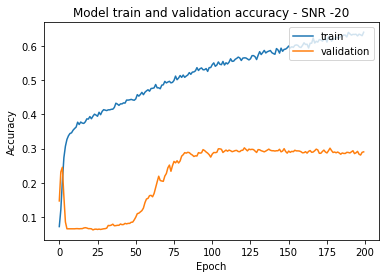

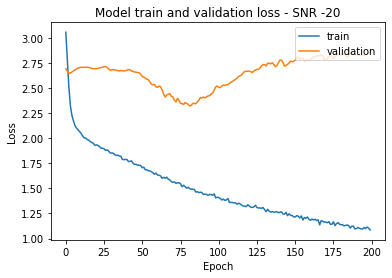


Score of SNR on All SNR model without Transfer Learning -20 = 39.48718011379242

Training SNR = -20 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 89ms/step - loss: 4.8151 - accuracy: 0.3237 - val_loss: 1.9990 - val_accuracy: 0.3776
Epoch 2/200
7/7 [==============================] - 1s 74ms/step - loss: 4.3072 - accuracy: 0.3235 - val_loss: 2.0247 - val_accuracy: 0.3790
Epoch 3/200
7/7 [==============================] - 1s 75ms/step - loss: 3.8418 - accuracy: 0.3207 - val_loss: 2.0485 - val_accuracy: 0.3762
Epoch 4/200
7/7 [==============================] - 1s 75ms/step - loss: 3.5312 - accuracy: 0.3116 - val_loss: 2.0483 - val_accuracy: 0.3702
Epoch 5/200
7/7 [==============================] - 1s 75ms/step - loss: 3.2412 - accuracy: 0.3068 - val_loss: 2.0311 - val_accuracy: 0.3566
Epoch 6/200
7/7 [==============================] - 1s 75ms/step - loss: 3.0149 - accuracy: 0.3037 - val_loss: 2.0258 - val_accuracy: 0.3566
Epoch 7/200
7/7 [=====

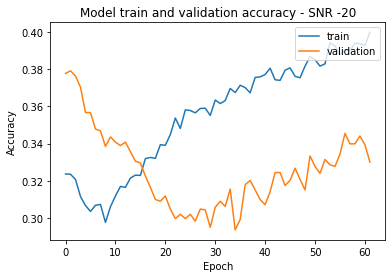

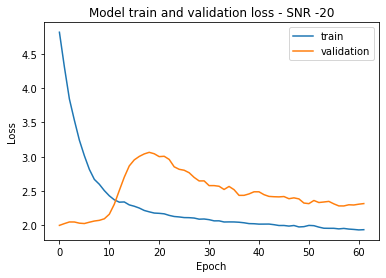

Score of SNR on High SNR model without Transfer Learning -20 = 6.060606241226196

Training SNR = -20 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 3s 89ms/step - loss: 7.0660 - accuracy: 0.2325 - val_loss: 26.6517 - val_accuracy: 0.0643
Epoch 2/200
7/7 [==============================] - 1s 74ms/step - loss: 6.4770 - accuracy: 0.2505 - val_loss: 25.3780 - val_accuracy: 0.0643
Epoch 3/200
7/7 [==============================] - 1s 76ms/step - loss: 6.0018 - accuracy: 0.2651 - val_loss: 24.1696 - val_accuracy: 0.0643
Epoch 4/200
7/7 [==============================] - 1s 75ms/step - loss: 5.5722 - accuracy: 0.2629 - val_loss: 22.8969 - val_accuracy: 0.0643
Epoch 5/200
7/7 [==============================] - 1s 76ms/step - loss: 5.2449 - accuracy: 0.2695 - val_loss: 22.2064 - val_accuracy: 0.0643
Epoch 6/200
7/7 [==============================] - 1s 79ms/step - loss: 4.9012 - accuracy: 0.2783 - val_loss: 21.4359 - val_accuracy: 0.0643
Epoch 7/200
7/7

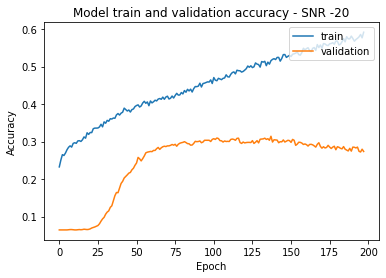

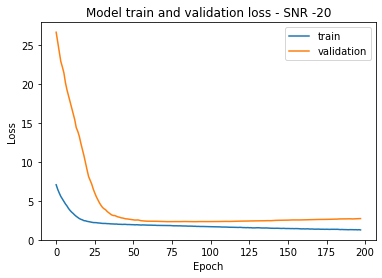

Score of SNR on low SNR model without Transfer Learning -20 = 40.97902178764343

Training SNR = -20 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 2s 84ms/step - loss: 3.9545 - accuracy: 0.3433 - val_loss: 1.9542 - val_accuracy: 0.3874
Epoch 2/200
7/7 [==============================] - 1s 78ms/step - loss: 3.5016 - accuracy: 0.3369 - val_loss: 2.0097 - val_accuracy: 0.3828
Epoch 3/200
7/7 [==============================] - 1s 75ms/step - loss: 3.1533 - accuracy: 0.3176 - val_loss: 2.0202 - val_accuracy: 0.3660
Epoch 4/200
7/7 [==============================] - 1s 80ms/step - loss: 2.8865 - accuracy: 0.3220 - val_loss: 2.0643 - val_accuracy: 0.3445
Epoch 5/200
7/7 [==============================] - 1s 75ms/step - loss: 2.7485 - accuracy: 0.3179 - val_loss: 2.2693 - val_accuracy: 0.2462
Epoch 6/200
7/7 [==============================] - 1s 76ms/step - loss: 2.5862 - accuracy: 0.3228 - val_loss: 2.3490 - val_accuracy: 0.2214
Epoch 7/200
7/7 [======

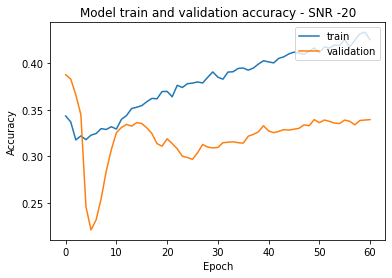

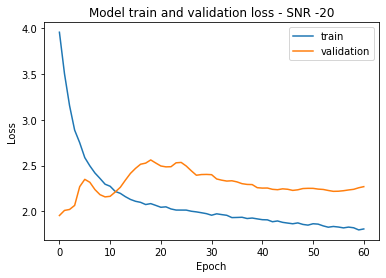

[[30.81585169 30.81585169]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[39.48718011 34.35897529]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 6.06060624 30.02330959]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[40.97902179 36.36363745]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        

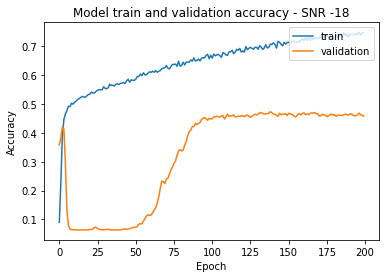

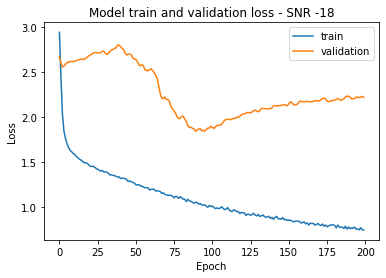


Score of SNR on All SNR model without Transfer Learning -18 = 53.892773389816284

Training SNR = -18 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 83ms/step - loss: 3.2627 - accuracy: 0.4597 - val_loss: 1.5359 - val_accuracy: 0.5035
Epoch 2/200
7/7 [==============================] - 1s 74ms/step - loss: 2.9210 - accuracy: 0.4636 - val_loss: 1.5643 - val_accuracy: 0.5040
Epoch 3/200
7/7 [==============================] - 1s 74ms/step - loss: 2.6862 - accuracy: 0.4629 - val_loss: 1.5889 - val_accuracy: 0.5021
Epoch 4/200
7/7 [==============================] - 1s 74ms/step - loss: 2.4568 - accuracy: 0.4670 - val_loss: 1.5967 - val_accuracy: 0.5026
Epoch 5/200
7/7 [==============================] - 1s 76ms/step - loss: 2.3274 - accuracy: 0.4654 - val_loss: 1.5791 - val_accuracy: 0.5021
Epoch 6/200
7/7 [==============================] - 1s 76ms/step - loss: 2.1836 - accuracy: 0.4668 - val_loss: 1.5507 - val_accuracy: 0.5016
Epoch 7/200
7/7 [====

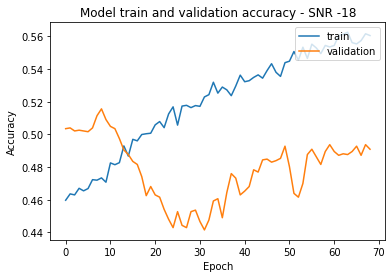

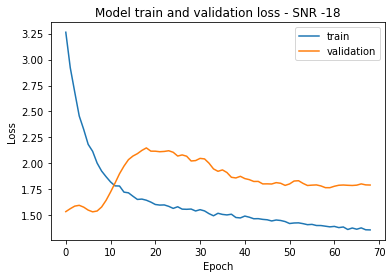

Score of SNR on High SNR model without Transfer Learning -18 = 6.200466305017471

Training SNR = -18 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 89ms/step - loss: 5.7242 - accuracy: 0.3448 - val_loss: 26.3744 - val_accuracy: 0.0732
Epoch 2/200
7/7 [==============================] - 1s 79ms/step - loss: 5.0596 - accuracy: 0.3789 - val_loss: 26.2269 - val_accuracy: 0.0732
Epoch 3/200
7/7 [==============================] - 1s 81ms/step - loss: 4.5524 - accuracy: 0.4075 - val_loss: 26.1272 - val_accuracy: 0.0737
Epoch 4/200
7/7 [==============================] - 1s 78ms/step - loss: 4.2248 - accuracy: 0.4179 - val_loss: 25.5911 - val_accuracy: 0.0737
Epoch 5/200
7/7 [==============================] - 1s 74ms/step - loss: 3.9542 - accuracy: 0.4256 - val_loss: 25.2915 - val_accuracy: 0.0741
Epoch 6/200
7/7 [==============================] - 1s 74ms/step - loss: 3.6711 - accuracy: 0.4430 - val_loss: 24.7264 - val_accuracy: 0.0746
Epoch 7/200
7/7

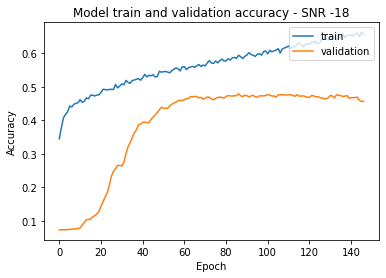

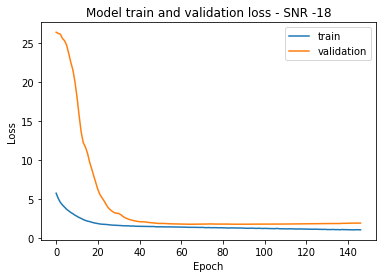

Score of SNR on low SNR model without Transfer Learning -18 = 56.130534410476685

Training SNR = -18 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 2s 88ms/step - loss: 2.5719 - accuracy: 0.4862 - val_loss: 1.5245 - val_accuracy: 0.5212
Epoch 2/200
7/7 [==============================] - 1s 78ms/step - loss: 2.3186 - accuracy: 0.4779 - val_loss: 1.5749 - val_accuracy: 0.5142
Epoch 3/200
7/7 [==============================] - 1s 80ms/step - loss: 2.1438 - accuracy: 0.4842 - val_loss: 1.5831 - val_accuracy: 0.5124
Epoch 4/200
7/7 [==============================] - 1s 74ms/step - loss: 1.9976 - accuracy: 0.4797 - val_loss: 1.5476 - val_accuracy: 0.5091
Epoch 5/200
7/7 [==============================] - 1s 77ms/step - loss: 1.9077 - accuracy: 0.4946 - val_loss: 1.5345 - val_accuracy: 0.5091
Epoch 6/200
7/7 [==============================] - 1s 75ms/step - loss: 1.8376 - accuracy: 0.4974 - val_loss: 1.5321 - val_accuracy: 0.5128
Epoch 7/200
7/7 [=====

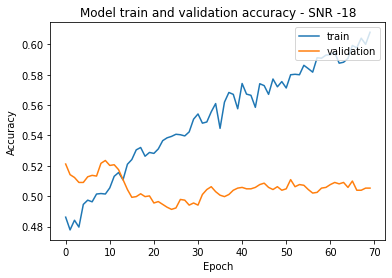

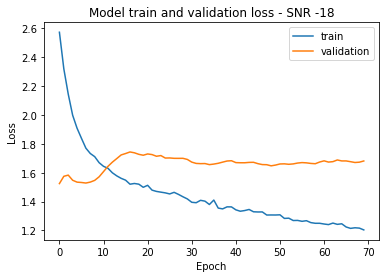

[[30.81585169 30.81585169]
 [47.03962803 47.03962803]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[39.48718011 34.35897529]
 [53.89277339 50.53613186]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 6.06060624 30.02330959]
 [ 6.20046631 48.06526899]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[40.97902179 36.36363745]
 [56.13053441 52.54079103]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        

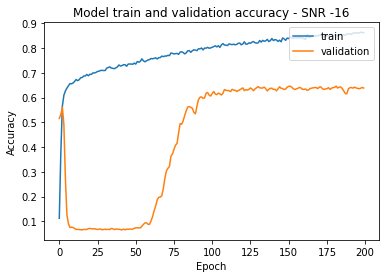

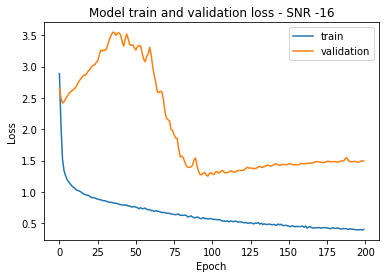


Score of SNR on All SNR model without Transfer Learning -16 = 66.71328544616699

Training SNR = -16 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 88ms/step - loss: 1.8654 - accuracy: 0.6196 - val_loss: 1.0500 - val_accuracy: 0.6578
Epoch 2/200
7/7 [==============================] - 1s 77ms/step - loss: 1.6624 - accuracy: 0.6300 - val_loss: 1.0984 - val_accuracy: 0.6564
Epoch 3/200
7/7 [==============================] - 1s 81ms/step - loss: 1.5200 - accuracy: 0.6421 - val_loss: 1.1342 - val_accuracy: 0.6527
Epoch 4/200
7/7 [==============================] - 1s 77ms/step - loss: 1.3858 - accuracy: 0.6434 - val_loss: 1.1390 - val_accuracy: 0.6508
Epoch 5/200
7/7 [==============================] - 1s 78ms/step - loss: 1.3129 - accuracy: 0.6522 - val_loss: 1.1175 - val_accuracy: 0.6536
Epoch 6/200
7/7 [==============================] - 1s 76ms/step - loss: 1.2546 - accuracy: 0.6443 - val_loss: 1.0805 - val_accuracy: 0.6564
Epoch 7/200
7/7 [=====

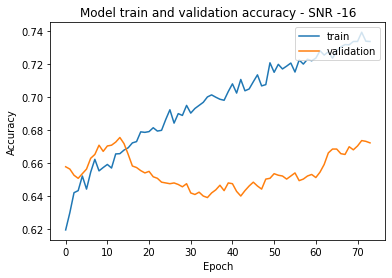

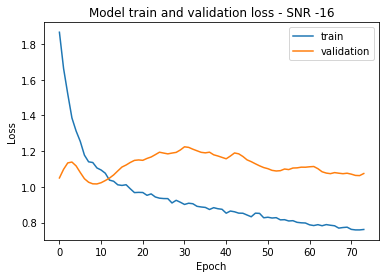

Score of SNR on High SNR model without Transfer Learning -16 = 7.0396266877651215

Training SNR = -16 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 86ms/step - loss: 4.0703 - accuracy: 0.4925 - val_loss: 23.0097 - val_accuracy: 0.0648
Epoch 2/200
7/7 [==============================] - 1s 80ms/step - loss: 3.4252 - accuracy: 0.5532 - val_loss: 23.4978 - val_accuracy: 0.0653
Epoch 3/200
7/7 [==============================] - 1s 78ms/step - loss: 2.9848 - accuracy: 0.5759 - val_loss: 24.2866 - val_accuracy: 0.0653
Epoch 4/200
7/7 [==============================] - 1s 76ms/step - loss: 2.7054 - accuracy: 0.5916 - val_loss: 25.0297 - val_accuracy: 0.0643
Epoch 5/200
7/7 [==============================] - 1s 76ms/step - loss: 2.4178 - accuracy: 0.6056 - val_loss: 25.4737 - val_accuracy: 0.0643
Epoch 6/200
7/7 [==============================] - 1s 80ms/step - loss: 2.2544 - accuracy: 0.6123 - val_loss: 25.6763 - val_accuracy: 0.0639
Epoch 7/200
7/

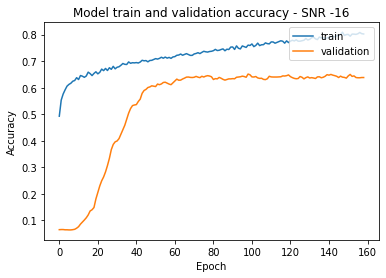

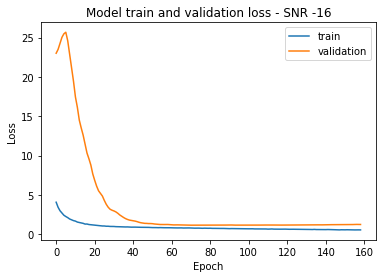

Score of SNR on low SNR model without Transfer Learning -16 = 67.17948913574219

Training SNR = -16 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 3s 90ms/step - loss: 1.3985 - accuracy: 0.6462 - val_loss: 1.0149 - val_accuracy: 0.6685
Epoch 2/200
7/7 [==============================] - 1s 78ms/step - loss: 1.2580 - accuracy: 0.6528 - val_loss: 1.0433 - val_accuracy: 0.6620
Epoch 3/200
7/7 [==============================] - 1s 75ms/step - loss: 1.1557 - accuracy: 0.6549 - val_loss: 1.0255 - val_accuracy: 0.6639
Epoch 4/200
7/7 [==============================] - 1s 75ms/step - loss: 1.0996 - accuracy: 0.6636 - val_loss: 0.9793 - val_accuracy: 0.6737
Epoch 5/200
7/7 [==============================] - 1s 75ms/step - loss: 1.0679 - accuracy: 0.6685 - val_loss: 0.9330 - val_accuracy: 0.6844
Epoch 6/200
7/7 [==============================] - 1s 81ms/step - loss: 1.0440 - accuracy: 0.6743 - val_loss: 0.9021 - val_accuracy: 0.6951
Epoch 7/200
7/7 [======

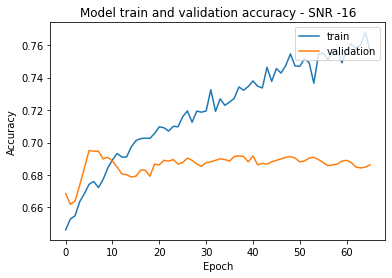

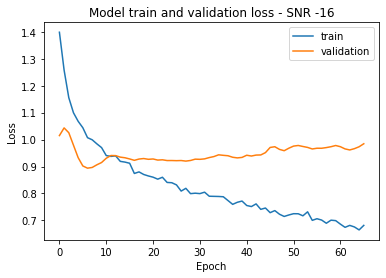

[[30.81585169 30.81585169]
 [47.03962803 47.03962803]
 [64.80186582 64.80186582]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[39.48718011 34.35897529]
 [53.89277339 50.53613186]
 [66.71328545 67.45920777]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 6.06060624 30.02330959]
 [ 6.20046631 48.06526899]
 [ 7.03962669 64.38228488]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[40.97902179 36.36363745]
 [56.13053441 52.54079103]
 [67.17948914 68.76456738]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        

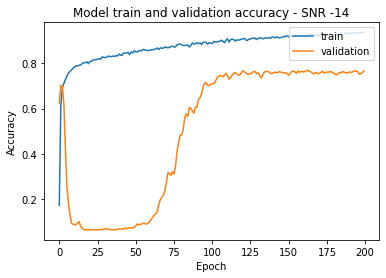

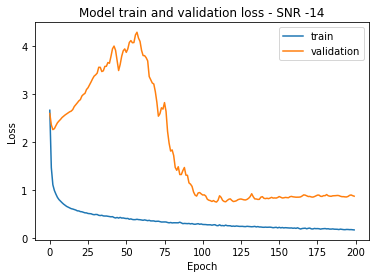


Score of SNR on All SNR model without Transfer Learning -14 = 75.43123364448547

Training SNR = -14 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 3s 87ms/step - loss: 1.1008 - accuracy: 0.7405 - val_loss: 0.7361 - val_accuracy: 0.7357
Epoch 2/200
7/7 [==============================] - 1s 80ms/step - loss: 0.9321 - accuracy: 0.7546 - val_loss: 0.7833 - val_accuracy: 0.7235
Epoch 3/200
7/7 [==============================] - 1s 81ms/step - loss: 0.8519 - accuracy: 0.7582 - val_loss: 0.8026 - val_accuracy: 0.7240
Epoch 4/200
7/7 [==============================] - 1s 75ms/step - loss: 0.7825 - accuracy: 0.7653 - val_loss: 0.8071 - val_accuracy: 0.7277
Epoch 5/200
7/7 [==============================] - 1s 75ms/step - loss: 0.7063 - accuracy: 0.7681 - val_loss: 0.7977 - val_accuracy: 0.7319
Epoch 6/200
7/7 [==============================] - 1s 77ms/step - loss: 0.6837 - accuracy: 0.7725 - val_loss: 0.7848 - val_accuracy: 0.7343
Epoch 7/200
7/7 [=====

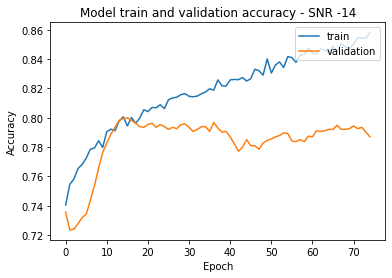

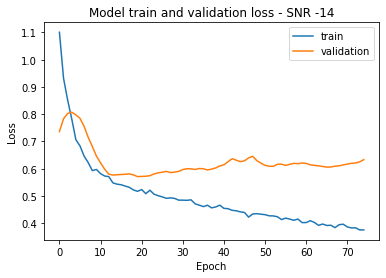

Score of SNR on High SNR model without Transfer Learning -14 = 6.759906560182571

Training SNR = -14 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 89ms/step - loss: 2.8860 - accuracy: 0.6362 - val_loss: 22.4059 - val_accuracy: 0.0690
Epoch 2/200
7/7 [==============================] - 1s 76ms/step - loss: 2.2224 - accuracy: 0.6876 - val_loss: 23.3399 - val_accuracy: 0.0695
Epoch 3/200
7/7 [==============================] - 1s 80ms/step - loss: 1.8455 - accuracy: 0.7156 - val_loss: 24.9906 - val_accuracy: 0.0681
Epoch 4/200
7/7 [==============================] - 1s 76ms/step - loss: 1.6036 - accuracy: 0.7235 - val_loss: 27.1121 - val_accuracy: 0.0681
Epoch 5/200
7/7 [==============================] - 1s 76ms/step - loss: 1.4043 - accuracy: 0.7340 - val_loss: 27.2585 - val_accuracy: 0.0681
Epoch 6/200
7/7 [==============================] - 1s 74ms/step - loss: 1.2534 - accuracy: 0.7514 - val_loss: 25.4245 - val_accuracy: 0.0695
Epoch 7/200
7/7

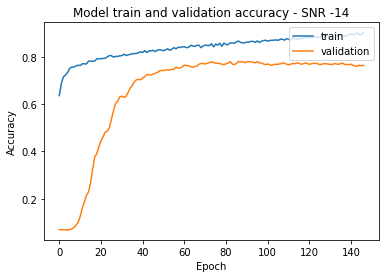

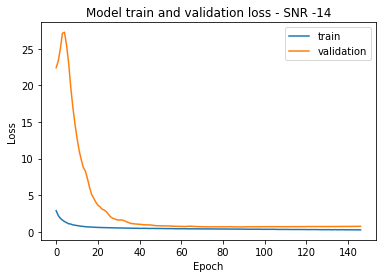

Score of SNR on low SNR model without Transfer Learning -14 = 76.27039551734924

Training SNR = -14 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 2s 89ms/step - loss: 0.7933 - accuracy: 0.7532 - val_loss: 0.6326 - val_accuracy: 0.7632
Epoch 2/200
7/7 [==============================] - 1s 78ms/step - loss: 0.6706 - accuracy: 0.7739 - val_loss: 0.5913 - val_accuracy: 0.7795
Epoch 3/200
7/7 [==============================] - 1s 79ms/step - loss: 0.6164 - accuracy: 0.7826 - val_loss: 0.5560 - val_accuracy: 0.7967
Epoch 4/200
7/7 [==============================] - 1s 76ms/step - loss: 0.5920 - accuracy: 0.7818 - val_loss: 0.5397 - val_accuracy: 0.8014
Epoch 5/200
7/7 [==============================] - 1s 79ms/step - loss: 0.5726 - accuracy: 0.7944 - val_loss: 0.5220 - val_accuracy: 0.8042
Epoch 6/200
7/7 [==============================] - 1s 79ms/step - loss: 0.5568 - accuracy: 0.7986 - val_loss: 0.5123 - val_accuracy: 0.8084
Epoch 7/200
7/7 [======

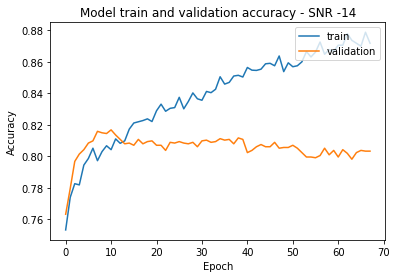

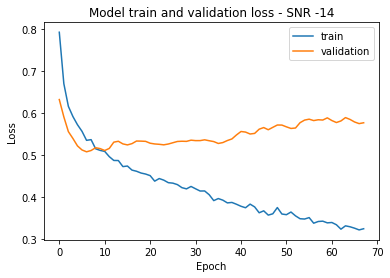

[[30.81585169 30.81585169]
 [47.03962803 47.03962803]
 [64.80186582 64.80186582]
 [74.82517362 74.82517362]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[39.48718011 34.35897529]
 [53.89277339 50.53613186]
 [66.71328545 67.45920777]
 [75.43123364 77.71561742]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 6.06060624 30.02330959]
 [ 6.20046631 48.06526899]
 [ 7.03962669 64.38228488]
 [ 6.75990656 75.61771274]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[40.97902179 36.36363745]
 [56.13053441 52.54079103]
 [67.17948914 68.76456738]
 [76.27039552 78.46153975]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        

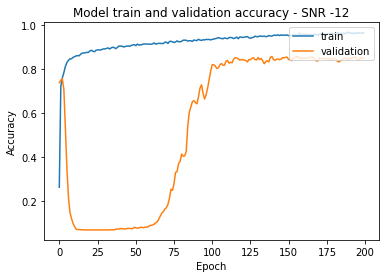

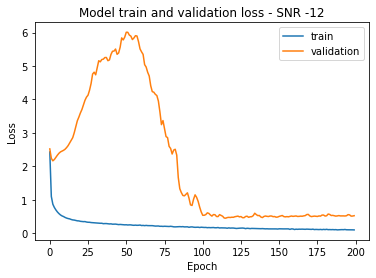


Score of SNR on All SNR model without Transfer Learning -12 = 79.48718070983887

Training SNR = -12 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 89ms/step - loss: 0.7276 - accuracy: 0.7995 - val_loss: 0.5563 - val_accuracy: 0.7879
Epoch 2/200
7/7 [==============================] - 1s 77ms/step - loss: 0.5938 - accuracy: 0.8227 - val_loss: 0.5626 - val_accuracy: 0.7846
Epoch 3/200
7/7 [==============================] - 1s 80ms/step - loss: 0.5169 - accuracy: 0.8333 - val_loss: 0.5456 - val_accuracy: 0.7846
Epoch 4/200
7/7 [==============================] - 1s 78ms/step - loss: 0.4524 - accuracy: 0.8443 - val_loss: 0.5401 - val_accuracy: 0.7874
Epoch 5/200
7/7 [==============================] - 1s 76ms/step - loss: 0.4292 - accuracy: 0.8539 - val_loss: 0.5375 - val_accuracy: 0.7939
Epoch 6/200
7/7 [==============================] - 1s 77ms/step - loss: 0.3923 - accuracy: 0.8550 - val_loss: 0.5212 - val_accuracy: 0.8000
Epoch 7/200
7/7 [=====

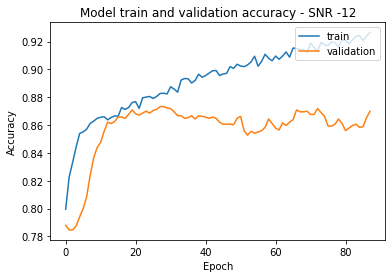

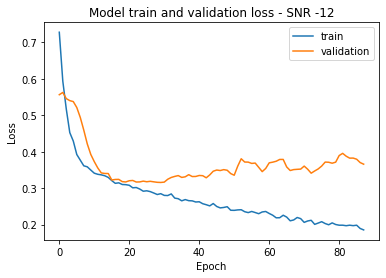

Score of SNR on High SNR model without Transfer Learning -12 = 8.811188489198685

Training SNR = -12 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 3s 90ms/step - loss: 1.9275 - accuracy: 0.7360 - val_loss: 20.4828 - val_accuracy: 0.0718
Epoch 2/200
7/7 [==============================] - 1s 77ms/step - loss: 1.3943 - accuracy: 0.7821 - val_loss: 23.1979 - val_accuracy: 0.0685
Epoch 3/200
7/7 [==============================] - 1s 76ms/step - loss: 1.1129 - accuracy: 0.8068 - val_loss: 25.3396 - val_accuracy: 0.0685
Epoch 4/200
7/7 [==============================] - 1s 84ms/step - loss: 0.9347 - accuracy: 0.8214 - val_loss: 25.7861 - val_accuracy: 0.0685
Epoch 5/200
7/7 [==============================] - 1s 81ms/step - loss: 0.8063 - accuracy: 0.8289 - val_loss: 24.7857 - val_accuracy: 0.0695
Epoch 6/200
7/7 [==============================] - 1s 74ms/step - loss: 0.6877 - accuracy: 0.8413 - val_loss: 23.1132 - val_accuracy: 0.0723
Epoch 7/200
7/7

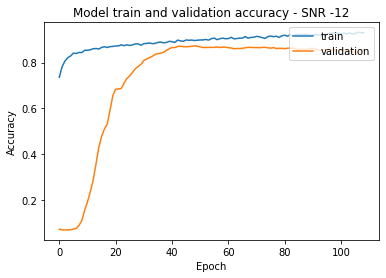

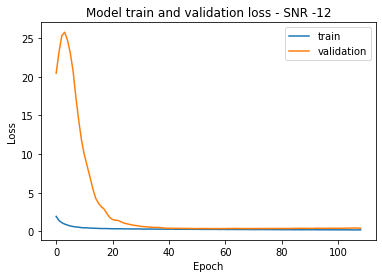

Score of SNR on low SNR model without Transfer Learning -12 = 80.69930076599121

Training SNR = -12 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 2s 93ms/step - loss: 0.4957 - accuracy: 0.8219 - val_loss: 0.3989 - val_accuracy: 0.8322
Epoch 2/200
7/7 [==============================] - 1s 79ms/step - loss: 0.4132 - accuracy: 0.8435 - val_loss: 0.3326 - val_accuracy: 0.8541
Epoch 3/200
7/7 [==============================] - 1s 74ms/step - loss: 0.3681 - accuracy: 0.8595 - val_loss: 0.3160 - val_accuracy: 0.8573
Epoch 4/200
7/7 [==============================] - 1s 74ms/step - loss: 0.3540 - accuracy: 0.8601 - val_loss: 0.3097 - val_accuracy: 0.8629
Epoch 5/200
7/7 [==============================] - 1s 78ms/step - loss: 0.3289 - accuracy: 0.8702 - val_loss: 0.3078 - val_accuracy: 0.8657
Epoch 6/200
7/7 [==============================] - 1s 75ms/step - loss: 0.3346 - accuracy: 0.8659 - val_loss: 0.3051 - val_accuracy: 0.8671
Epoch 7/200
7/7 [======

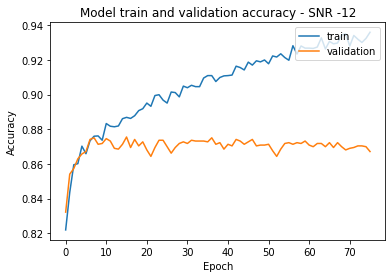

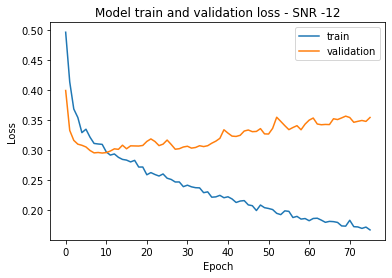

[[30.81585169 30.81585169]
 [47.03962803 47.03962803]
 [64.80186582 64.80186582]
 [74.82517362 74.82517362]
 [84.52214599 84.52214599]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[39.48718011 34.35897529]
 [53.89277339 50.53613186]
 [66.71328545 67.45920777]
 [75.43123364 77.71561742]
 [79.48718071 86.20046377]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 6.06060624 30.02330959]
 [ 6.20046631 48.06526899]
 [ 7.03962669 64.38228488]
 [ 6.75990656 75.61771274]
 [ 8.81118849 84.38228369]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[40.97902179 36.36363745]
 [56.13053441 52.54079103]
 [67.17948914 68.76456738]
 [76.27039552 78.46153975]
 [80.69930077 86.43356562]
 [ 0.          0.        ]
 [ 0.          0.        

In [24]:
for i in range(0, 5):

  fft_data_complex_curr = np.reshape(x_data_fft_data[:,i].flatten()[::2] + 1j*x_data_fft_data[:,i].flatten()[1::2], (total_num_snapshots, num_samples))
  fft_data_abs_curr = scaler_01.fit_transform(np.absolute(fft_data_complex_curr))
  fft_data_abs_curr = np.reshape(fft_data_abs_curr, (total_num_snapshots, num_samples, 1))

  y_labels_curr = to_categorical(y_labels_data[:,i].flatten())

  X_train_curr, X_test_valid_curr, Y_train_curr, Y_test_valid_curr = train_test_split(fft_data_abs_curr, y_labels_curr, test_size=0.4)
  X_validation_curr, X_test_curr, Y_validation_curr, Y_test_curr = train_test_split(X_test_valid_curr, Y_test_valid_curr, test_size=0.5)

  scores_without_tf_abs[i] = train_data(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, i)
  scores_tf_allsnr_abs[i] = train_data_on_all_snr_model(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, model_folder_all, i)
  scores_tf_highsnr_abs[i] = train_data_on_high_snr_model(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, model_folder_high, i)
  scores_tf_lowsnr_abs[i] = train_data_on_low_snr_model(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, model_folder_low, i)

  print(scores_without_tf_abs, scores_tf_allsnr_abs, scores_tf_highsnr_abs, scores_tf_lowsnr_abs)


Training SNR = -10 Data

Epoch 1/200
7/7 [==============================] - 46s 226ms/step - loss: 2.3985 - accuracy: 0.2699 - val_loss: 2.4072 - val_accuracy: 0.7716
Epoch 2/200
7/7 [==============================] - 0s 70ms/step - loss: 0.8920 - accuracy: 0.7580 - val_loss: 2.1387 - val_accuracy: 0.7608
Epoch 3/200
7/7 [==============================] - 0s 72ms/step - loss: 0.7021 - accuracy: 0.7978 - val_loss: 2.1318 - val_accuracy: 0.7184
Epoch 4/200
7/7 [==============================] - 0s 70ms/step - loss: 0.6135 - accuracy: 0.8421 - val_loss: 2.2148 - val_accuracy: 0.6727
Epoch 5/200
7/7 [==============================] - 0s 71ms/step - loss: 0.5277 - accuracy: 0.8767 - val_loss: 2.3023 - val_accuracy: 0.5128
Epoch 6/200
7/7 [==============================] - 0s 71ms/step - loss: 0.4782 - accuracy: 0.8826 - val_loss: 2.3792 - val_accuracy: 0.2713
Epoch 7/200
7/7 [==============================] - 0s 71ms/step - loss: 0.4312 - accuracy: 0.8874 - val_loss: 2.4360 - val_accuracy:

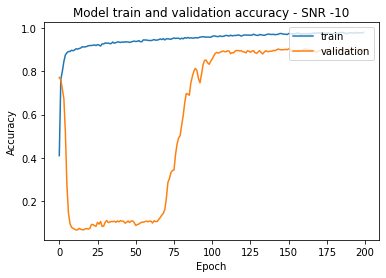

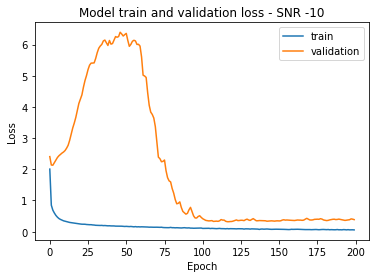


Score of SNR on All SNR model without Transfer Learning -10 = 83.31002593040466

Training SNR = -10 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 81ms/step - loss: 0.4901 - accuracy: 0.8452 - val_loss: 0.3998 - val_accuracy: 0.8364
Epoch 2/200
7/7 [==============================] - 0s 72ms/step - loss: 0.3864 - accuracy: 0.8723 - val_loss: 0.3500 - val_accuracy: 0.8573
Epoch 3/200
7/7 [==============================] - 0s 72ms/step - loss: 0.3347 - accuracy: 0.8848 - val_loss: 0.3174 - val_accuracy: 0.8662
Epoch 4/200
7/7 [==============================] - 1s 72ms/step - loss: 0.2884 - accuracy: 0.8968 - val_loss: 0.3051 - val_accuracy: 0.8709
Epoch 5/200
7/7 [==============================] - 1s 73ms/step - loss: 0.2785 - accuracy: 0.8956 - val_loss: 0.3070 - val_accuracy: 0.8667
Epoch 6/200
7/7 [==============================] - 1s 73ms/step - loss: 0.2535 - accuracy: 0.9041 - val_loss: 0.2993 - val_accuracy: 0.8685
Epoch 7/200
7/7 [=====

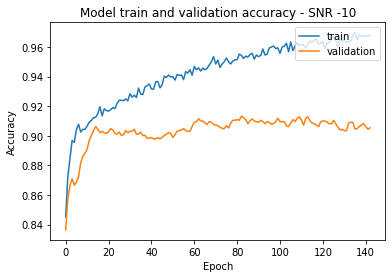

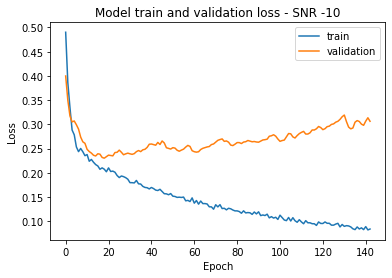

Score of SNR on High SNR model without Transfer Learning -10 = 11.235431581735611

Training SNR = -10 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 82ms/step - loss: 1.1473 - accuracy: 0.8210 - val_loss: 16.6471 - val_accuracy: 0.0853
Epoch 2/200
7/7 [==============================] - 1s 72ms/step - loss: 0.7873 - accuracy: 0.8527 - val_loss: 18.9526 - val_accuracy: 0.0797
Epoch 3/200
7/7 [==============================] - 0s 72ms/step - loss: 0.6296 - accuracy: 0.8752 - val_loss: 20.3411 - val_accuracy: 0.0797
Epoch 4/200
7/7 [==============================] - 0s 71ms/step - loss: 0.5036 - accuracy: 0.8853 - val_loss: 20.2475 - val_accuracy: 0.0830
Epoch 5/200
7/7 [==============================] - 1s 72ms/step - loss: 0.4506 - accuracy: 0.8884 - val_loss: 18.6432 - val_accuracy: 0.0928
Epoch 6/200
7/7 [==============================] - 1s 73ms/step - loss: 0.4025 - accuracy: 0.8945 - val_loss: 16.7829 - val_accuracy: 0.1058
Epoch 7/200
7/

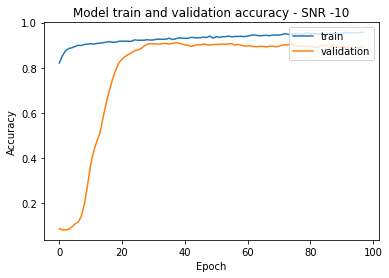

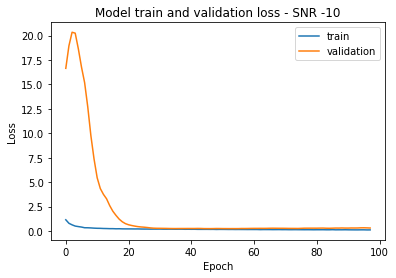

Score of SNR on low SNR model without Transfer Learning -10 = 84.80186462402344

Training SNR = -10 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 2s 81ms/step - loss: 0.3508 - accuracy: 0.8614 - val_loss: 0.2535 - val_accuracy: 0.8862
Epoch 2/200
7/7 [==============================] - 1s 75ms/step - loss: 0.2719 - accuracy: 0.8931 - val_loss: 0.2242 - val_accuracy: 0.9021
Epoch 3/200
7/7 [==============================] - 1s 76ms/step - loss: 0.2560 - accuracy: 0.9002 - val_loss: 0.2356 - val_accuracy: 0.9058
Epoch 4/200
7/7 [==============================] - 1s 75ms/step - loss: 0.2425 - accuracy: 0.9030 - val_loss: 0.2254 - val_accuracy: 0.9082
Epoch 5/200
7/7 [==============================] - 1s 73ms/step - loss: 0.2326 - accuracy: 0.9064 - val_loss: 0.2170 - val_accuracy: 0.9082
Epoch 6/200
7/7 [==============================] - 1s 72ms/step - loss: 0.2262 - accuracy: 0.9046 - val_loss: 0.2161 - val_accuracy: 0.9082
Epoch 7/200
7/7 [======

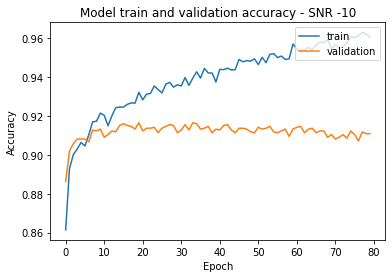

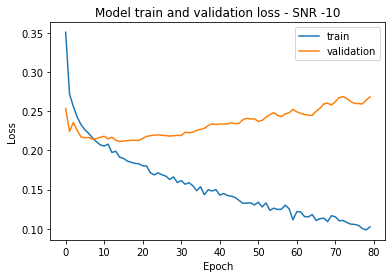

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [89.04429078 89.04429078]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [83.31002593 90.58275223]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [11.23543158 88.90442848]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [84.80186462 90.81584811]
 [ 0.          0.        

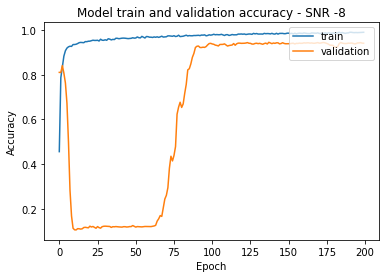

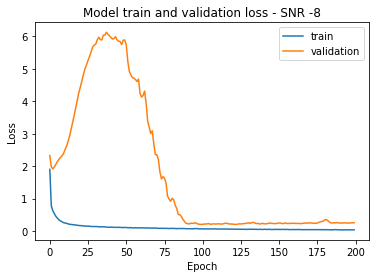


Score of SNR on All SNR model without Transfer Learning -8 = 87.55244612693787

Training SNR = -8 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 81ms/step - loss: 0.3211 - accuracy: 0.8884 - val_loss: 0.2416 - val_accuracy: 0.9035
Epoch 2/200
7/7 [==============================] - 1s 76ms/step - loss: 0.2342 - accuracy: 0.9153 - val_loss: 0.1839 - val_accuracy: 0.9166
Epoch 3/200
7/7 [==============================] - 1s 73ms/step - loss: 0.1966 - accuracy: 0.9305 - val_loss: 0.1734 - val_accuracy: 0.9245
Epoch 4/200
7/7 [==============================] - 1s 75ms/step - loss: 0.1916 - accuracy: 0.9322 - val_loss: 0.1735 - val_accuracy: 0.9240
Epoch 5/200
7/7 [==============================] - 1s 72ms/step - loss: 0.1765 - accuracy: 0.9335 - val_loss: 0.1675 - val_accuracy: 0.9273
Epoch 6/200
7/7 [==============================] - 1s 72ms/step - loss: 0.1709 - accuracy: 0.9332 - val_loss: 0.1678 - val_accuracy: 0.9291
Epoch 7/200
7/7 [=======

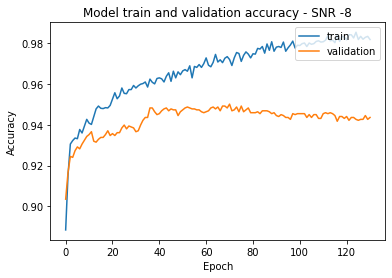

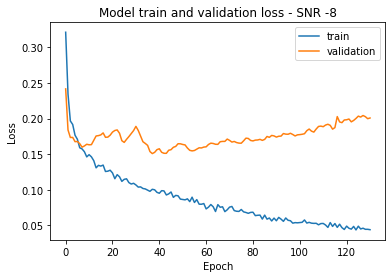

Score of SNR on High SNR model without Transfer Learning -8 = 25.1748263835907

Training SNR = -8 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 86ms/step - loss: 0.6202 - accuracy: 0.8805 - val_loss: 9.4977 - val_accuracy: 0.1953
Epoch 2/200
7/7 [==============================] - 1s 74ms/step - loss: 0.3891 - accuracy: 0.9161 - val_loss: 9.9039 - val_accuracy: 0.2103
Epoch 3/200
7/7 [==============================] - 1s 76ms/step - loss: 0.2874 - accuracy: 0.9322 - val_loss: 8.4134 - val_accuracy: 0.2755
Epoch 4/200
7/7 [==============================] - 1s 75ms/step - loss: 0.2471 - accuracy: 0.9358 - val_loss: 6.1973 - val_accuracy: 0.3599
Epoch 5/200
7/7 [==============================] - 1s 73ms/step - loss: 0.2303 - accuracy: 0.9395 - val_loss: 4.0821 - val_accuracy: 0.4909
Epoch 6/200
7/7 [==============================] - 1s 73ms/step - loss: 0.2187 - accuracy: 0.9414 - val_loss: 2.6432 - val_accuracy: 0.6145
Epoch 7/200
7/7 [=======

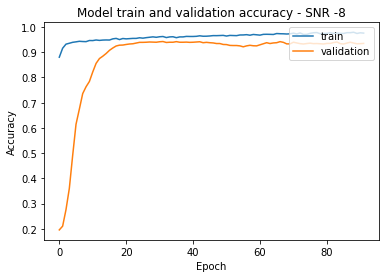

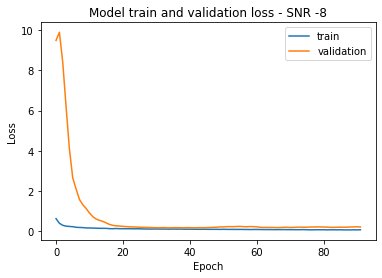

Score of SNR on low SNR model without Transfer Learning -8 = 88.01864981651306

Training SNR = -8 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 3s 147ms/step - loss: 0.2588 - accuracy: 0.8981 - val_loss: 0.1630 - val_accuracy: 0.9287
Epoch 2/200
7/7 [==============================] - 1s 78ms/step - loss: 0.1875 - accuracy: 0.9259 - val_loss: 0.1605 - val_accuracy: 0.9338
Epoch 3/200
7/7 [==============================] - 1s 75ms/step - loss: 0.1717 - accuracy: 0.9313 - val_loss: 0.1724 - val_accuracy: 0.9329
Epoch 4/200
7/7 [==============================] - 1s 79ms/step - loss: 0.1633 - accuracy: 0.9352 - val_loss: 0.1711 - val_accuracy: 0.9329
Epoch 5/200
7/7 [==============================] - 1s 73ms/step - loss: 0.1505 - accuracy: 0.9420 - val_loss: 0.1612 - val_accuracy: 0.9380
Epoch 6/200
7/7 [==============================] - 1s 75ms/step - loss: 0.1447 - accuracy: 0.9430 - val_loss: 0.1635 - val_accuracy: 0.9385
Epoch 7/200
7/7 [=======

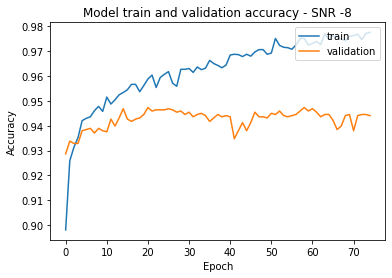

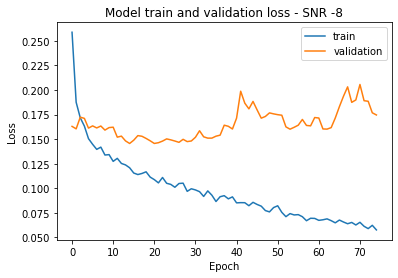

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [89.04429078 89.04429078]
 [94.26573515 94.26573515]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [83.31002593 90.58275223]
 [87.55244613 94.96503472]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [11.23543158 88.90442848]
 [25.17482638 94.40559149]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [84.80186462 90.81584811]
 [88.01864982 95.10489702

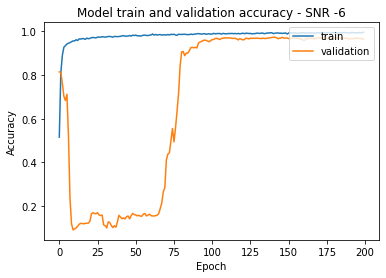

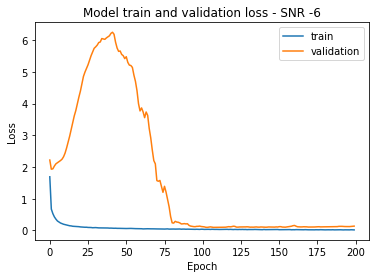


Score of SNR on All SNR model without Transfer Learning -6 = 89.04429078102112

Training SNR = -6 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 86ms/step - loss: 0.2049 - accuracy: 0.9242 - val_loss: 0.1521 - val_accuracy: 0.9399
Epoch 2/200
7/7 [==============================] - 1s 73ms/step - loss: 0.1417 - accuracy: 0.9469 - val_loss: 0.1305 - val_accuracy: 0.9497
Epoch 3/200
7/7 [==============================] - 1s 74ms/step - loss: 0.1225 - accuracy: 0.9540 - val_loss: 0.1259 - val_accuracy: 0.9548
Epoch 4/200
7/7 [==============================] - 1s 74ms/step - loss: 0.1200 - accuracy: 0.9512 - val_loss: 0.1299 - val_accuracy: 0.9520
Epoch 5/200
7/7 [==============================] - 0s 72ms/step - loss: 0.1127 - accuracy: 0.9568 - val_loss: 0.1312 - val_accuracy: 0.9538
Epoch 6/200
7/7 [==============================] - 1s 72ms/step - loss: 0.1090 - accuracy: 0.9571 - val_loss: 0.1189 - val_accuracy: 0.9580
Epoch 7/200
7/7 [=======

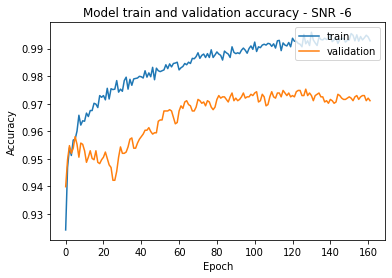

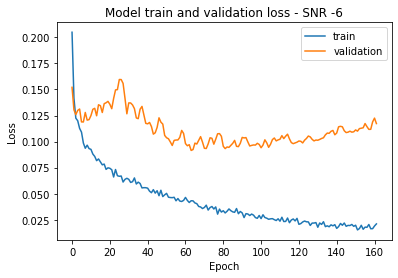

Score of SNR on High SNR model without Transfer Learning -6 = 53.65967154502869

Training SNR = -6 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 84ms/step - loss: 0.3072 - accuracy: 0.9374 - val_loss: 4.0107 - val_accuracy: 0.4993
Epoch 2/200
7/7 [==============================] - 1s 72ms/step - loss: 0.1973 - accuracy: 0.9534 - val_loss: 2.8508 - val_accuracy: 0.6359
Epoch 3/200
7/7 [==============================] - 1s 75ms/step - loss: 0.1648 - accuracy: 0.9579 - val_loss: 1.7840 - val_accuracy: 0.7524
Epoch 4/200
7/7 [==============================] - 1s 75ms/step - loss: 0.1393 - accuracy: 0.9610 - val_loss: 0.9511 - val_accuracy: 0.8392
Epoch 5/200
7/7 [==============================] - 1s 76ms/step - loss: 0.1162 - accuracy: 0.9653 - val_loss: 0.5776 - val_accuracy: 0.8821
Epoch 6/200
7/7 [==============================] - 1s 73ms/step - loss: 0.1154 - accuracy: 0.9655 - val_loss: 0.4274 - val_accuracy: 0.9082
Epoch 7/200
7/7 [======

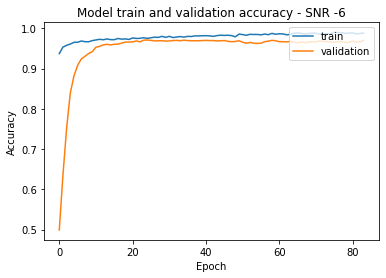

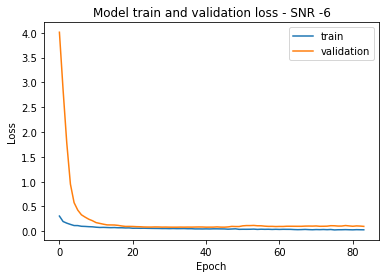

Score of SNR on low SNR model without Transfer Learning -6 = 90.39627313613892

Training SNR = -6 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 3s 155ms/step - loss: 0.2015 - accuracy: 0.9294 - val_loss: 0.1236 - val_accuracy: 0.9501
Epoch 2/200
7/7 [==============================] - 1s 78ms/step - loss: 0.1325 - accuracy: 0.9483 - val_loss: 0.1276 - val_accuracy: 0.9487
Epoch 3/200
7/7 [==============================] - 1s 73ms/step - loss: 0.1159 - accuracy: 0.9529 - val_loss: 0.1495 - val_accuracy: 0.9478
Epoch 4/200
7/7 [==============================] - 1s 76ms/step - loss: 0.1078 - accuracy: 0.9579 - val_loss: 0.1417 - val_accuracy: 0.9506
Epoch 5/200
7/7 [==============================] - 1s 75ms/step - loss: 0.1058 - accuracy: 0.9587 - val_loss: 0.1330 - val_accuracy: 0.9543
Epoch 6/200
7/7 [==============================] - 1s 79ms/step - loss: 0.0993 - accuracy: 0.9610 - val_loss: 0.1241 - val_accuracy: 0.9576
Epoch 7/200
7/7 [=======

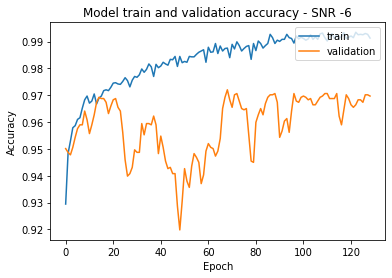

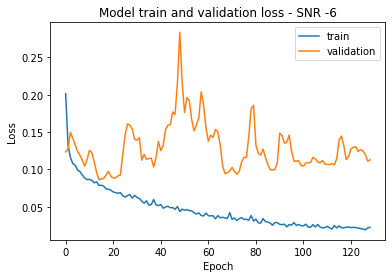

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [89.04429078 89.04429078]
 [94.26573515 94.26573515]
 [95.89743614 95.89743614]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [83.31002593 90.58275223]
 [87.55244613 94.96503472]
 [89.04429078 96.96969986]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [11.23543158 88.90442848]
 [25.17482638 94.40559149]
 [53.65967155 96.31701708]
 [ 0.          0.        ]
 [ 0.          0.        ]] [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [84.80186462 90.81584811]
 [88.01864982 95.10489702

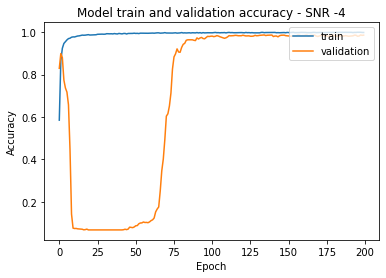

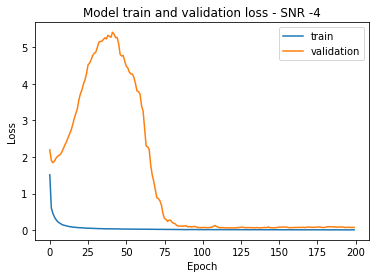


Score of SNR on All SNR model without Transfer Learning -4 = 92.21445322036743

Training SNR = -4 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 85ms/step - loss: 0.1213 - accuracy: 0.9574 - val_loss: 0.0847 - val_accuracy: 0.9613
Epoch 2/200
7/7 [==============================] - 1s 78ms/step - loss: 0.0752 - accuracy: 0.9734 - val_loss: 0.0899 - val_accuracy: 0.9608
Epoch 3/200
7/7 [==============================] - 1s 74ms/step - loss: 0.0616 - accuracy: 0.9772 - val_loss: 0.0993 - val_accuracy: 0.9590
Epoch 4/200
7/7 [==============================] - 1s 73ms/step - loss: 0.0623 - accuracy: 0.9761 - val_loss: 0.0859 - val_accuracy: 0.9692
Epoch 5/200
7/7 [==============================] - 1s 74ms/step - loss: 0.0577 - accuracy: 0.9795 - val_loss: 0.0705 - val_accuracy: 0.9734
Epoch 6/200
7/7 [==============================] - 1s 73ms/step - loss: 0.0527 - accuracy: 0.9814 - val_loss: 0.0538 - val_accuracy: 0.9786
Epoch 7/200
7/7 [=======

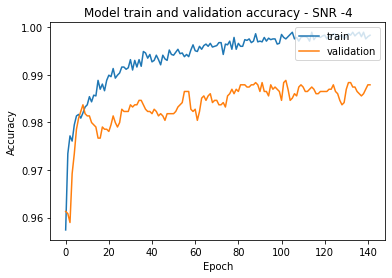

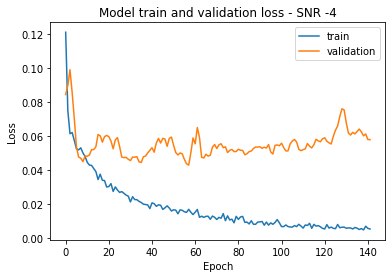

Score of SNR on High SNR model without Transfer Learning -4 = 86.20046377182007

Training SNR = -4 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 84ms/step - loss: 0.1088 - accuracy: 0.9708 - val_loss: 1.1836 - val_accuracy: 0.8238
Epoch 2/200
7/7 [==============================] - 1s 75ms/step - loss: 0.0590 - accuracy: 0.9831 - val_loss: 1.0479 - val_accuracy: 0.8350
Epoch 3/200
7/7 [==============================] - 1s 73ms/step - loss: 0.0453 - accuracy: 0.9857 - val_loss: 0.6468 - val_accuracy: 0.8895
Epoch 4/200
7/7 [==============================] - 1s 76ms/step - loss: 0.0496 - accuracy: 0.9845 - val_loss: 0.5183 - val_accuracy: 0.9091
Epoch 5/200
7/7 [==============================] - 1s 72ms/step - loss: 0.0393 - accuracy: 0.9873 - val_loss: 0.3766 - val_accuracy: 0.9310
Epoch 6/200
7/7 [==============================] - 1s 77ms/step - loss: 0.0357 - accuracy: 0.9869 - val_loss: 0.2486 - val_accuracy: 0.9552
Epoch 7/200
7/7 [======

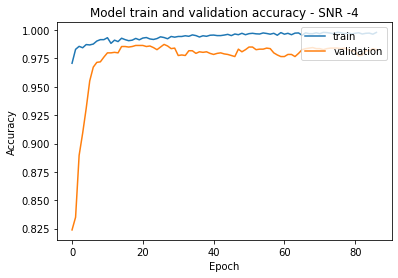

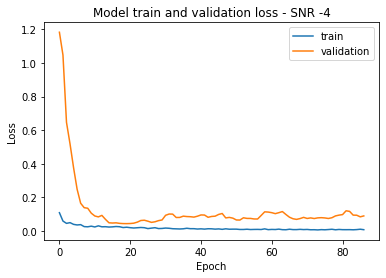

Score of SNR on low SNR model without Transfer Learning -4 = 93.56643557548523

Training SNR = -4 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 3s 181ms/step - loss: 0.1574 - accuracy: 0.9510 - val_loss: 0.0936 - val_accuracy: 0.9562
Epoch 2/200
7/7 [==============================] - 1s 74ms/step - loss: 0.0913 - accuracy: 0.9709 - val_loss: 0.1417 - val_accuracy: 0.9483
Epoch 3/200
7/7 [==============================] - 1s 75ms/step - loss: 0.0752 - accuracy: 0.9736 - val_loss: 0.2150 - val_accuracy: 0.9389
Epoch 4/200
7/7 [==============================] - 1s 75ms/step - loss: 0.0679 - accuracy: 0.9751 - val_loss: 0.2002 - val_accuracy: 0.9441
Epoch 5/200
7/7 [==============================] - 1s 76ms/step - loss: 0.0555 - accuracy: 0.9821 - val_loss: 0.1822 - val_accuracy: 0.9492
Epoch 6/200
7/7 [==============================] - 1s 76ms/step - loss: 0.0557 - accuracy: 0.9801 - val_loss: 0.1601 - val_accuracy: 0.9524
Epoch 7/200
7/7 [=======

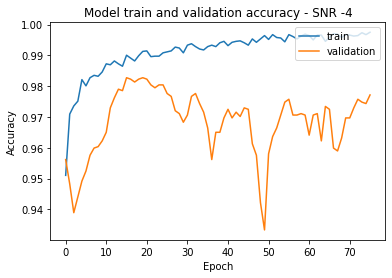

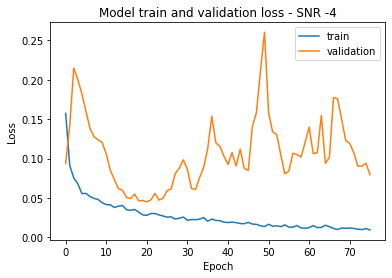

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [89.04429078 89.04429078]
 [94.26573515 94.26573515]
 [95.89743614 95.89743614]
 [98.6946404  98.6946404 ]
 [ 0.          0.        ]] [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [83.31002593 90.58275223]
 [87.55244613 94.96503472]
 [89.04429078 96.96969986]
 [92.21445322 98.88111949]
 [ 0.          0.        ]] [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [11.23543158 88.90442848]
 [25.17482638 94.40559149]
 [53.65967155 96.31701708]
 [86.20046377 98.04195762]
 [ 0.          0.        ]] [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [84.80186462 90.81584811]
 [88.01864982 95.10489702

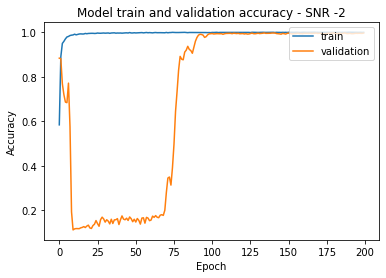

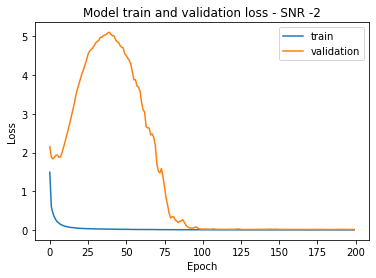


Score of SNR on All SNR model without Transfer Learning -2 = 94.59207653999329

Training SNR = -2 Data on a pre-trained All SNR model

Epoch 1/200
7/7 [==============================] - 2s 85ms/step - loss: 0.0753 - accuracy: 0.9801 - val_loss: 0.0519 - val_accuracy: 0.9823
Epoch 2/200
7/7 [==============================] - 1s 76ms/step - loss: 0.0412 - accuracy: 0.9866 - val_loss: 0.0448 - val_accuracy: 0.9846
Epoch 3/200
7/7 [==============================] - 0s 72ms/step - loss: 0.0329 - accuracy: 0.9893 - val_loss: 0.0620 - val_accuracy: 0.9734
Epoch 4/200
7/7 [==============================] - 1s 74ms/step - loss: 0.0317 - accuracy: 0.9901 - val_loss: 0.0494 - val_accuracy: 0.9786
Epoch 5/200
7/7 [==============================] - 0s 72ms/step - loss: 0.0257 - accuracy: 0.9911 - val_loss: 0.0333 - val_accuracy: 0.9865
Epoch 6/200
7/7 [==============================] - 1s 76ms/step - loss: 0.0251 - accuracy: 0.9925 - val_loss: 0.0219 - val_accuracy: 0.9907
Epoch 7/200
7/7 [=======

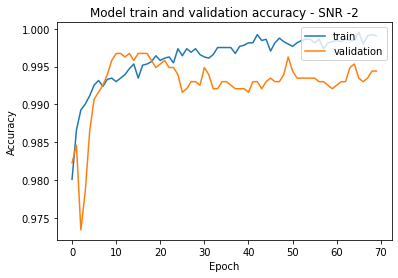

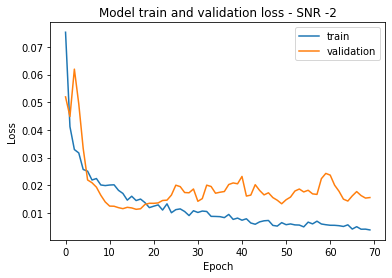

Score of SNR on High SNR model without Transfer Learning -2 = 98.6480176448822

Training SNR = -2 Data on a pre-trained High SNR model

Epoch 1/200
7/7 [==============================] - 2s 86ms/step - loss: 0.0367 - accuracy: 0.9894 - val_loss: 0.1581 - val_accuracy: 0.9664
Epoch 2/200
7/7 [==============================] - 1s 76ms/step - loss: 0.0231 - accuracy: 0.9929 - val_loss: 0.1183 - val_accuracy: 0.9720
Epoch 3/200
7/7 [==============================] - 1s 74ms/step - loss: 0.0187 - accuracy: 0.9936 - val_loss: 0.0540 - val_accuracy: 0.9846
Epoch 4/200
7/7 [==============================] - 1s 74ms/step - loss: 0.0133 - accuracy: 0.9946 - val_loss: 0.0515 - val_accuracy: 0.9869
Epoch 5/200
7/7 [==============================] - 1s 73ms/step - loss: 0.0140 - accuracy: 0.9955 - val_loss: 0.0451 - val_accuracy: 0.9888
Epoch 6/200
7/7 [==============================] - 1s 73ms/step - loss: 0.0111 - accuracy: 0.9961 - val_loss: 0.0265 - val_accuracy: 0.9925
Epoch 7/200
7/7 [=======

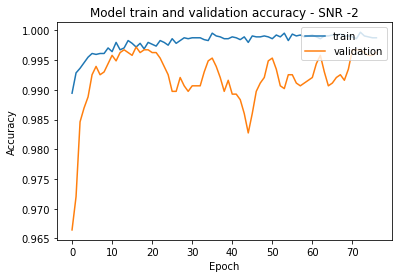

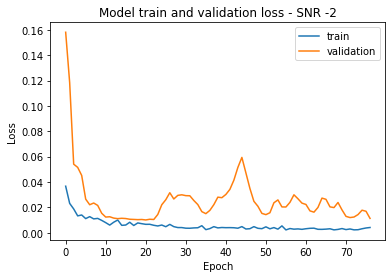

Score of SNR on low SNR model without Transfer Learning -2 = 96.1771547794342

Training SNR = -2 Data on a pre-trained Low SNR model

Epoch 1/200
7/7 [==============================] - 2s 85ms/step - loss: 0.1427 - accuracy: 0.9622 - val_loss: 0.0735 - val_accuracy: 0.9692
Epoch 2/200
7/7 [==============================] - 1s 72ms/step - loss: 0.0683 - accuracy: 0.9817 - val_loss: 0.1413 - val_accuracy: 0.9524
Epoch 3/200
7/7 [==============================] - 1s 72ms/step - loss: 0.0530 - accuracy: 0.9826 - val_loss: 0.2074 - val_accuracy: 0.9431
Epoch 4/200
7/7 [==============================] - 1s 72ms/step - loss: 0.0420 - accuracy: 0.9882 - val_loss: 0.2257 - val_accuracy: 0.9422
Epoch 5/200
7/7 [==============================] - 1s 76ms/step - loss: 0.0346 - accuracy: 0.9907 - val_loss: 0.2026 - val_accuracy: 0.9473
Epoch 6/200
7/7 [==============================] - 1s 76ms/step - loss: 0.0321 - accuracy: 0.9901 - val_loss: 0.1828 - val_accuracy: 0.9510
Epoch 7/200
7/7 [=========

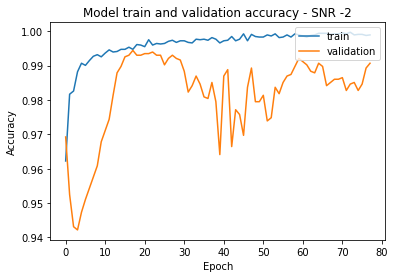

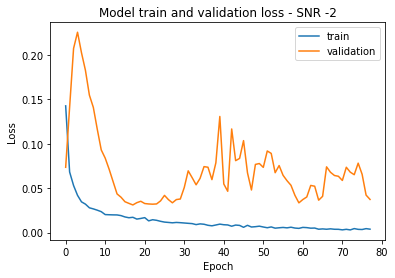

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [89.04429078 89.04429078]
 [94.26573515 94.26573515]
 [95.89743614 95.89743614]
 [98.6946404  98.6946404 ]
 [99.72028136 99.72028136]] [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [83.31002593 90.58275223]
 [87.55244613 94.96503472]
 [89.04429078 96.96969986]
 [92.21445322 98.88111949]
 [94.59207654 99.76689816]] [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [11.23543158 88.90442848]
 [25.17482638 94.40559149]
 [53.65967155 96.31701708]
 [86.20046377 98.04195762]
 [98.64801764 99.58041906]] [[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [84.80186462 90.81584811]
 [88.01864982 95.10489702

In [ ]:
for i in range(5, 10):

  fft_data_complex_curr = np.reshape(x_data_fft_data[:,i].flatten()[::2] + 1j*x_data_fft_data[:,i].flatten()[1::2], (total_num_snapshots, num_samples))
  fft_data_abs_curr = scaler_01.fit_transform(np.absolute(fft_data_complex_curr))
  fft_data_abs_curr = np.reshape(fft_data_abs_curr, (total_num_snapshots, num_samples, 1))

  y_labels_curr = to_categorical(y_labels_data[:,i].flatten())

  X_train_curr, X_test_valid_curr, Y_train_curr, Y_test_valid_curr = train_test_split(fft_data_abs_curr, y_labels_curr, test_size=0.4)
  X_validation_curr, X_test_curr, Y_validation_curr, Y_test_curr = train_test_split(X_test_valid_curr, Y_test_valid_curr, test_size=0.5)

  scores_without_tf_abs[i] = train_data(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, i)
  scores_tf_allsnr_abs[i] = train_data_on_all_snr_model(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, model_folder_all, i)
  scores_tf_highsnr_abs[i] = train_data_on_high_snr_model(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, model_folder_high, i)
  scores_tf_lowsnr_abs[i] = train_data_on_low_snr_model(X_train_curr, Y_train_curr, X_validation_curr, Y_validation_curr, X_test_curr, Y_test_curr, model_folder_low, i)

  print(scores_without_tf_abs, scores_tf_allsnr_abs, scores_tf_highsnr_abs, scores_tf_lowsnr_abs)

# Graphs and Results

## FFT 2D

In [ ]:
scores_without_tf_2d = [26.57342553, 42.51748323, 59.67366099, 72.96037078, 83.21678042, 86.71328425, 92.49417186, 94.40559149, 96.41025662, 96.96969986]
scores_tf_allsnr_2d = [[14.87179548, 21.72494233, 42.98368394, 66.57342911, 84.42890644, 90.30302763, 93.75291467, 95.6643343, 96.82983756, 97.71561623 ],
                       [32.5874120, 47.4592059,  65.87412357, 77.57575512, 85.59440374, 87.31935024, 91.84148908, 94.63869333, 96.92307711, 98.22843671]]
scores_tf_highsnr_2d = [[ 7.36596733, 6.75990656, 8.76456872, 12.63403296, 26.06060505, 54.91841435, 83.82284641, 95.01165748, 97.94871807, 98.83449674],
                        [25.82750618, 39.95338082, 58.22843909, 74.07925129, 84.0093255, 86.66666746, 90.53612947, 92.02797413, 94.12587285, 97.57575989]]
scores_tf_lowsnr_2d = [[35.19813418, 49.60373044, 72.02796936, 82.19113946, 87.0862484, 87.0862484, 89.13753033, 91.1421895, 91.00233316, 92.49417186],
                        [34.21911299, 49.93006885, 68.2051301, 78.18182111, 85.59440374, 87.55244613, 92.63403416, 95.85081339, 96.96969986, 97.76223898]]

In [ ]:
for i in range(10, 21):

  x_data_fft_curr = np.reshape(x_data_fft_data[:,i], (total_num_snapshots, x_dim[3], x_dim[4]))
  x_data_fft_curr = scaler_std.fit_transform(np.reshape(x_data_fft_curr, (total_num_snapshots, num_samples*2)))
  x_data_fft_curr = np.reshape(x_data_fft_curr, (total_num_snapshots, num_samples, 2))
  y_data_fft_curr = to_categorical(y_labels_data[:,i].flatten())

  X_train_curr, X_test_valid_curr, Y_train_curr, Y_test_valid_curr = train_test_split(x_data_fft_curr, y_data_fft_curr, test_size=0.4)
  X_validation_curr, X_test_curr, Y_validation_curr, Y_test_curr = train_test_split(X_test_valid_curr, Y_test_valid_curr, test_size=0.5)

  model_folder_all = "/gdrive/My Drive/Trained Models/fft/fft_2d_allSNR.tf"
  model_folder_high = "/gdrive/My Drive/Trained Models/fft/fft_2d_highSNR.tf"
  model_folder_low = "/gdrive/My Drive/Trained Models/fft/fft_2d_lowSNR.tf"

  score = model_folder_all.evaluate(X_test_curr, Y_test_curr, verbose=0)
  scores_tf_allsnr_2d[0][i] = score[1]*100

  score = model_folder_high.evaluate(X_test_curr, Y_test_curr, verbose=0)
  scores_tf_highsnr_2d[0][i] = score[1]*100

  score = model_folder_low.evaluate(X_test_curr, Y_test_curr, verbose=0)
  scores_tf_lowsnr_2d[0][i] = score[1]*100

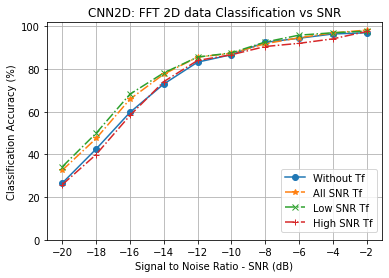

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-20, -2, 10)
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.plot(x,scores_without_tf_2d,'-o', x, scores_tf_allsnr_2d[1],'-.*', x, scores_tf_lowsnr_2d[1],'-.x', x, scores_tf_highsnr_2d[1], '-.+')
plt.title('CNN2D: FFT 2D data Classification vs SNR')
plt.xlabel('Signal to Noise Ratio - SNR (dB)')
plt.ylabel('Classification Accuracy (%)')
plt.legend(['Without Tf','All SNR Tf','Low SNR Tf', 'High SNR Tf'], loc='best', bbox_to_anchor=(1,0.35))
plt.xticks(x)
plt.yticks([0,20,40,60,80,100])
plt.rcParams.update({'font.size': 10})
plt.grid()
plt.show()

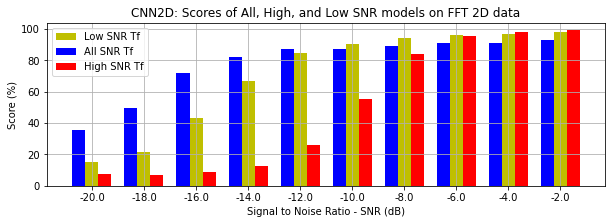

In [ ]:
y = [scores_tf_allsnr_2d[0], scores_tf_lowsnr_2d[0], scores_tf_highsnr_2d[0]]
r = np.arange(10)
width = 0.25  
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(3)
plt.bar(r, y[0], color = 'y', width = width)
plt.bar(r - width, y[1], color = 'b', width = width)
plt.bar(r + width, y[2], color = 'r', width = width)
plt.xlabel('Signal to Noise Ratio - SNR (dB)')
plt.ylabel('Score (%)')
plt.title('CNN2D: Scores of All, High, and Low SNR models on FFT 2D data')
plt.legend(['Low SNR Tf','All SNR Tf', 'High SNR Tf'])
x = np.linspace(-20, -2, 10)
plt.yticks([0,20,40,60,80,100])
plt.xticks(r, x)
plt.grid()
plt.show()

## FFT Amplitude

In [ ]:
for i in range(10, 21):

  fft_data_complex_curr = np.reshape(x_data_fft_data[:,i].flatten()[::2] + 1j*x_data_fft_data[:,i].flatten()[1::2], (total_num_snapshots, num_samples))
  fft_data_abs_curr = scaler_01.fit_transform(np.absolute(fft_data_complex_curr))
  fft_data_abs_curr = np.reshape(fft_data_abs_curr, (total_num_snapshots, num_samples, 1))
  y_labels_curr = to_categorical(y_labels_data[:,i].flatten())

  X_train_curr, X_test_valid_curr, Y_train_curr, Y_test_valid_curr = train_test_split(fft_data_abs_curr, y_labels_curr, test_size=0.4)
  X_validation_curr, X_test_curr, Y_validation_curr, Y_test_curr = train_test_split(X_test_valid_curr, Y_test_valid_curr, test_size=0.5)

  model_folder_all = "/gdrive/My Drive/Trained Models/fft/fft_abs_allSNR.tf"
  model_folder_high = "/gdrive/My Drive/Trained Models/fft/fft_abs_highSNR.tf"
  model_folder_low = "/gdrive/My Drive/Trained Models/fft/fft_abs_lowSNR.tf"

  score = model_folder_all.evaluate(X_test_curr, Y_test_curr, verbose=0)
  scores_tf_allsnr_abs[0][i] = score[1]*100

  score = model_folder_high.evaluate(X_test_curr, Y_test_curr, verbose=0)
  scores_tf_highsnr_abs[0][i] = score[1]*100

  score = model_folder_low.evaluate(X_test_curr, Y_test_curr, verbose=0)
  scores_tf_lowsnr_abs[0][i] = score[1]*100

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-20, -2, 10)
plt.plot(x,scores_without_tf_abs,'-o', x, scores_tf_allsnr_abs[1],'-.*', x, scores_tf_lowsnr_abs[1],'-.x', x, scores_tf_highsnr_abs[1], '-.+')
plt.title('CNN1D: FFT Amplitude data Classification vs SNR')
plt.xlabel('Signal to Noise Ratio - SNR (dB)')
plt.ylabel('Classification Accuracy (%)')
plt.legend(['Without Tf','All SNR Tf','Low SNR Tf', 'High SNR Tf'], loc='best', bbox_to_anchor=(1,0.35))
plt.xticks(x)
plt.yticks([0,20,40,60,80,100])
plt.rcParams.update({'font.size': 10})
plt.grid()
plt.show()

In [ ]:
y = [scores_tf_allsnr_abs[0], scores_tf_lowsnr_abs[0], scores_tf_highsnr_abs[0]]
r = np.arange(10)
width = 0.25  
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(3)
plt.bar(r, y[0], color = 'y', width = width)
plt.bar(r - width, y[1], color = 'b', width = width)
plt.bar(r + width, y[2], color = 'r', width = width)
plt.xlabel('Signal to Noise Ratio - SNR (dB)')
plt.ylabel('Score (%)')
plt.title('CNN1D: Scores of All, High, and Low SNR models on FFT Amplitude data')
plt.legend(['Low SNR Tf','All SNR Tf', 'High SNR Tf'])
x = np.linspace(-20, -2, 10)
plt.yticks([0,20,40,60,80,100])
plt.xticks(r, x)
plt.grid()
plt.show()